In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as st
import theano

from sklearn.metrics import confusion_matrix as conf_mat

%pylab inline
%config InlineBackend.figure_format = 'retina'
# %qtconsole --colors=linux
%load_ext watermark

plt.style.use('ggplot')
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

Populating the interactive namespace from numpy and matplotlib


In [2]:
%watermark -v -m -p numpy,pandas,seaborn,pymc3,matplotlib,theano

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
seaborn 0.9.0
pymc3 3.7
matplotlib 3.1.0
theano 1.0.4

compiler   : GCC 7.3.0
system     : Linux
release    : 4.19.67-2rodete2-amd64
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


# Content

- [Preprocessing](#Preprocessing)  
- [Descriptive Result](#Display-descriptive-result-by-group)  
- [Final Model](#Final-Model)

# Preprocessing

In [3]:
# load subject table
Subjinfo = pd.read_csv('data/participant_info.csv', ',')
Subjinfo.head()

group_id group  age  gender                 dynamic_static
0         1  Deaf   21  Female  data/001_g1_a21_DyExp_beh.txt
1         1  Deaf   20  Female  data/002_g1_a20_DyExp_beh.txt
2         1  Deaf   22    Male  data/003_g2_a22_DyExp_beh.txt
3         1  Deaf   24  Female  data/006_g1_a24_DyExp_beh.txt
4         1  Deaf   23  Female  data/007_g1_a23_DyExp_beh.txt

In [4]:
isbj = 0
datatmp = pd.read_csv(Subjinfo['dynamic_static'][isbj], '\t',
                      header=None)
# change column name
column_name = ['Trial', 'Resp', 'ACC', 'RT', 'cRect1', 'cRect2', 'cRect3', 'cRect4',
               'Randseq', 'Task']
datatmp.columns = column_name
# change stimuli name
stim_list = pd.read_csv('experiment_code/stimuli_list.csv', ',')
datatmp['Expression'] = np.asarray(
    stim_list['Expression'].loc[datatmp['Randseq']-1])
# change response name
resp_list = np.asarray(
    ['Fear', 'Anger', 'Disgust', 'Happiness', 'Sadness', 'Surprise'])
Resp = []
for iresp in datatmp['Resp']:
    if np.isfinite(iresp):
        Resp.append(resp_list[int(iresp-1)])
    else:
        Resp.append(np.nan)
datatmp['Resp_Exp'] = np.asarray(Resp)
# change task name
Taskname = np.asarray(['Dynamic', 'Shuffled', 'Static'])
datatmp['Task_nam'] = Taskname[datatmp['Task']-1]
# show dataframe (first 5 lines)
datatmp.head(5)

Trial  Resp  ACC        RT    cRect1    cRect2    cRect3    cRect4  \
0      1     5    1  4.729569  580.5176  160.5176  1339.482  919.4824   
1      2     6    0  1.856022  580.5176  160.5176  1339.482  919.4824   
2      3     3    1  3.826130  580.5176  160.5176  1339.482  919.4824   
3      4     3    1  0.097319  580.5176  160.5176  1339.482  919.4824   
4      5     6    0  0.340457  580.5176  160.5176  1339.482  919.4824   

   Randseq  Task Expression  Resp_Exp Task_nam  
0       37     1    Sadness   Sadness  Dynamic  
1       18     1       Fear  Surprise  Dynamic  
2       60     1    Disgust   Disgust  Dynamic  
3       64     1    Disgust   Disgust  Dynamic  
4       15     1    Disgust  Surprise  Dynamic

In [5]:
taskorder = datatmp.Task.unique() - 1
print('The task order is:' + str(taskorder))

labellist = np.asarray(
    ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise'])
for ij, itask in enumerate(Taskname):
    datatask = datatmp[datatmp['Task_nam'] == itask]
    conf_subj = conf_mat(datatask['Expression'],
                         datatask['Resp_Exp'], labels=labellist)
    conf_df = pd.DataFrame(conf_subj, columns=labellist, index=labellist)
    conf_df['trials'] = datatask['Expression'].value_counts()
    print('\n'+itask)
    print(conf_df)

The task order is:[0 1 2]

Dynamic
           Anger  Disgust  Fear  Happiness  Sadness  Surprise  trials
Anger         13        1     1          0        1         0      16
Disgust        2        9     3          0        1         1      16
Fear           0        0     2          0        3        11      16
Happiness      0        0     0         16        0         0      16
Sadness        1        1     1          0       13         0      16
Surprise       0        0     0          3        0        13      16

Shuffled
           Anger  Disgust  Fear  Happiness  Sadness  Surprise  trials
Anger          9        4     0          0        3         0      16
Disgust        4        9     0          0        3         0      16
Fear           0        0     7          0        0         9      16
Happiness      0        0     0         15        1         0      16
Sadness        0        2     2          0       12         0      16
Surprise       0        0     0          4   

In [6]:
df_agg = datatask.groupby(['Expression', 'Resp_Exp'])['RT'].agg('mean')
df_rt = df_agg.iloc[df_agg.index.get_level_values(
    'Expression') == df_agg.index.get_level_values('Resp_Exp')]
df_rt.iloc[df_rt.index.get_level_values('Resp_Exp')==labellist]

Expression  Resp_Exp 
Anger       Anger        0.741698
Disgust     Disgust      0.453455
Fear        Fear         0.980844
Happiness   Happiness    0.228291
Sadness     Sadness      0.591436
Surprise    Surprise     0.494443
Name: RT, dtype: float64

In [7]:
def loadsbj(filepath, labellist, column_name, stim_list, Taskname):
    datatmp = pd.read_csv(filepath, '\t',
                          header=None)
    # change column name
    datatmp.columns = column_name
    # change stimuli name
    datatmp['Expression'] = np.asarray(
        stim_list['Expression'].loc[datatmp['Randseq']-1])
    # change response name
    Resp = []
    for iresp in datatmp['Resp']:
        if np.isfinite(iresp):
            Resp.append(resp_list[int(iresp-1)])
        else:
            Resp.append(np.nan)
    datatmp['Resp_Exp'] = np.asarray(Resp)
    # change task name
    datatmp['Task_nam'] = Taskname[datatmp['Task']-1]
    taskorder = datatmp.Task.unique() - 1
    conf_all = np.zeros((3, len(labellist), len(labellist)+1))
    rt_all = np.zeros((3, len(labellist)))
    for ij, itask in enumerate(Taskname):
        datatask = datatmp[datatmp['Task_nam'] == itask]
        if datatask.shape[0] > 0:
            conf_subj = conf_mat(
                datatask['Expression'], datatask['Resp_Exp'], labels=labellist)
            conf_df = pd.DataFrame(
                conf_subj, columns=labellist, index=labellist)
            conf_df['trials'] = datatask['Expression'].value_counts()
            conf_all[ij] = np.asarray(conf_df)

            df_agg = datatask.groupby(['Expression', 'Resp_Exp'])[
                'RT'].agg('mean')
            df_rt = df_agg.iloc[df_agg.index.get_level_values(
                'Expression') == df_agg.index.get_level_values('Resp_Exp')]
            rtval = []
            for label in labellist:
                rt_ = df_rt.iloc[df_rt.index.get_level_values(
                    'Resp_Exp') == label].values
                if rt_.size>0:
                    rtval.append(rt_)
                else:
                    rtval.append(np.nan)
            rt_all[ij] = np.asarray(rtval,dtype=float64).squeeze()

    return taskorder, np.asarray(conf_all), rt_all


Taskname = np.asarray(['Dynamic', 'Shuffled', 'Static'])
resp_list = np.asarray(
    ['Fear', 'Anger', 'Disgust', 'Happiness', 'Sadness', 'Surprise'])
column_name = ['Trial', 'Resp', 'ACC', 'RT', 'cRect1', 'cRect2', 'cRect3', 'cRect4',
               'Randseq', 'Task']
stim_list = pd.read_csv('experiment_code/stimuli_list.csv', ',')
labellist = np.asarray(
    ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise'])

filepath = Subjinfo['dynamic_static'][isbj]
taskorder, conf_all, rt_all = loadsbj(
    filepath, labellist, column_name, stim_list, Taskname)
print(taskorder)
print(conf_all)
print(rt_all)

[0 1 2]
[[[13.  1.  1.  0.  1.  0. 16.]
  [ 2.  9.  3.  0.  1.  1. 16.]
  [ 0.  0.  2.  0.  3. 11. 16.]
  [ 0.  0.  0. 16.  0.  0. 16.]
  [ 1.  1.  1.  0. 13.  0. 16.]
  [ 0.  0.  0.  3.  0. 13. 16.]]

 [[ 9.  4.  0.  0.  3.  0. 16.]
  [ 4.  9.  0.  0.  3.  0. 16.]
  [ 0.  0.  7.  0.  0.  9. 16.]
  [ 0.  0.  0. 15.  1.  0. 16.]
  [ 0.  2.  2.  0. 12.  0. 16.]
  [ 0.  0.  0.  4.  0. 12. 16.]]

 [[14.  1.  1.  0.  0.  0. 16.]
  [ 2. 10.  0.  0.  2.  2. 16.]
  [ 0.  0.  5.  0.  0. 11. 16.]
  [ 0.  0.  0. 16.  0.  0. 16.]
  [ 1.  2.  2.  0. 11.  0. 16.]
  [ 0.  0.  1.  3.  0. 12. 16.]]]
[[0.67151816 1.00261522 0.6605984  0.32357176 1.12437668 0.73359514]
 [0.75978902 0.67340876 1.08339283 0.33353145 0.37610394 0.15558673]
 [0.74169841 0.4534554  0.9808439  0.22829108 0.59143574 0.49444271]]


In [8]:
Sbjall_txt = Subjinfo['dynamic_static']
confusionall = []
taskorderall = []
rtall = []
for filepath in Sbjall_txt:
    taskorder, conf_all, rtval = loadsbj(
        filepath, labellist, column_name, stim_list, Taskname)
    confusionall.append(conf_all)
    taskorderall.append(taskorder)
    rtall.append(rtval)

In [9]:
(Subjinfo.groupby(['group'])['age']
 .agg(['count', 'min', 'max', 'mean', 'std'])).round(3)

count  min  max    mean    std
group                                  
Deaf        47   18   30  21.723  2.328
Hearing     48   18   31  21.438  3.293

In [10]:
(Subjinfo.groupby(['group', 'gender'])['age']
 .agg(['count', 'min', 'max', 'mean', 'std'])).round(3)

count  min  max    mean    std
group   gender                                
Deaf    Female     26   18   30  21.615  2.729
        Male       21   19   26  21.857  1.769
Hearing Female     29   18   31  20.759  3.356
        Male       19   18   27  22.474  2.988

In [11]:
subject_info = Subjinfo.iloc[:, :4]
subject_info['taskorder'] = pd.Series(taskorderall)
confusionall = np.asarray(confusionall)
rtall = np.asarray(rtall)

print(subject_info.head(5))
print(confusionall.shape)
print(subject_info.shape)

   group_id group  age  gender  taskorder
0         1  Deaf   21  Female  [0, 1, 2]
1         1  Deaf   20  Female  [1, 2, 0]
2         1  Deaf   22    Male  [0, 2, 1]
3         1  Deaf   24  Female  [0, 1, 2]
4         1  Deaf   23  Female  [1, 0, 2]
(95, 3, 6, 7)
(95, 5)


In [12]:
nsbj = subject_info.shape[0]
subject_info['exclude'] = np.zeros(nsbj)
for isbj, taskorder, confmat in zip(range(nsbj), subject_info['taskorder'], confusionall):
    emptyresp = np.where(np.sum(confmat[taskorder[0]], axis=0)[:6] == 0)
    if emptyresp[0].size != 0:
        print('Sbj ' + str(isbj) + ' missing expression ' +
              str(labellist[emptyresp[0]]))
        subject_info.loc[isbj, ('exclude')] = 1
    emptytask = np.where(confmat[:, :, 6].sum(1) == 0)
    if emptytask[0].size != 0:
        print('Sbj ' + str(isbj) + ' missing task ' +
              str(Taskname[emptytask[0]]))
        subject_info.loc[isbj, ('exclude')] = 1

Sbj 7 missing task ['Static']
Sbj 33 missing expression ['Fear' 'Sadness']
Sbj 46 missing task ['Shuffled']
Sbj 62 missing task ['Dynamic']


In [13]:
# print(subject_info.loc[subject_info['exclude']==1])
include = subject_info['exclude'] == 0
Info_tbl = pd.DataFrame.copy(subject_info.loc[include]).reset_index()
Conf_mat = confusionall[include, :, :, :]
RT_mat = rtall[include, :]

(Info_tbl.groupby(['group', 'gender'])['age']
 .agg(['count', 'min', 'max', 'mean', 'std'])).round(3)

count  min  max    mean    std
group   gender                                
Deaf    Female     25   18   30  21.600  2.784
        Male       20   19   26  21.800  1.795
Hearing Female     28   18   31  20.857  3.374
        Male       18   18   27  22.278  2.947

In [14]:
(Info_tbl.groupby(['group'])['age']
 .agg(['count', 'min', 'max', 'mean', 'std'])).round(3)

count  min  max    mean    std
group                                  
Deaf        45   18   30  21.689  2.372
Hearing     46   18   31  21.413  3.256

# Display descriptive result by group
### mean confusion matrix

In [15]:
exp_list = np.asarray(
    ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise'])
resp_list = np.asarray(
    ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Null'])
Tasksel = ['Dynamic', 'Static', 'Shuffled']
grplist = ['Deaf', 'Hearing']
Ng = len(grplist)
Ntask = len(Tasksel)
Nresp = len(resp_list)
Nexp = len(exp_list)

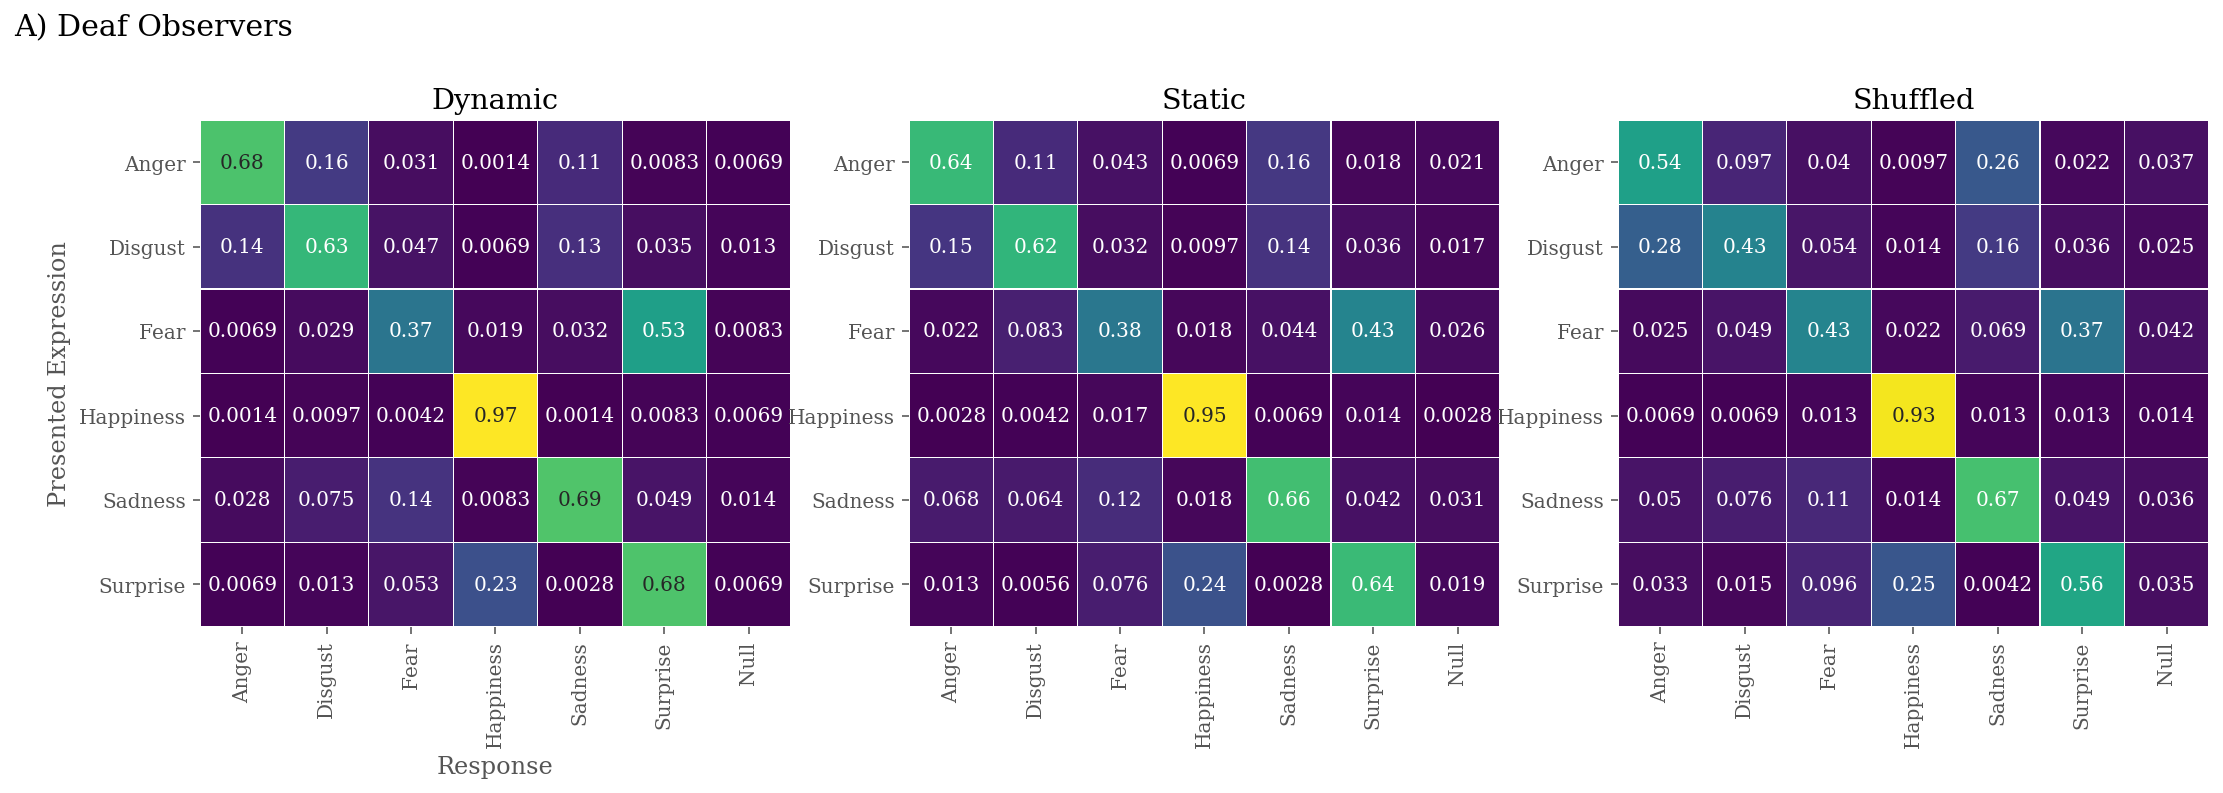

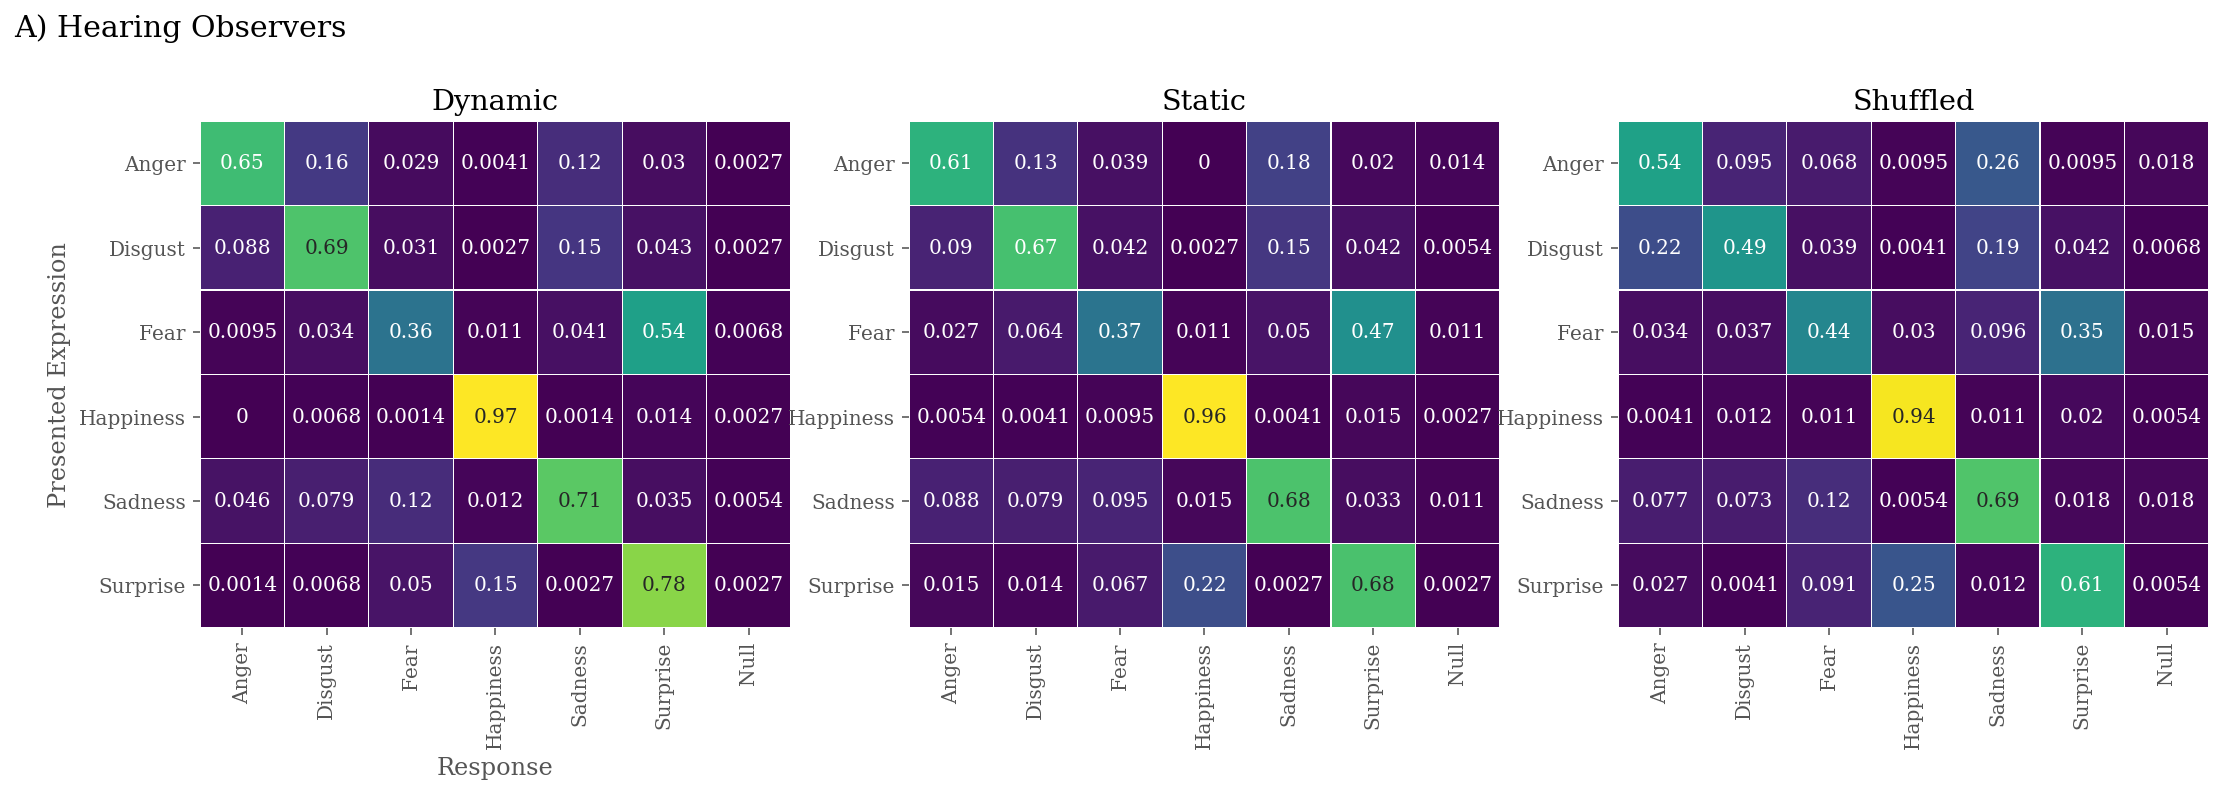

In [16]:
for igroup, tblage in Info_tbl.groupby('group'):
    Conftmp = Conf_mat[tblage.index, :, :, :6]
    Conftrl = Conf_mat[tblage.index, :, :, 6]
    tmp = Conftrl-np.sum(Conftmp, axis=3)
    Conftmp2 = np.concatenate((Conftmp, np.expand_dims(tmp, axis=3)), axis=3)
    trialnum = np.reshape(np.repeat(Conftrl, 7, axis=2),
                          newshape=Conftmp2.shape)
    Confgroup = Conftmp2/trialnum
    if sum(Confgroup > 1) > 0:
        print('Error at '+str(igroup))
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    plt.text(-19, -1, 'A) '+str(igroup) + ' Observers', fontsize=15)
    for ij, itask in enumerate(Tasksel):
        idx = np.where(Taskname == itask)[0][0]
        mattmp = Confgroup[:, idx, :, :]
        meanmat = np.mean(mattmp[np.isfinite(mattmp[:, 0, 0]), :, :], axis=0)
        conf_mean = pd.DataFrame(meanmat, columns=resp_list, index=exp_list)
        sns.heatmap(conf_mean, annot=True, vmin=0, vmax=.95, cbar=False, square=True,
                    linewidths=.1, cmap='viridis', ax=axes[ij])
        axes[ij].set_title(itask)
    axes[0].set_xlabel('Response')
    axes[0].set_ylabel('Presented Expression')

    plt.savefig('figs/ConfMat'+str(igroup)+'.svg', format='svg', dpi=300)

In [17]:
Conftmp = Conf_mat[:, :, :, :6]
# NaN response as ignore
# Conftrl = np.sum(Conftmp,axis=3)
# trialnum = np.reshape(np.repeat(Conftrl,6,axis=2),newshape=Conftmp.shape)
# NaN response as incorrect
trialnum = np.reshape(
    np.repeat(Conf_mat[:, :, :, 6], 6, axis=2), newshape=Conftmp.shape)
Confmean = Conftmp/trialnum

In [18]:
itask = 'Dynamic'
print('Preparing '+str(itask)+' condition')
idx = np.where(Taskname == itask)[0][0]
mattmp = Confmean[:, idx, :, :]
rtmaptmp = RT_mat[:, idx, :]

datatbl1 = pd.DataFrame.copy(Info_tbl)
for ic, emolabel in enumerate(exp_list):
    datatbl1[emolabel] = mattmp[:, ic, ic]
    datatbl1[emolabel+'RT'] = rtmaptmp[:, ic]

Preparing Dynamic condition


In [19]:
itask = 'Static'
print('Preparing '+str(itask)+' condition')
idx = np.where(Taskname == itask)[0][0]
mattmp = Confmean[:, idx, :, :]
rtmaptmp = RT_mat[:, idx, :]

datatbl2 = pd.DataFrame.copy(Info_tbl)
for ic, emolabel in enumerate(exp_list):
    datatbl2[emolabel] = mattmp[:, ic, ic]
    datatbl2[emolabel+'RT'] = rtmaptmp[:, ic]

Preparing Static condition


In [20]:
itask = 'Shuffled'
print('Preparing '+str(itask)+' condition')
idx = np.where(Taskname == itask)[0][0]
mattmp = Confmean[:, idx, :, :]
rtmaptmp = RT_mat[:, idx, :]

datatbl3 = pd.DataFrame.copy(Info_tbl)
for ic, emolabel in enumerate(exp_list):
    datatbl3[emolabel] = mattmp[:, ic, ic]
    datatbl3[emolabel+'RT'] = rtmaptmp[:, ic]

Preparing Shuffled condition


### Mean accuracy by task and group

In [21]:
plt.rcParams.update({'font.size': 15})

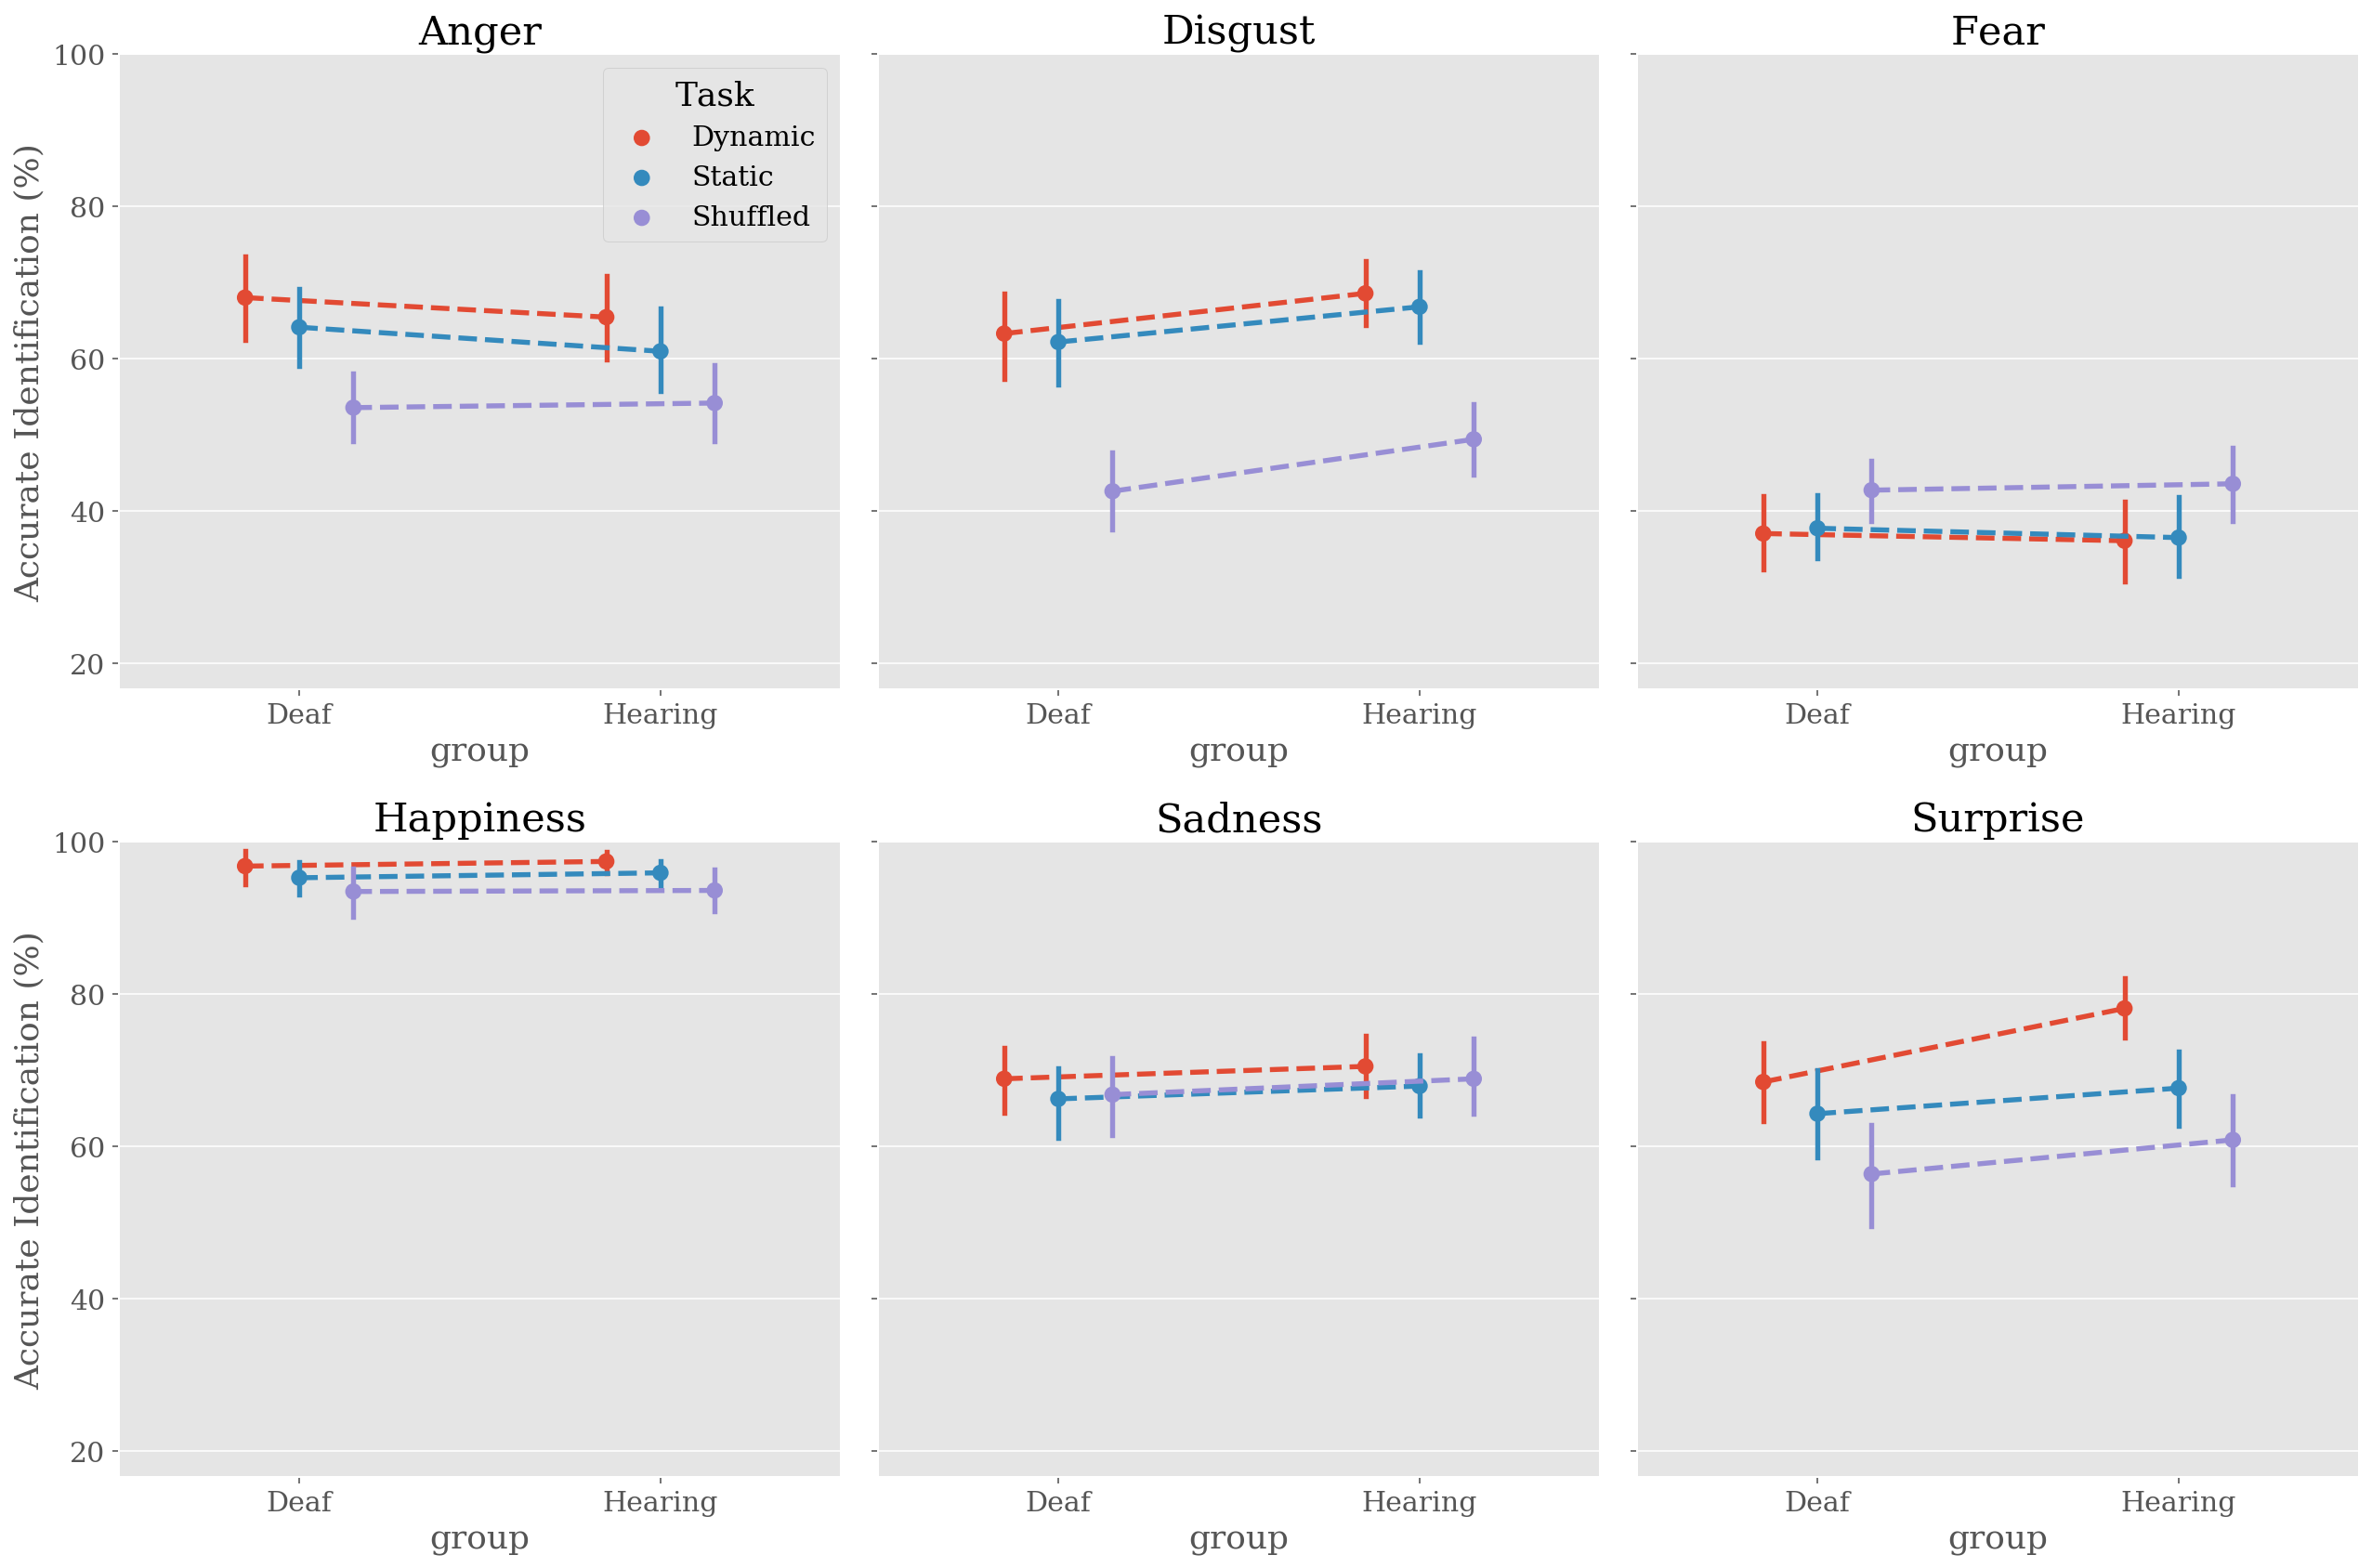

In [22]:
datatbl1['Task'] = 'Dynamic'
datatbl2['Task'] = 'Static'
datatbl3['Task'] = 'Shuffled'
datatbl_123 = pd.concat([datatbl1, datatbl2, datatbl3])

_, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
ax = axes.flatten()
for ic, emolabel in enumerate(exp_list):
    sns.pointplot(x='group', y=emolabel, hue='Task', dodge=.3, linestyles='--',
                  data=datatbl_123, estimator=np.mean, ci=95, n_boot=1000, ax=ax[ic])
    if (ic == 0) | (ic == 3):
        ax[ic].set_ylabel('Accurate Identification (%)')
        ax[ic].set_yticks([.2, .4, .6, .8, 1.])
        ax[ic].set_yticklabels(['20', '40', '60', '80', '100'])
    else:
        ax[ic].set_ylabel('')
    if ic > 0:
        ax[ic].get_legend().remove()
    ax[ic].set_ylim(1/6, 1)
    ax[ic].set_title(emolabel)

plt.tight_layout()
# plt.savefig('./figs/Average_by_group.svg', format='svg', dpi=300)

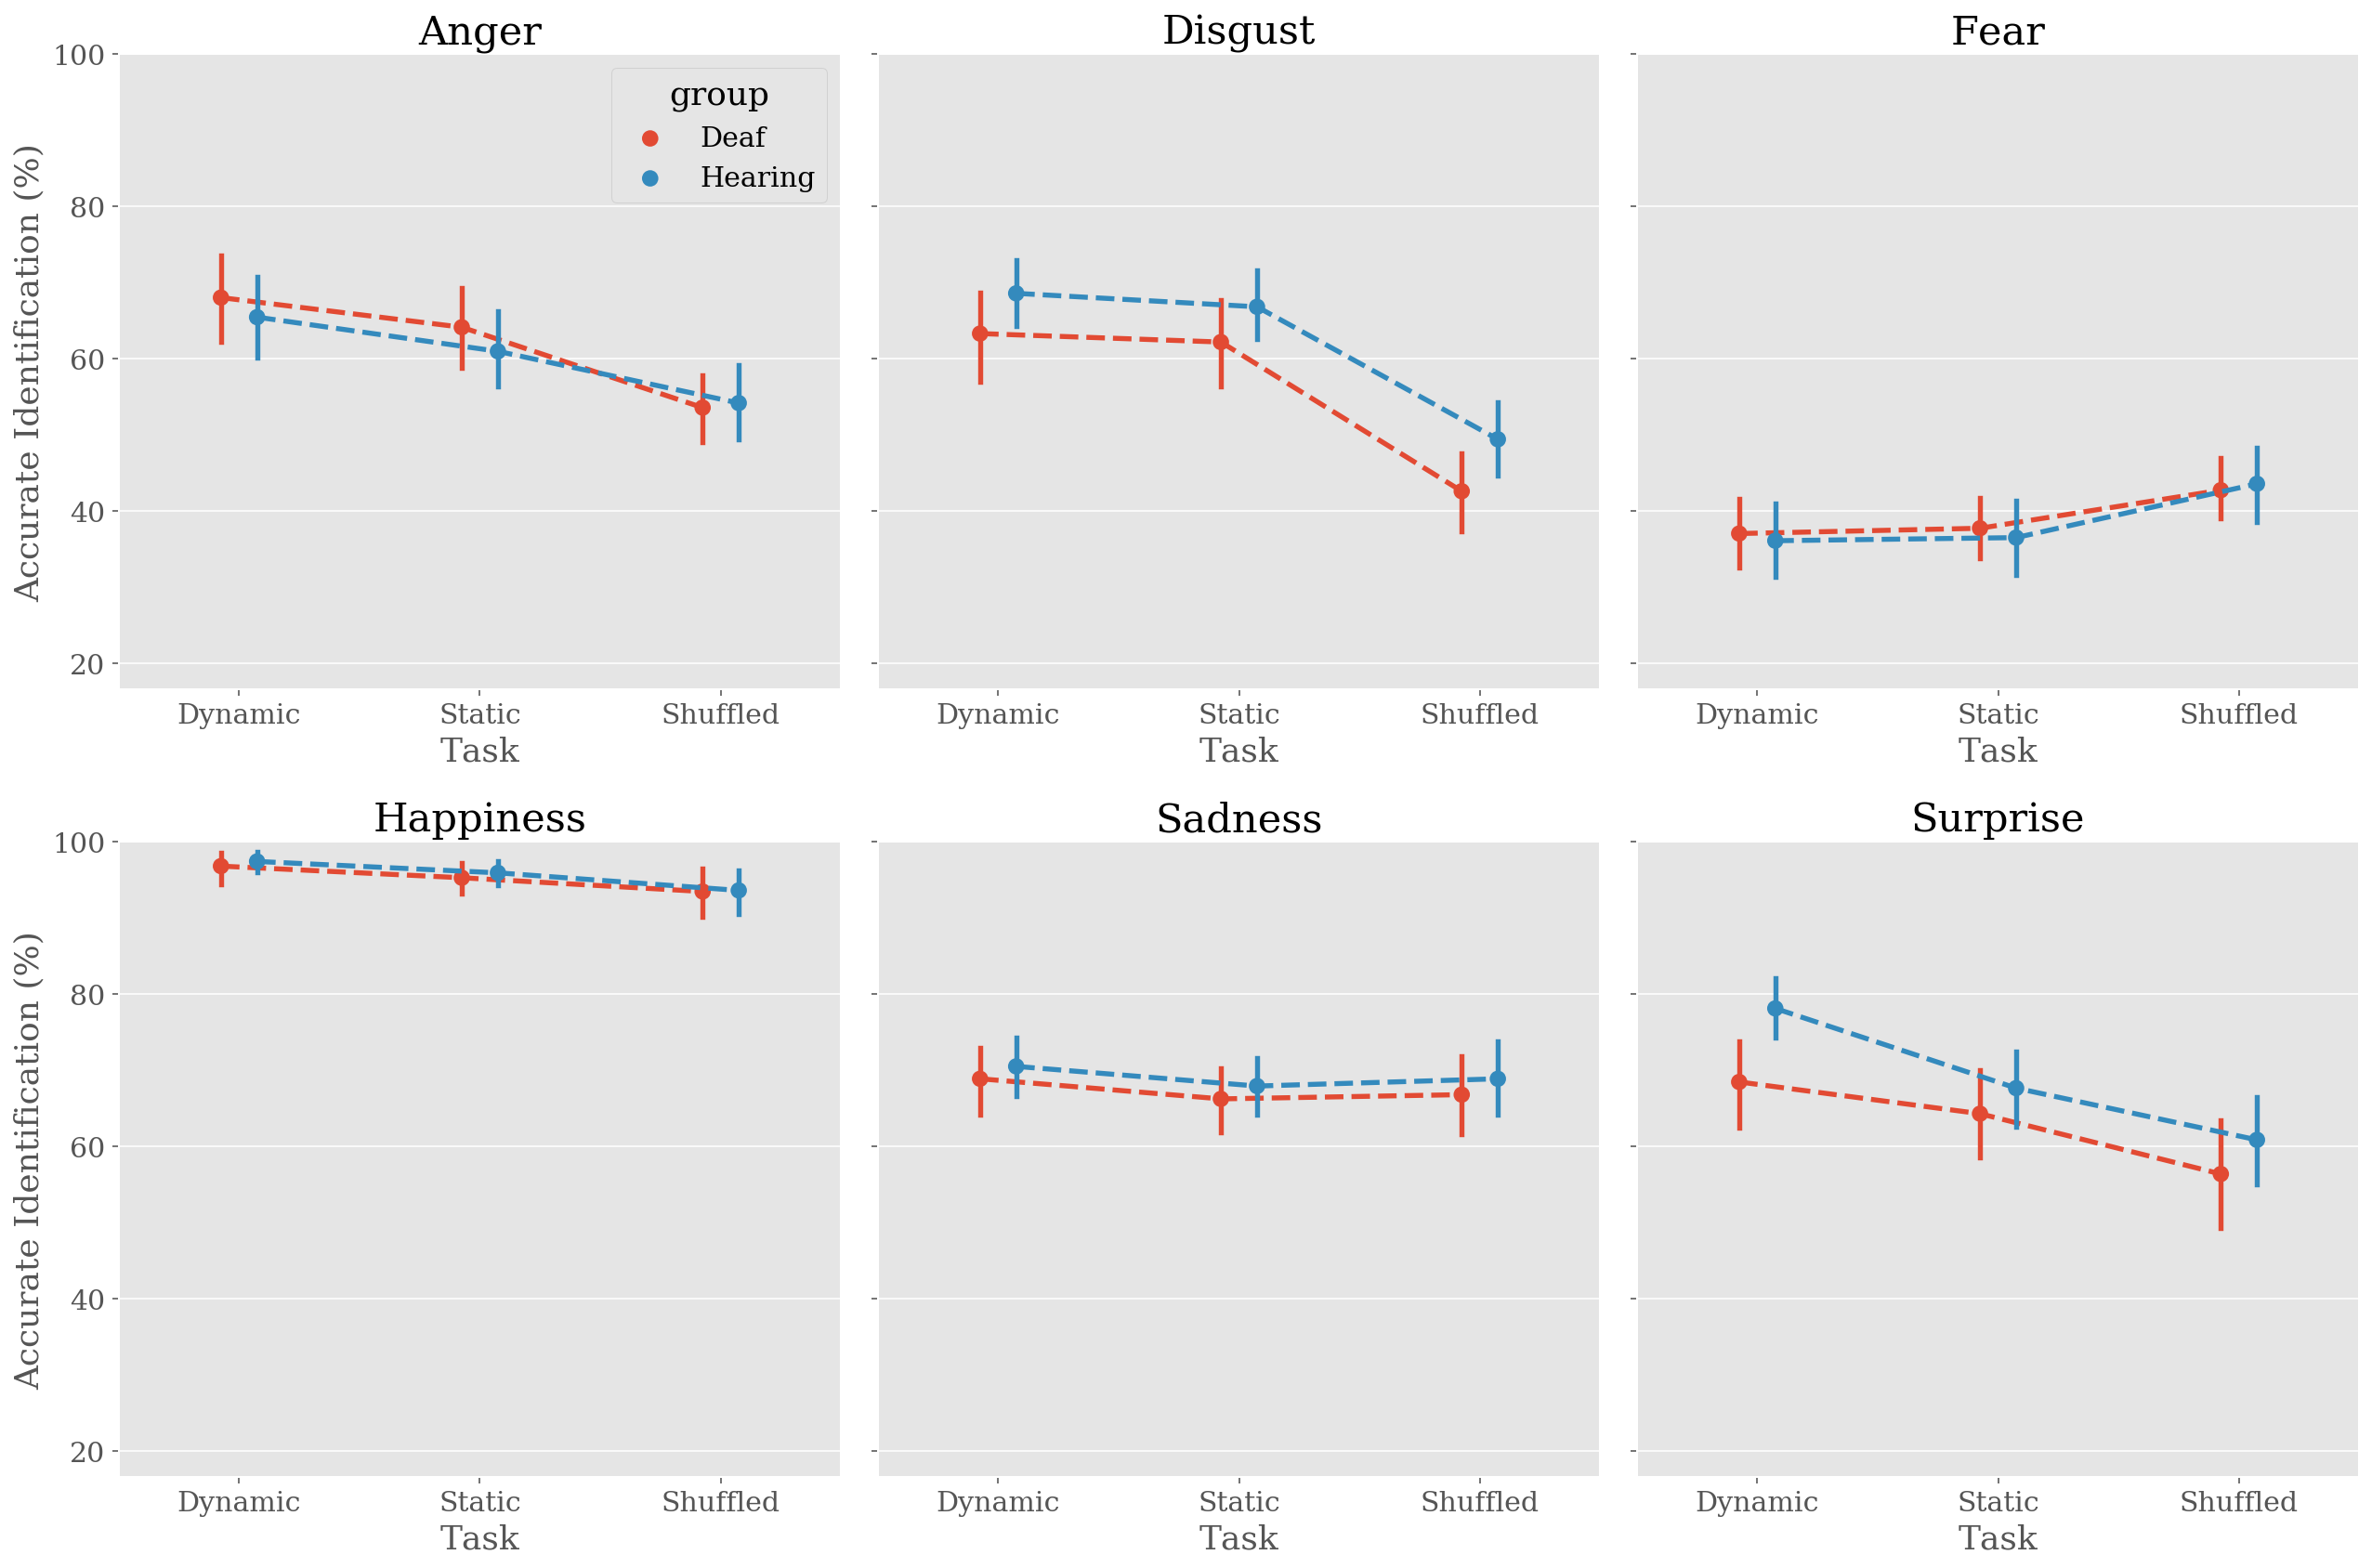

In [23]:
_, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
ax = axes.flatten()
for ic, emolabel in enumerate(exp_list):
    sns.pointplot(x='Task', y=emolabel, hue='group', dodge=.15, linestyles='--',
                  data=datatbl_123, estimator=np.mean, ci=95, n_boot=1000, ax=ax[ic])
    if (ic == 0) | (ic == 3):
        ax[ic].set_ylabel('Accurate Identification (%)')
        ax[ic].set_yticks([.2, .4, .6, .8, 1.])
        ax[ic].set_yticklabels(['20', '40', '60', '80', '100'])
    else:
        ax[ic].set_ylabel('')
    if ic > 0:
        ax[ic].get_legend().remove()
    ax[ic].set_ylim(1/6, 1)
    ax[ic].set_title(emolabel)

plt.tight_layout()
plt.savefig('figs/ACC_identification.svg',
            format='svg', dpi=300)

In [24]:
datatbl_123.groupby(['Task', 'group'])[exp_list].agg('mean').round(3)

Anger  Disgust   Fear  Happiness  Sadness  Surprise
Task     group                                                       
Dynamic  Deaf     0.681    0.633  0.371      0.968    0.689     0.685
         Hearing  0.655    0.686  0.361      0.974    0.705     0.781
Shuffled Deaf     0.536    0.426  0.428      0.935    0.668     0.564
         Hearing  0.542    0.495  0.436      0.936    0.689     0.609
Static   Deaf     0.642    0.622  0.378      0.953    0.662     0.643
         Hearing  0.610    0.668  0.365      0.959    0.679     0.677

In [25]:
bootstrap = sns.algorithms.bootstrap

def btCI_025(x):
    boots = bootstrap(x, func=np.nanmean, n_boot=1000)
    return np.percentile(boots, q=[2.5])[0]

def btCI_975(x):
    boots = bootstrap(x, func=np.nanmean, n_boot=1000)
    return np.percentile(boots, q=[97.5])[0]

In [26]:
for expname in exp_list:
    print(expname)
    display(datatbl_123.groupby(['Task', 'group'])[expname]
     .agg(['mean', 'std', btCI_025, btCI_975])
     .round(3))

Anger


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.681  0.197     0.626     0.733
         Hearing  0.655  0.190     0.599     0.708
Shuffled Deaf     0.536  0.154     0.493     0.582
         Hearing  0.542  0.173     0.490     0.590
Static   Deaf     0.642  0.183     0.592     0.692
         Hearing  0.610  0.185     0.553     0.662

Disgust


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.633  0.194     0.575     0.685
         Hearing  0.686  0.148     0.644     0.727
Shuffled Deaf     0.426  0.184     0.378     0.476
         Hearing  0.495  0.165     0.450     0.539
Static   Deaf     0.622  0.196     0.567     0.674
         Hearing  0.668  0.160     0.622     0.713

Fear


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.371  0.161     0.324     0.419
         Hearing  0.361  0.173     0.317     0.412
Shuffled Deaf     0.428  0.143     0.386     0.469
         Hearing  0.436  0.168     0.391     0.484
Static   Deaf     0.378  0.140     0.339     0.419
         Hearing  0.365  0.170     0.315     0.413

Happiness


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.968  0.073     0.943     0.986
         Hearing  0.974  0.047     0.959     0.986
Shuffled Deaf     0.935  0.110     0.899     0.964
         Hearing  0.936  0.097     0.906     0.962
Static   Deaf     0.953  0.072     0.932     0.972
         Hearing  0.959  0.058     0.942     0.976

Sadness


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.689  0.155     0.644     0.731
         Hearing  0.705  0.137     0.664     0.745
Shuffled Deaf     0.668  0.183     0.612     0.722
         Hearing  0.689  0.175     0.636     0.739
Static   Deaf     0.662  0.153     0.615     0.703
         Hearing  0.679  0.136     0.640     0.719

Surprise


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.685  0.183     0.631     0.732
         Hearing  0.781  0.134     0.745     0.818
Shuffled Deaf     0.564  0.229     0.499     0.626
         Hearing  0.609  0.204     0.552     0.663
Static   Deaf     0.643  0.201     0.586     0.704
         Hearing  0.677  0.171     0.629     0.723

### Mean RT by task and group

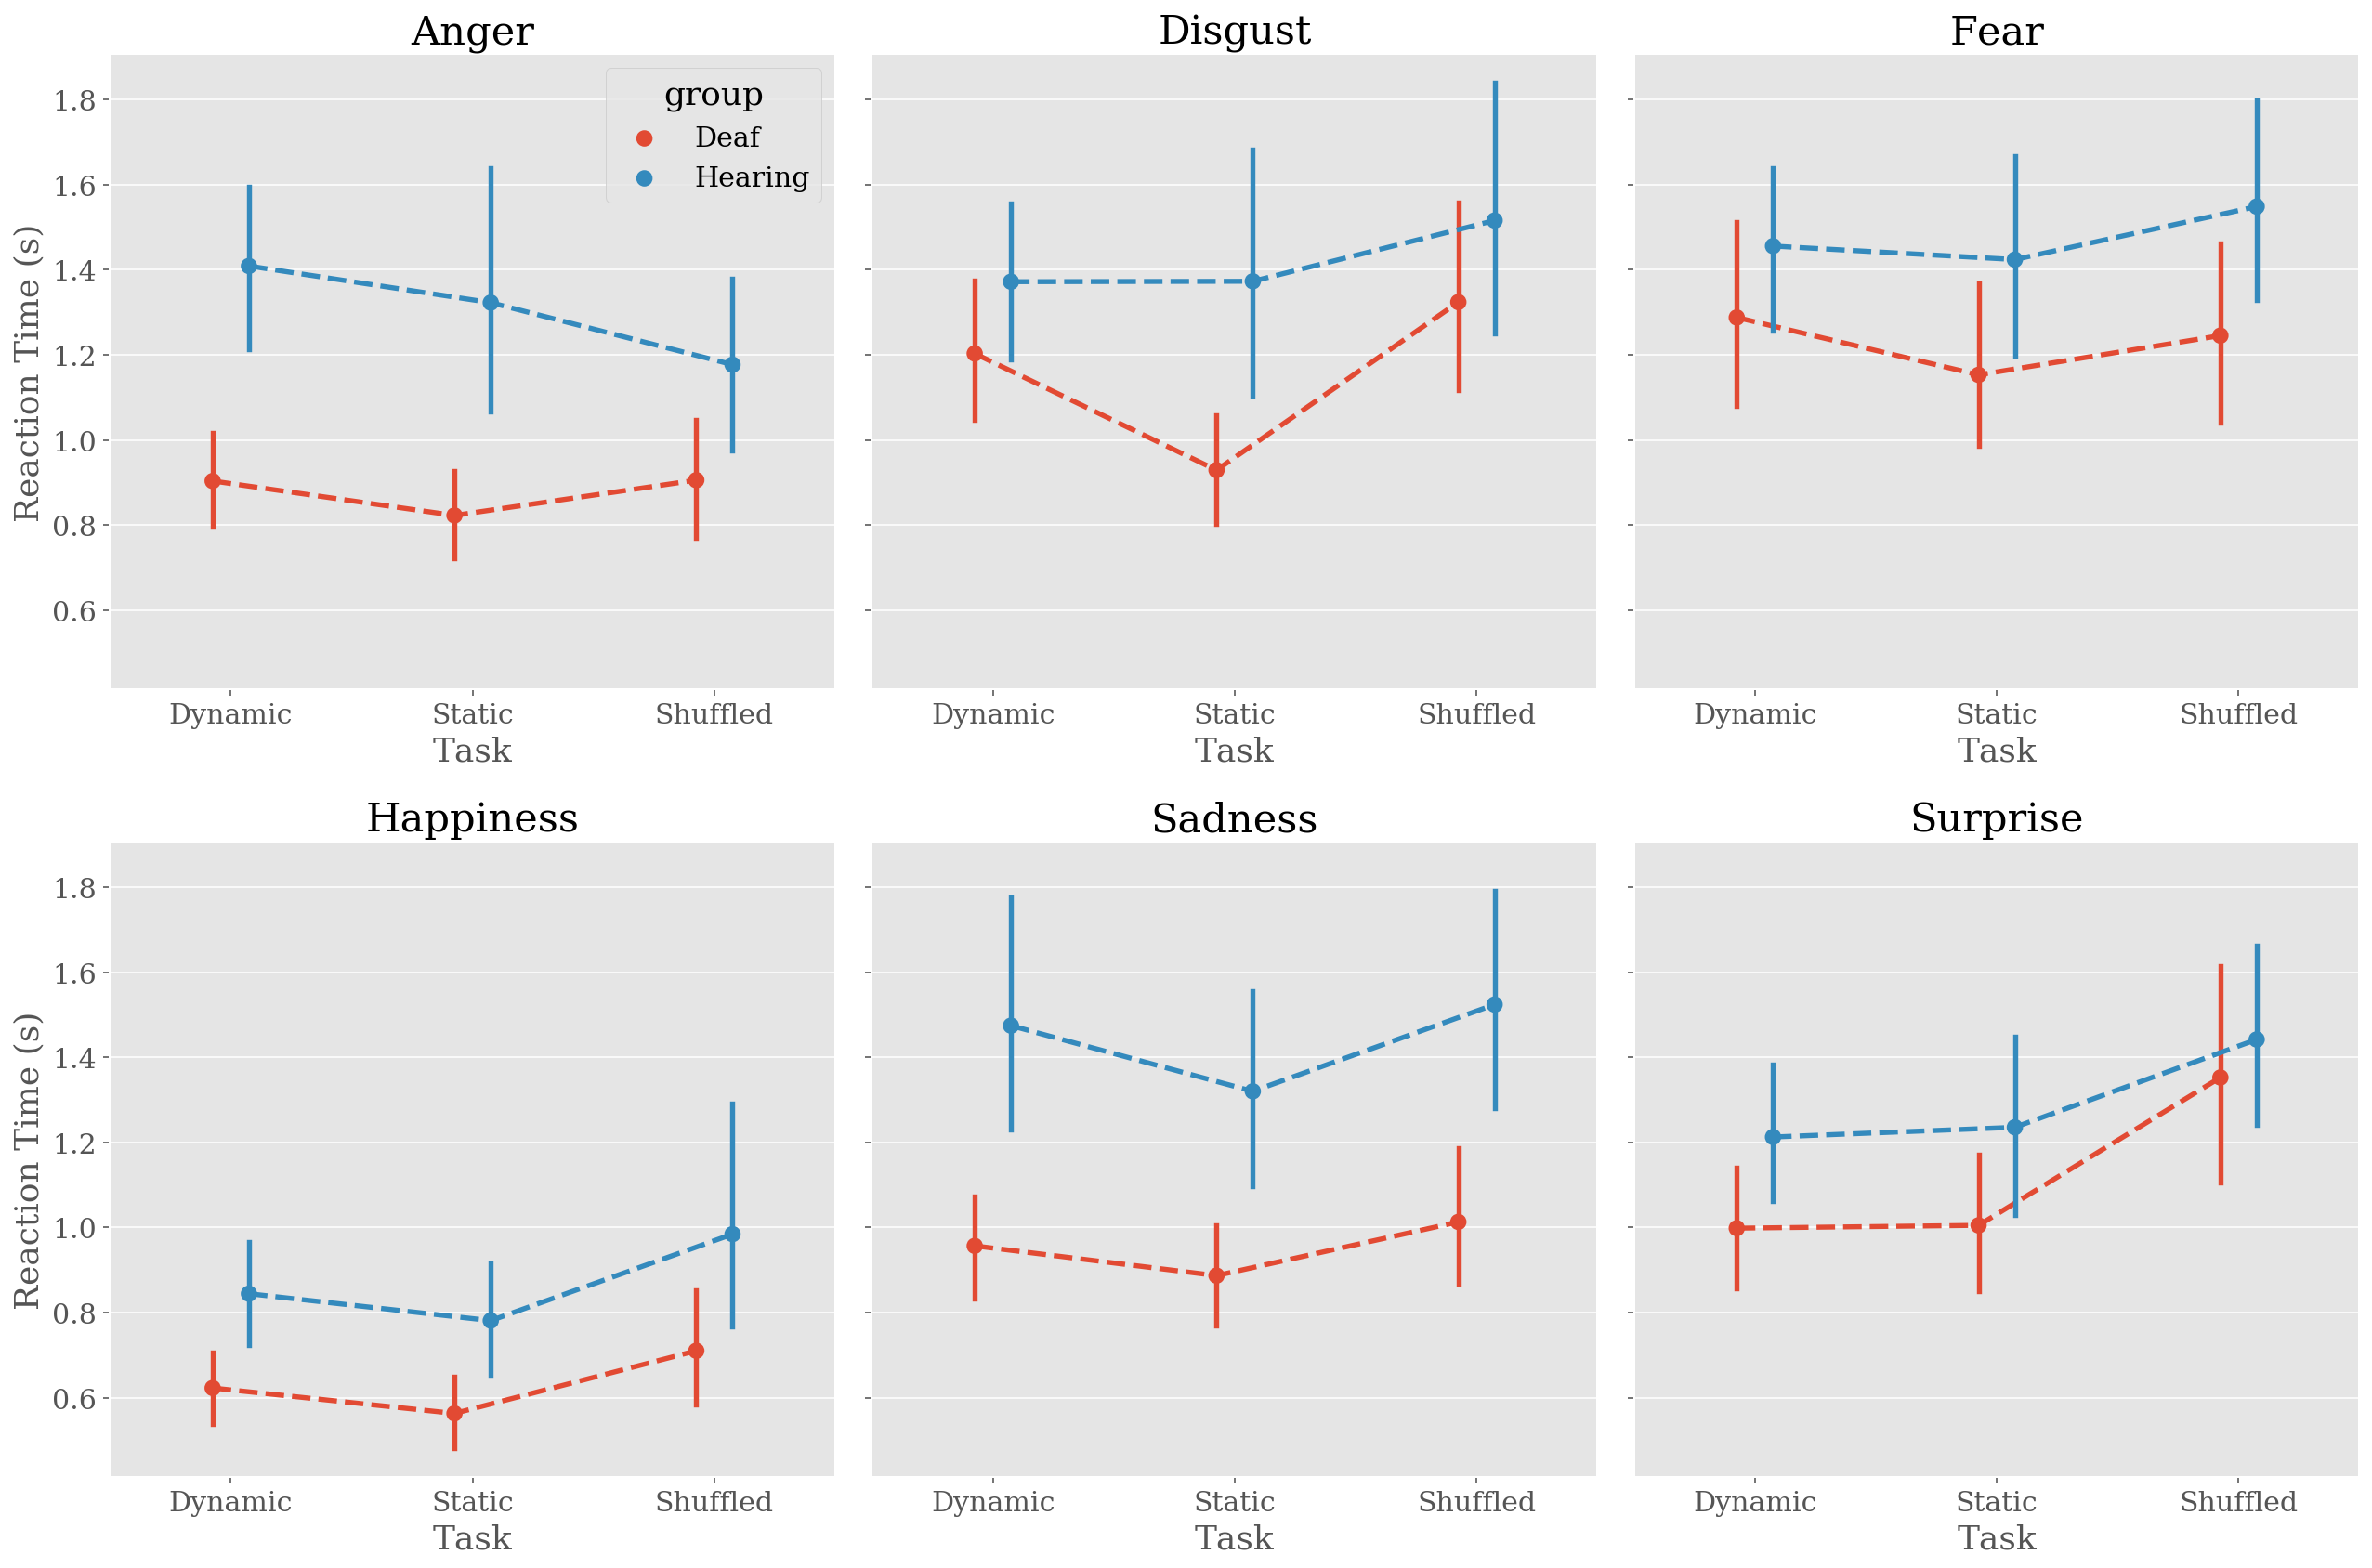

In [27]:
_, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
ax = axes.flatten()
for ic, emolabel in enumerate(exp_list):
    sns.pointplot(x='Task', y=emolabel+'RT', hue='group', dodge=.15, linestyles='--',
                  data=datatbl_123, estimator=np.nanmean, ci=95, n_boot=1000, ax=ax[ic])
    if (ic == 0) | (ic == 3):
        ax[ic].set_ylabel('Reaction Time (s)')
    else:
        ax[ic].set_ylabel('')
    if ic > 0:
        ax[ic].get_legend().remove()
    ax[ic].set_title(emolabel)

plt.tight_layout()

In [28]:
for expname in exp_list:
    print(expname+' RT')
    display(datatbl_123.groupby(['Task', 'group'])[expname+'RT']
     .agg(['mean', 'std', btCI_025, btCI_975])
     .round(3))

Anger RT


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.903  0.371     0.802     1.010
         Hearing  1.409  0.659     1.224     1.601
Shuffled Deaf     0.905  0.494     0.769     1.051
         Hearing  1.177  0.721     0.982     1.391
Static   Deaf     0.822  0.360     0.723     0.930
         Hearing  1.322  1.033     1.037     1.624

Disgust RT


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     1.203  0.569     1.044     1.371
         Hearing  1.372  0.653     1.196     1.565
Shuffled Deaf     1.324  0.758     1.108     1.538
         Hearing  1.516  0.995     1.231     1.796
Static   Deaf     0.929  0.438     0.810     1.070
         Hearing  1.373  1.028     1.095     1.654

Fear RT


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     1.288  0.752     1.079     1.493
         Hearing  1.456  0.689     1.272     1.654
Shuffled Deaf     1.245  0.732     1.056     1.458
         Hearing  1.548  0.826     1.321     1.786
Static   Deaf     1.153  0.663     0.968     1.353
         Hearing  1.424  0.875     1.197     1.694

Happiness RT


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.623  0.293     0.543     0.706
         Hearing  0.844  0.433     0.731     0.957
Shuffled Deaf     0.710  0.499     0.578     0.860
         Hearing  0.984  0.871     0.774     1.271
Static   Deaf     0.563  0.282     0.482     0.642
         Hearing  0.781  0.448     0.655     0.914

Sadness RT


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.957  0.410     0.846     1.073
         Hearing  1.474  1.012     1.199     1.801
Shuffled Deaf     1.013  0.560     0.861     1.172
         Hearing  1.524  0.881     1.266     1.751
Static   Deaf     0.887  0.414     0.770     1.009
         Hearing  1.320  0.812     1.093     1.547

Surprise RT


mean    std  btCI_025  btCI_975
Task     group                                    
Dynamic  Deaf     0.998  0.510     0.857     1.162
         Hearing  1.212  0.565     1.059     1.377
Shuffled Deaf     1.352  0.908     1.104     1.611
         Hearing  1.442  0.752     1.229     1.641
Static   Deaf     1.005  0.549     0.852     1.162
         Hearing  1.235  0.748     1.030     1.460

### Softmax function

In [29]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

ntrial, npredi, nitem = 10, 3, 4
X = np.random.randn(ntrial, npredi)
beta = np.random.randn(npredi, nitem)
yhat = np.matmul(X, beta)

print(softmax(yhat))
print('\n')
print(tt.nnet.softmax(yhat).eval())

[[7.88131681e-02 5.51154702e-01 1.05225394e-01 2.64806736e-01]
 [2.46788096e-03 2.69388959e-02 9.66625544e-01 3.96767917e-03]
 [1.47539860e-01 3.83487328e-01 1.27125697e-01 3.41847115e-01]
 [4.55377539e-01 1.37161940e-01 1.78596526e-02 3.89600869e-01]
 [3.76503414e-01 3.21655946e-02 5.01352687e-01 8.99783045e-02]
 [1.42966484e-03 9.25306921e-01 5.14800981e-03 6.81154047e-02]
 [8.45762281e-01 3.36825476e-03 1.17393332e-01 3.34761329e-02]
 [1.71632323e-04 9.59284862e-01 3.59715384e-04 4.01837906e-02]
 [3.50128965e-01 1.88555687e-01 1.91008798e-02 4.42214468e-01]
 [7.83123436e-04 9.35042387e-01 7.12018198e-04 6.34624714e-02]]


[[7.88131681e-02 5.51154702e-01 1.05225394e-01 2.64806736e-01]
 [2.46788096e-03 2.69388959e-02 9.66625544e-01 3.96767917e-03]
 [1.47539860e-01 3.83487328e-01 1.27125697e-01 3.41847115e-01]
 [4.55377539e-01 1.37161940e-01 1.78596526e-02 3.89600869e-01]
 [3.76503414e-01 3.21655946e-02 5.01352687e-01 8.99783045e-02]
 [1.42966484e-03 9.25306921e-01 5.14800981e-03 6.811

In [30]:
Conf_mat[1]

array([[[13.,  0.,  2.,  0.,  1.,  0., 16.],
        [ 3.,  9.,  2.,  0.,  1.,  1., 16.],
        [ 0.,  0.,  7.,  0.,  0.,  9., 16.],
        [ 0.,  0.,  0., 16.,  0.,  0., 16.],
        [ 0.,  0.,  4.,  2., 10.,  0., 16.],
        [ 0.,  0.,  0.,  4.,  0., 12., 16.]],

       [[10.,  3.,  0.,  0.,  3.,  0., 16.],
        [ 5.,  7.,  1.,  0.,  2.,  1., 16.],
        [ 0.,  0.,  9.,  1.,  1.,  5., 16.],
        [ 0.,  0.,  0., 16.,  0.,  0., 16.],
        [ 0.,  1.,  1.,  0., 13.,  1., 16.],
        [ 0.,  0.,  1.,  5.,  0., 10., 16.]],

       [[11.,  2.,  2.,  0.,  1.,  0., 16.],
        [ 0., 12.,  1.,  1.,  2.,  0., 16.],
        [ 0.,  0.,  7.,  0.,  1.,  8., 16.],
        [ 0.,  0.,  0., 16.,  0.,  0., 16.],
        [ 0.,  1.,  2.,  0., 13.,  0., 16.],
        [ 0.,  0.,  2.,  5.,  0.,  9., 16.]]])

In [31]:
Conf_mat.reshape(-1, 7)[18:36]

array([[13.,  0.,  2.,  0.,  1.,  0., 16.],
       [ 3.,  9.,  2.,  0.,  1.,  1., 16.],
       [ 0.,  0.,  7.,  0.,  0.,  9., 16.],
       [ 0.,  0.,  0., 16.,  0.,  0., 16.],
       [ 0.,  0.,  4.,  2., 10.,  0., 16.],
       [ 0.,  0.,  0.,  4.,  0., 12., 16.],
       [10.,  3.,  0.,  0.,  3.,  0., 16.],
       [ 5.,  7.,  1.,  0.,  2.,  1., 16.],
       [ 0.,  0.,  9.,  1.,  1.,  5., 16.],
       [ 0.,  0.,  0., 16.,  0.,  0., 16.],
       [ 0.,  1.,  1.,  0., 13.,  1., 16.],
       [ 0.,  0.,  1.,  5.,  0., 10., 16.],
       [11.,  2.,  2.,  0.,  1.,  0., 16.],
       [ 0., 12.,  1.,  1.,  2.,  0., 16.],
       [ 0.,  0.,  7.,  0.,  1.,  8., 16.],
       [ 0.,  0.,  0., 16.,  0.,  0., 16.],
       [ 0.,  1.,  2.,  0., 13.,  0., 16.],
       [ 0.,  0.,  2.,  5.,  0.,  9., 16.]])

In [32]:
dataval = Conf_mat.reshape(-1, 7)
ntrial = dataval[:,-1]
dataval = np.hstack((dataval[:,:6], (dataval[:,-1]-dataval[:,:6].sum(axis=1))[:,None]))

In [33]:
# individual annotator confusion matrices - dominant diagonal
K=6
beta = np.ones( (K,K+1) )
beta[np.diag_indices(K)]+=1
beta

array([[2., 1., 1., 1., 1., 1., 1.],
       [1., 2., 1., 1., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1., 1.],
       [1., 1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 1., 2., 1.]])

In [34]:
prior = np.tile(beta, (Conf_mat.shape[0]*Conf_mat.shape[1], 1))

### Helper functions

In [35]:
groupid = Info_tbl['group_id'].values-1

Conf_mat2 = Conf_mat[:, :, :, :6]/(Conf_mat[:, :, :, -1][:, :, :, None])
grpmean = []
for ig in range(2):
    grpmean.append(Conf_mat2[groupid == ig, :, :, :].mean(axis=0))
grpmean = np.asarray(grpmean)
grpmean.shape

(2, 3, 6, 6)

In [36]:
def CONVERGENCE_TITLE(bfmi, max_gr, min_effn): 
    return f'BFMI = {bfmi} \nmax(R_hat) = {max_gr.data} min(Eff_n) = {min_effn.data}'


def get_diags(trace):
    bfmi = pm.bfmi(trace)
    max_gr = max(np.max(gr_stats)
                 for gr_stats in pm.rhat(trace).values())
    min_effn = min(np.min(ef_stats)
                   for ef_stats in pm.ess(trace).values())
    return bfmi, max_gr, min_effn

In [37]:
def plotgroup_p(postp, itask):
    print('Displaying task ' + Taskname[itask])
    colorlist = ['C0', 'C1']
    _,  ax = plt.subplots(6, 6, figsize=(18, 9), sharex=True)
    for ij, replabel in enumerate(resp_list[:6]):
        for ii, explabel in enumerate(exp_list):
            if ii == 0:
                ax[ii, ij].set_title(replabel)
            if ij == 0:
                ax[ii, ij].set_ylabel(explabel)
            for ig, grpname in enumerate(grplist):
                gvec = postp[:, ig, itask, ii, ij]
                sns.distplot(gvec, kde=True, ax=ax[ii, ij], label=grpname)
                if ii == ij:
                    ax[ii, ij].axvline(
                        grpmean[ig, itask, ii, ij], color=colorlist[ig])
    plt.legend()
    plt.tight_layout()

In [38]:
def post_dync_adv(postp):
    print('Displaying dynamic advantage [Dynamic minus Static]')

    _,  ax = plt.subplots(6, 6, figsize=(18, 9), sharex=True)
    for ij, replabel in enumerate(resp_list[:6]):
        for ii, explabel in enumerate(exp_list):
            if ii == 0:
                ax[ii, ij].set_title(replabel)
            if ij == 0:
                ax[ii, ij].set_ylabel(explabel)
            for ig, grpname in enumerate(grplist):
                gvec = postp[:, ig, 0, ii, ij] - postp[:, ig, 2, ii, ij]
                sns.distplot(gvec, kde=True, ax=ax[ii, ij], label=grpname)
            ax[ii, ij].axvline(0, color='k')
    plt.legend()
    plt.tight_layout()

In [39]:
plt.rcParams.update({'font.size': 10})

# Model testings

In [40]:
with pm.Model() as model0:
    theta = pm.Dirichlet('theta', a=prior, shape=prior.shape)
    obs = pm.Multinomial('obs', n=ntrial, p=theta, observed=dataval)
    trace0 = pm.sample(1000, tune=2000)

/home/junpenglao/anaconda3/lib/python3.7/site-packages/Theano-1.0.4-py3.7.egg/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [17:19<00:00,  8.67draws/s]  
The acceptance probability does not match the target. It is 0.6404483425435961, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6414885555329001, but should be close to 0.8. Try to increase the number of tuning steps.


BFMI = [0.90885799 0.98672085] 
max(R_hat) = 1.0136029366651678 min(Eff_n) = 1218.2230661278973


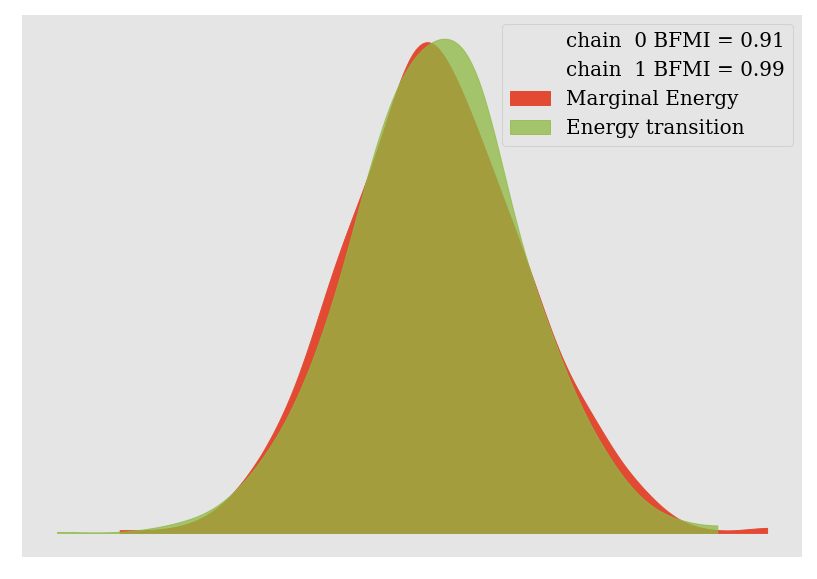

In [41]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

bfmi, max_gr, min_effn = get_diags(trace0)
pm.energyplot(trace0, ax=ax);
print(CONVERGENCE_TITLE(bfmi, max_gr, min_effn))

In [42]:
trace0['theta'].shape

(2000, 1638, 7)

In [43]:
posterior_p = trace0['theta'].reshape((2000,)+Conf_mat.shape)
posterior_p.shape

(2000, 91, 3, 6, 7)

In [44]:
postp = []
for ig in range(len(np.unique(groupid))):
    postp.append(posterior_p[:, groupid == ig, :, :, :].mean(axis=1))
postp = np.swapaxes(np.asarray(postp), 0, 1)
postp.shape

(2000, 2, 3, 6, 7)

Displaying task Dynamic


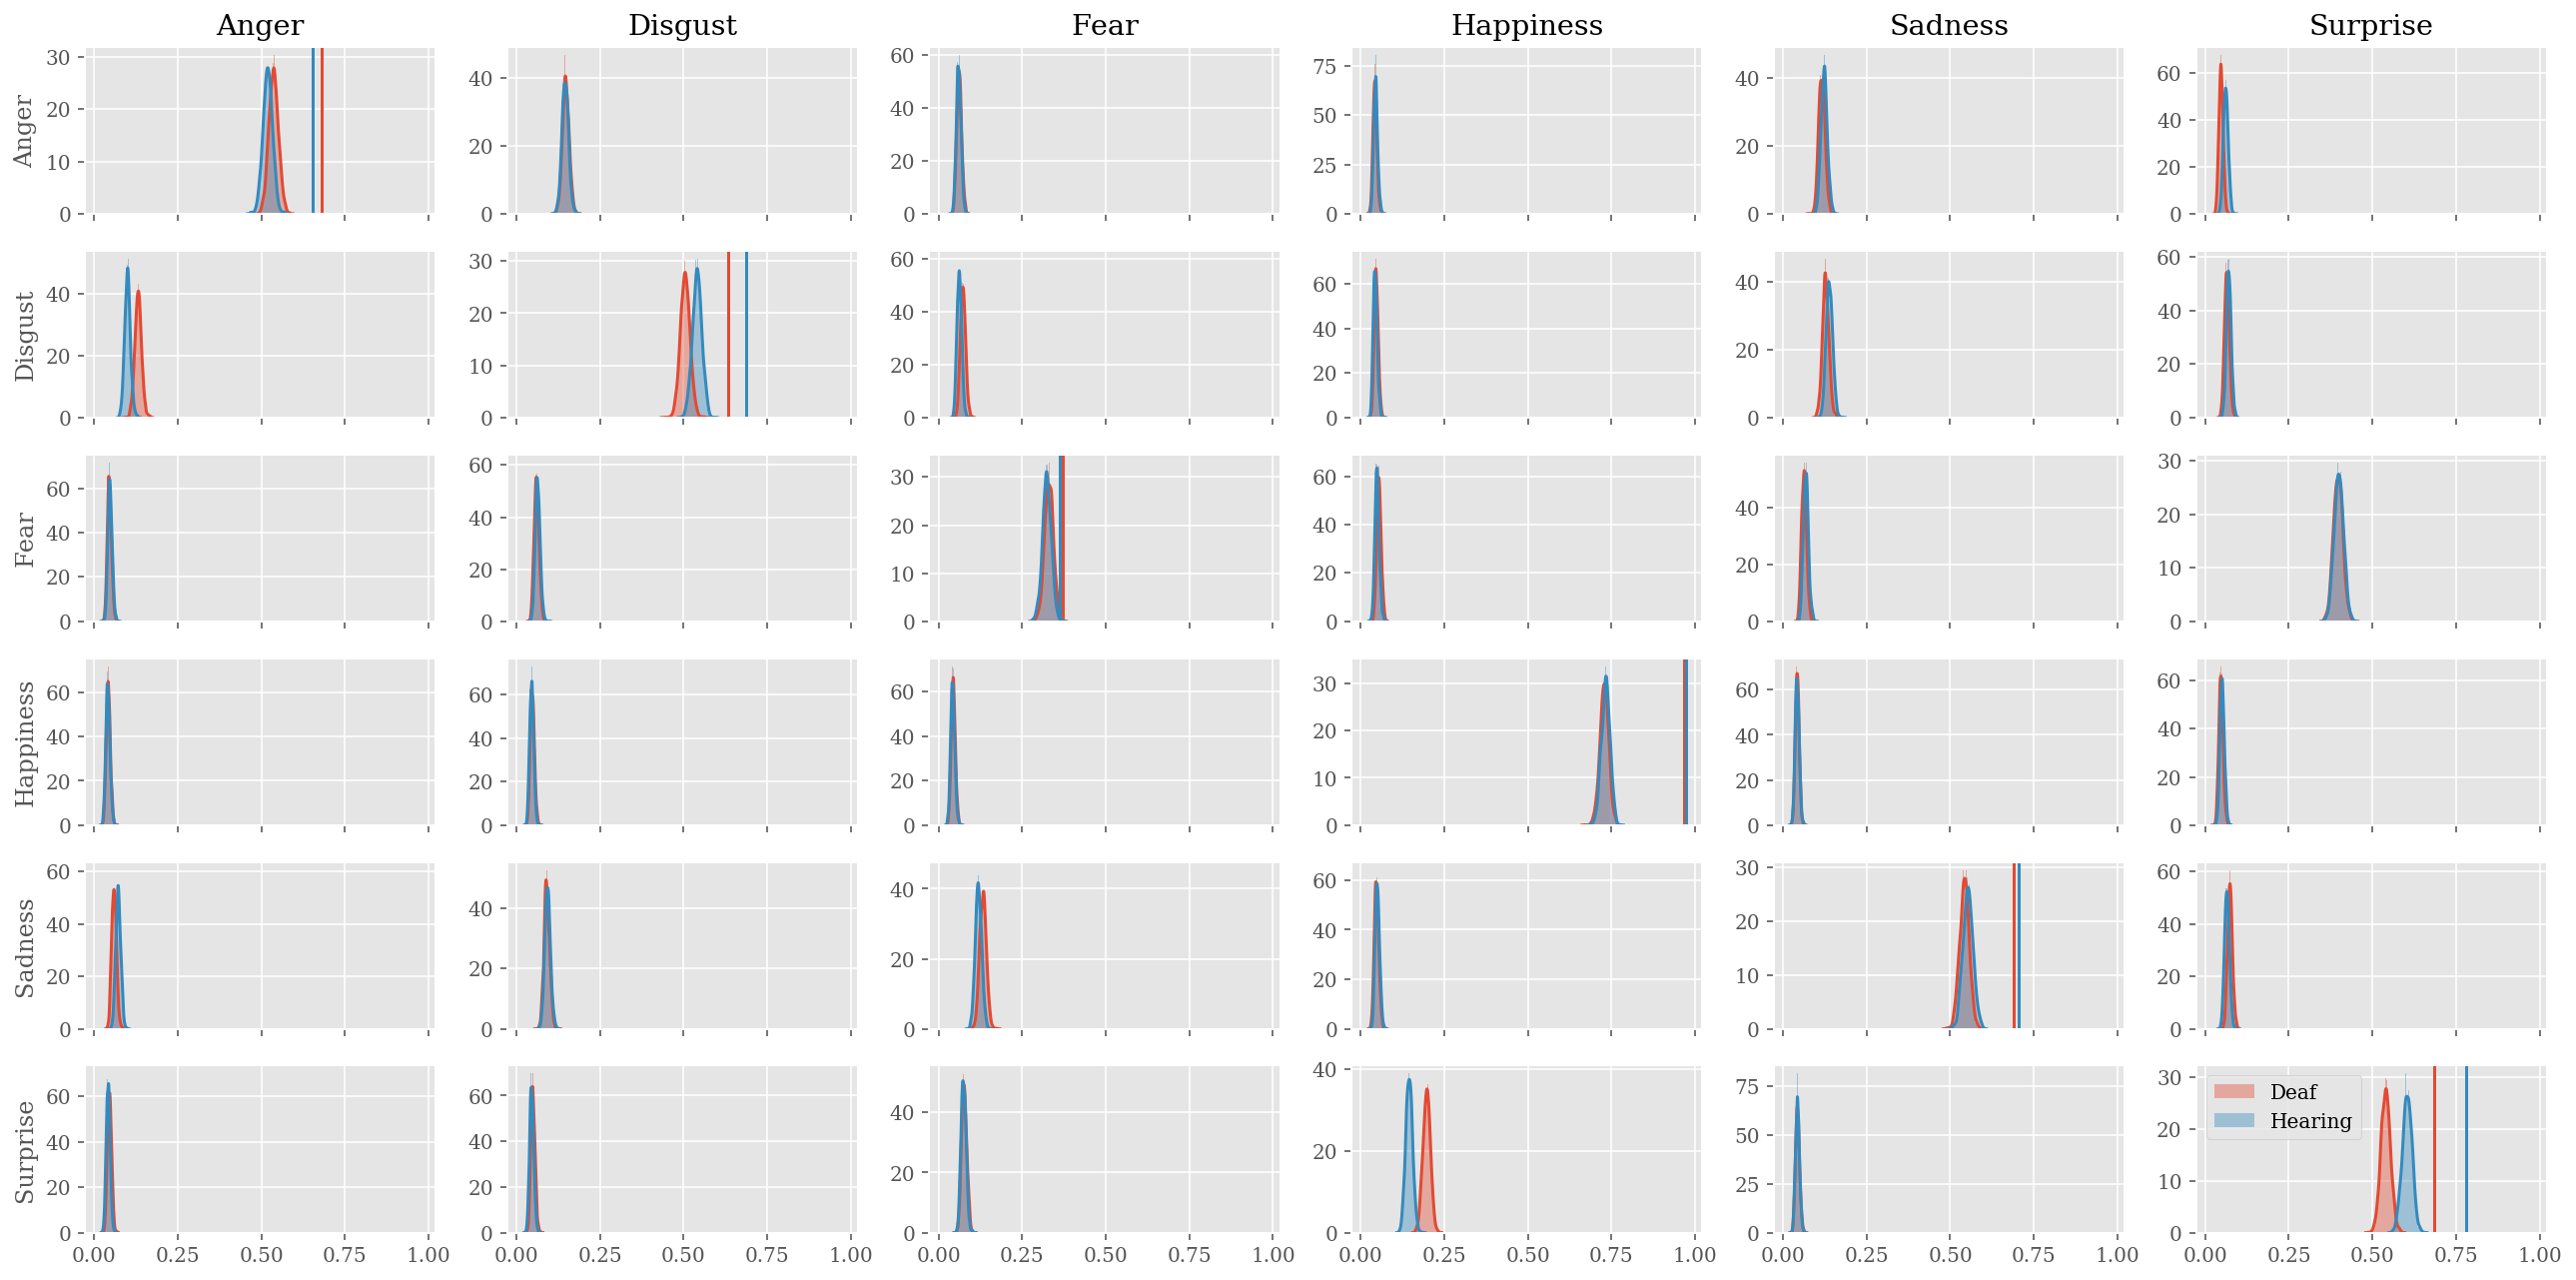

In [45]:
plotgroup_p(postp, 0)

Displaying task Static


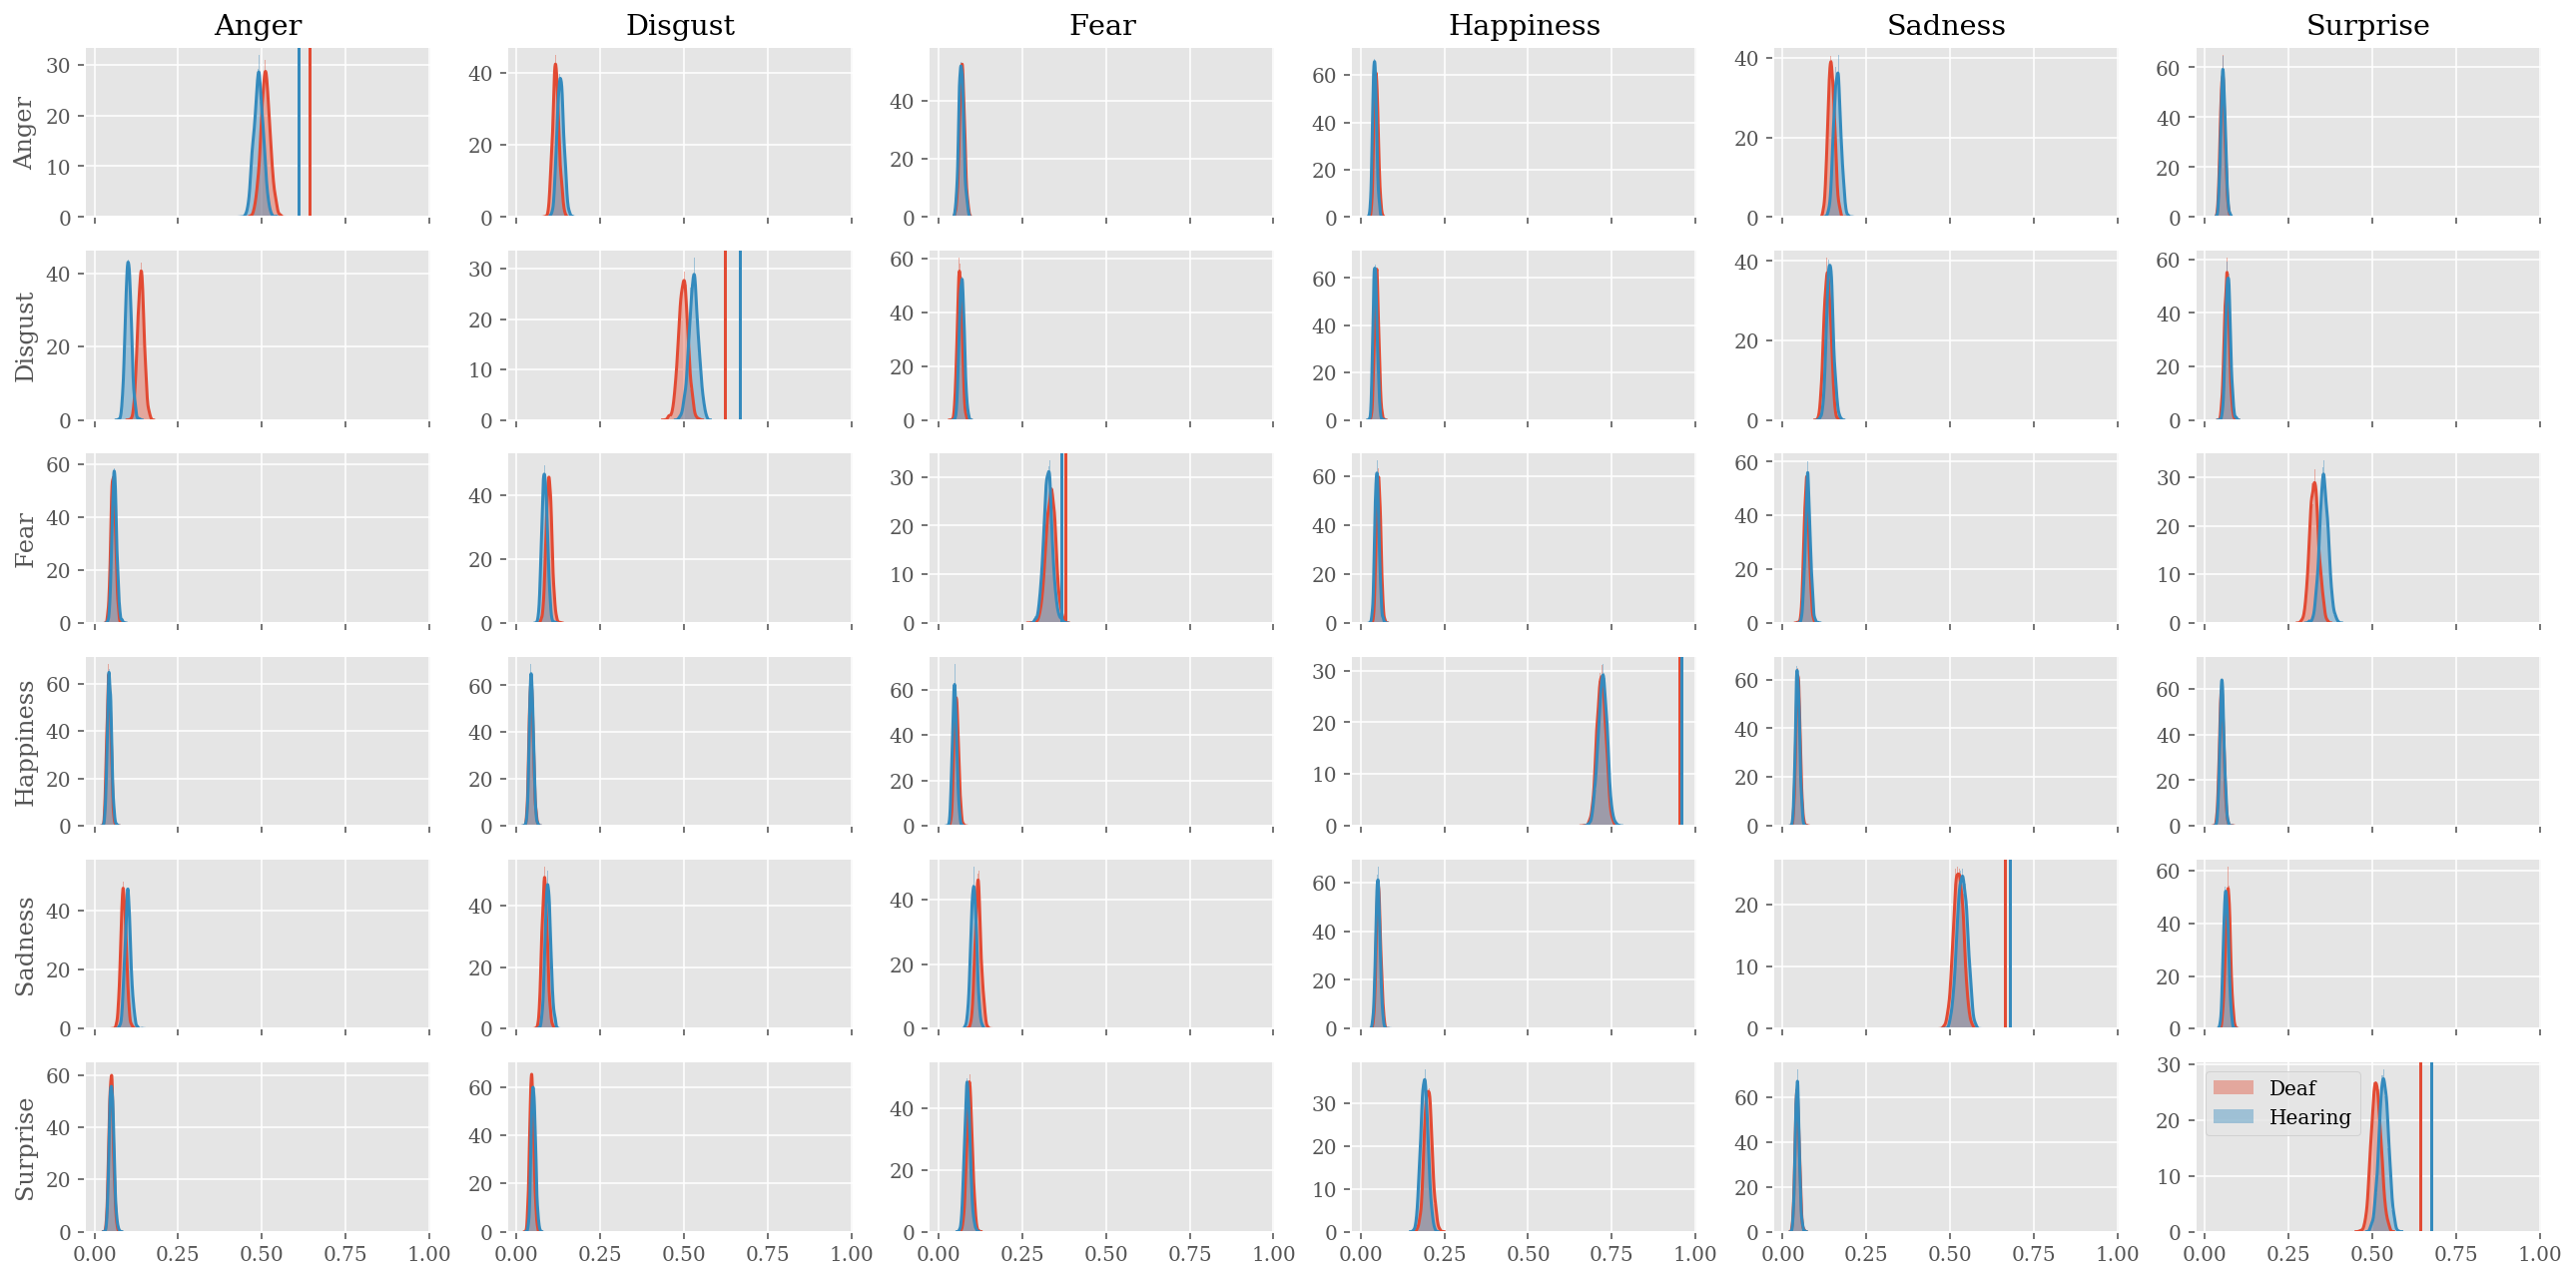

In [46]:
plotgroup_p(postp, 2)

Displaying dynamic advantage [Dynamic minus Static]


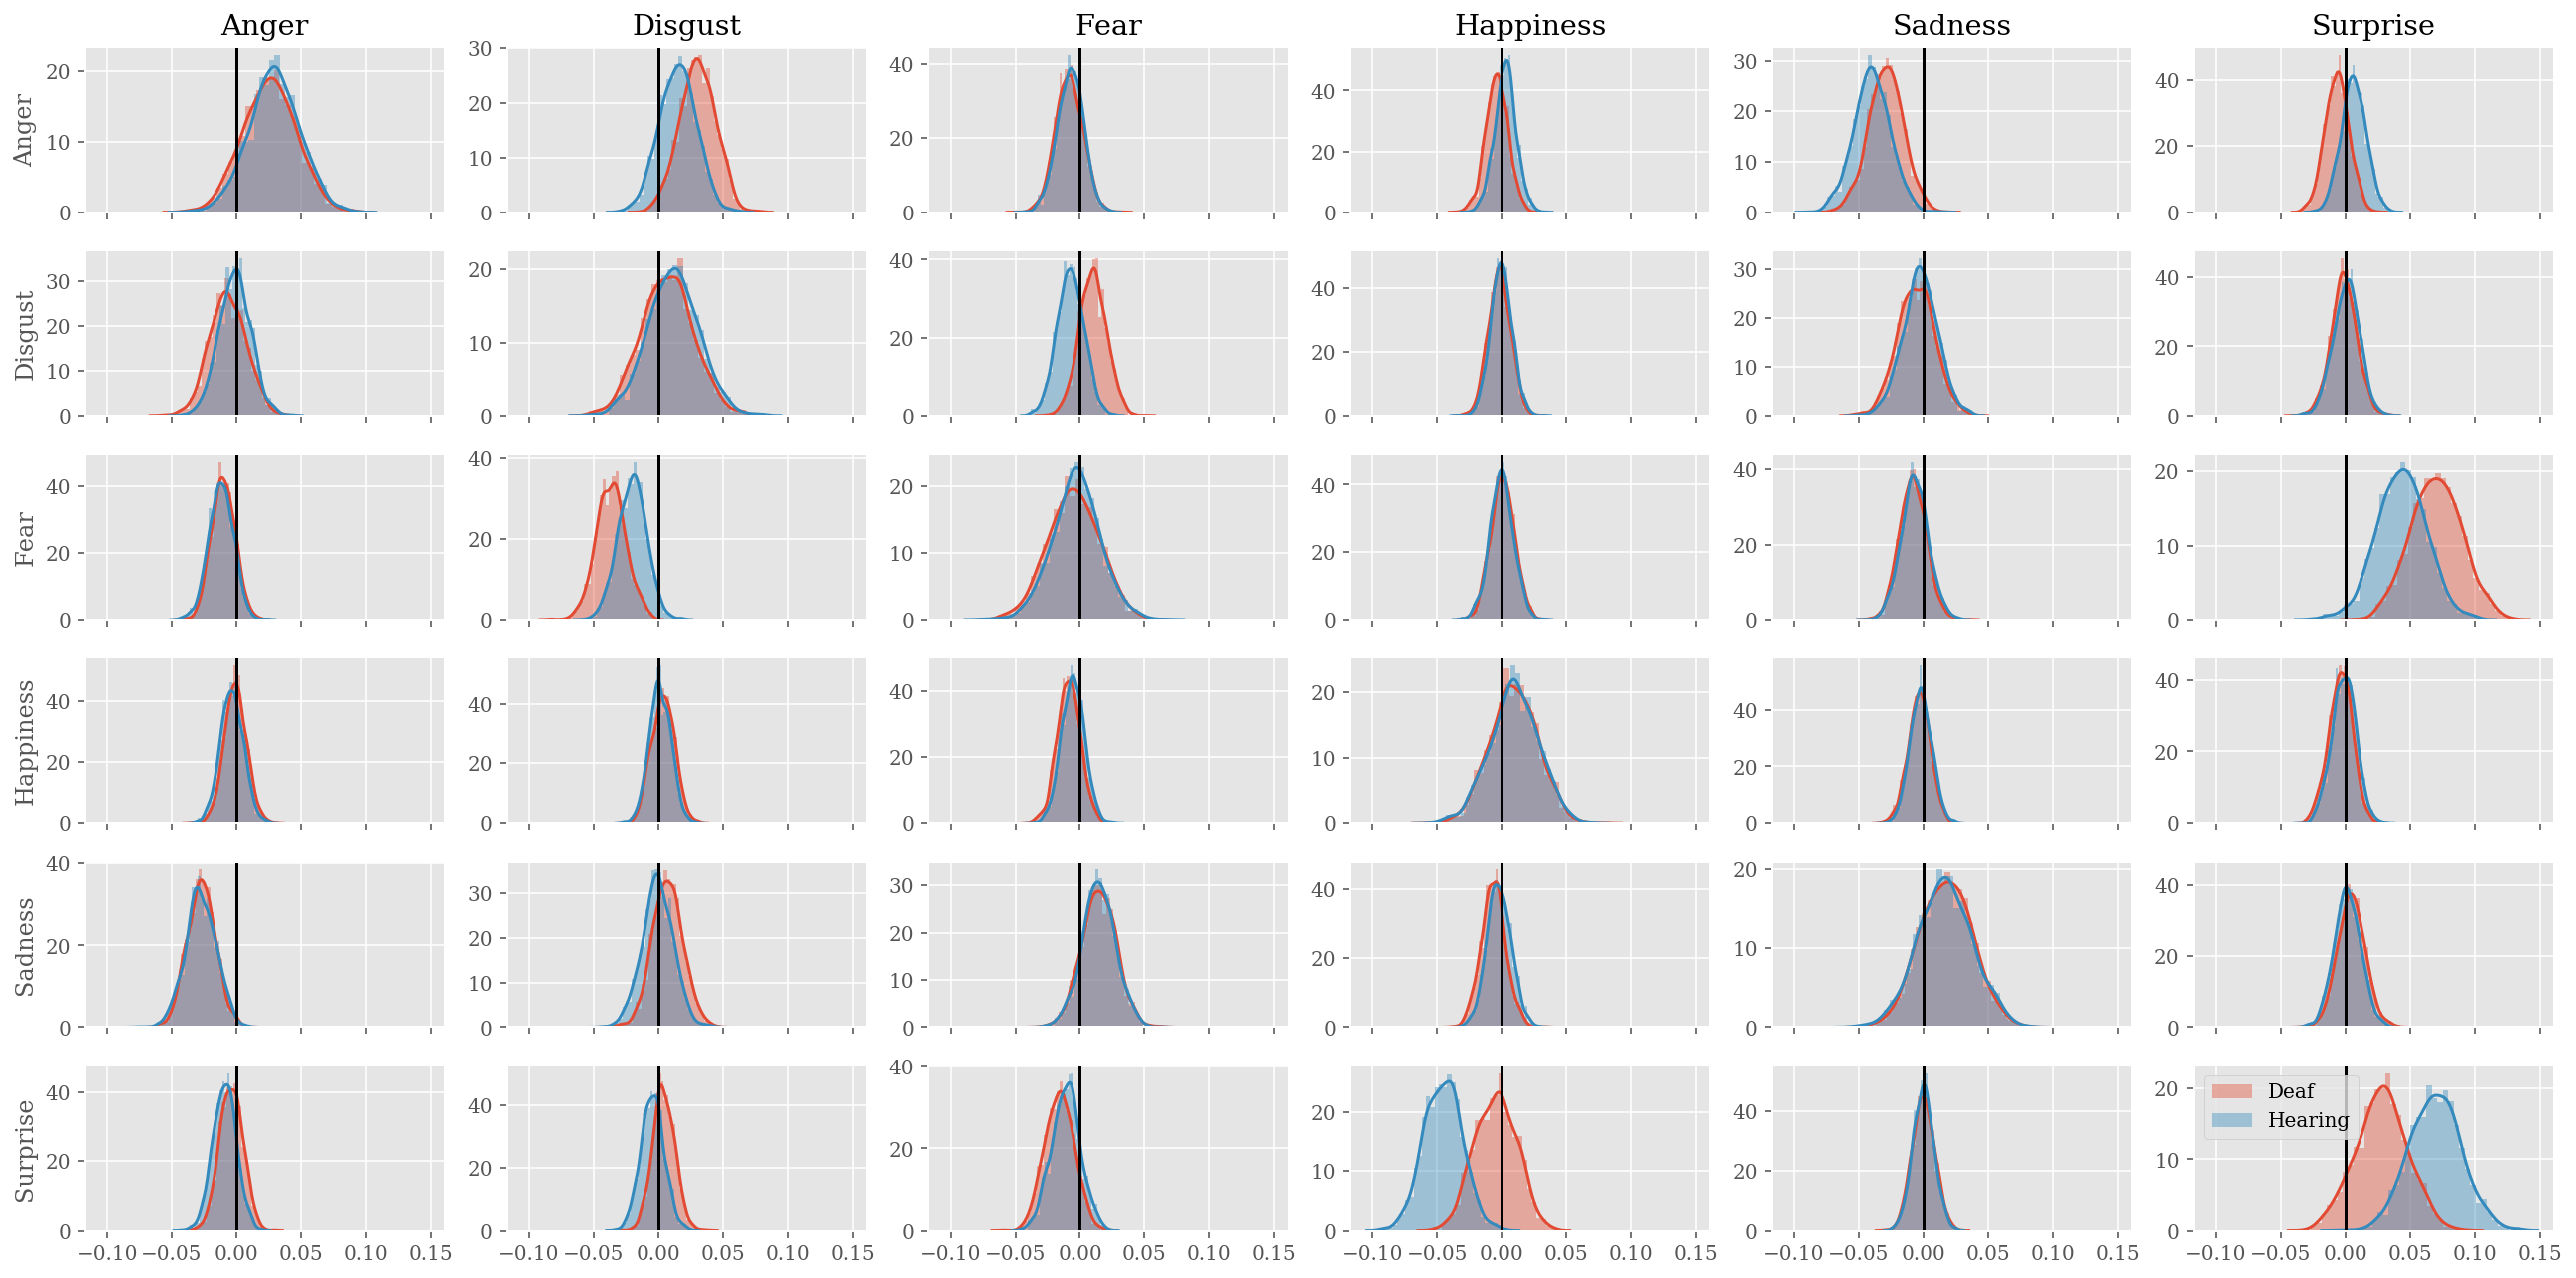

In [47]:
post_dync_adv(postp)

In [48]:
prior2 = np.tile(beta[None,:,:], (2, 3, 1, 1))

In [49]:
with pm.Model() as model1:
    sbj_random = pm.HalfNormal('sbjsd', 1., shape=prior.shape)
    grp_task = pm.HalfNormal('grp_task', 1.,
                             shape=prior2.shape, testval=prior2)
    theta = tt.reshape(grp_task[groupid, :, :, :], prior.shape) + sbj_random
    # normalization inside Multinomial with
    # p = p / tt.sum(p, axis=-1, keepdims=True)
    obs = pm.Multinomial('obs', n=ntrial, p=theta, observed=dataval)
    trace1 = pm.sample(1000, tune=1000)

/home/junpenglao/anaconda3/lib/python3.7/site-packages/Theano-1.0.4-py3.7.egg/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grp_task, sbjsd]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [03:22<00:00, 19.80draws/s]
The acceptance probability does not match the target. It is 0.6673035555095107, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7105539755725648, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is sma

BFMI = [0.84144803 0.75412992] 
max(R_hat) = 1.017417574593537 min(Eff_n) = 244.7255492141859


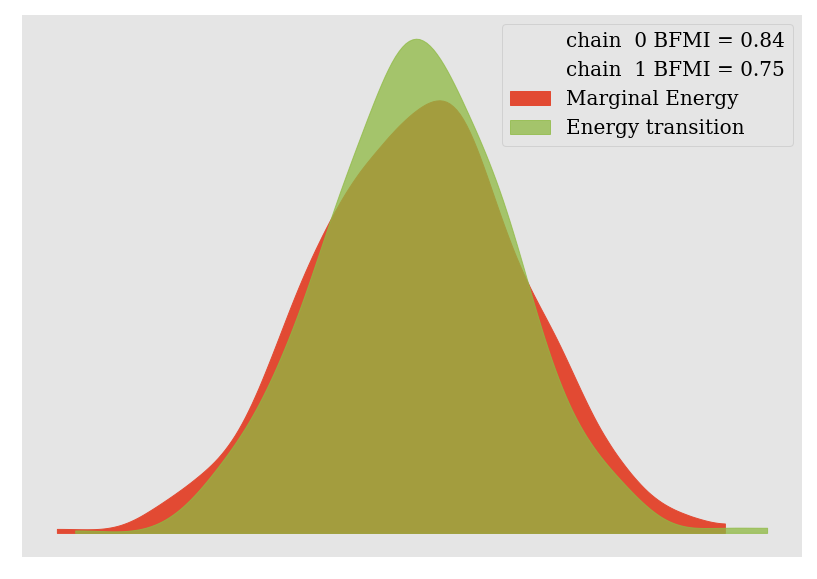

In [50]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

bfmi, max_gr, min_effn = get_diags(trace1)
pm.energyplot(trace1, ax=ax);
print(CONVERGENCE_TITLE(bfmi, max_gr, min_effn))

Displaying task Dynamic


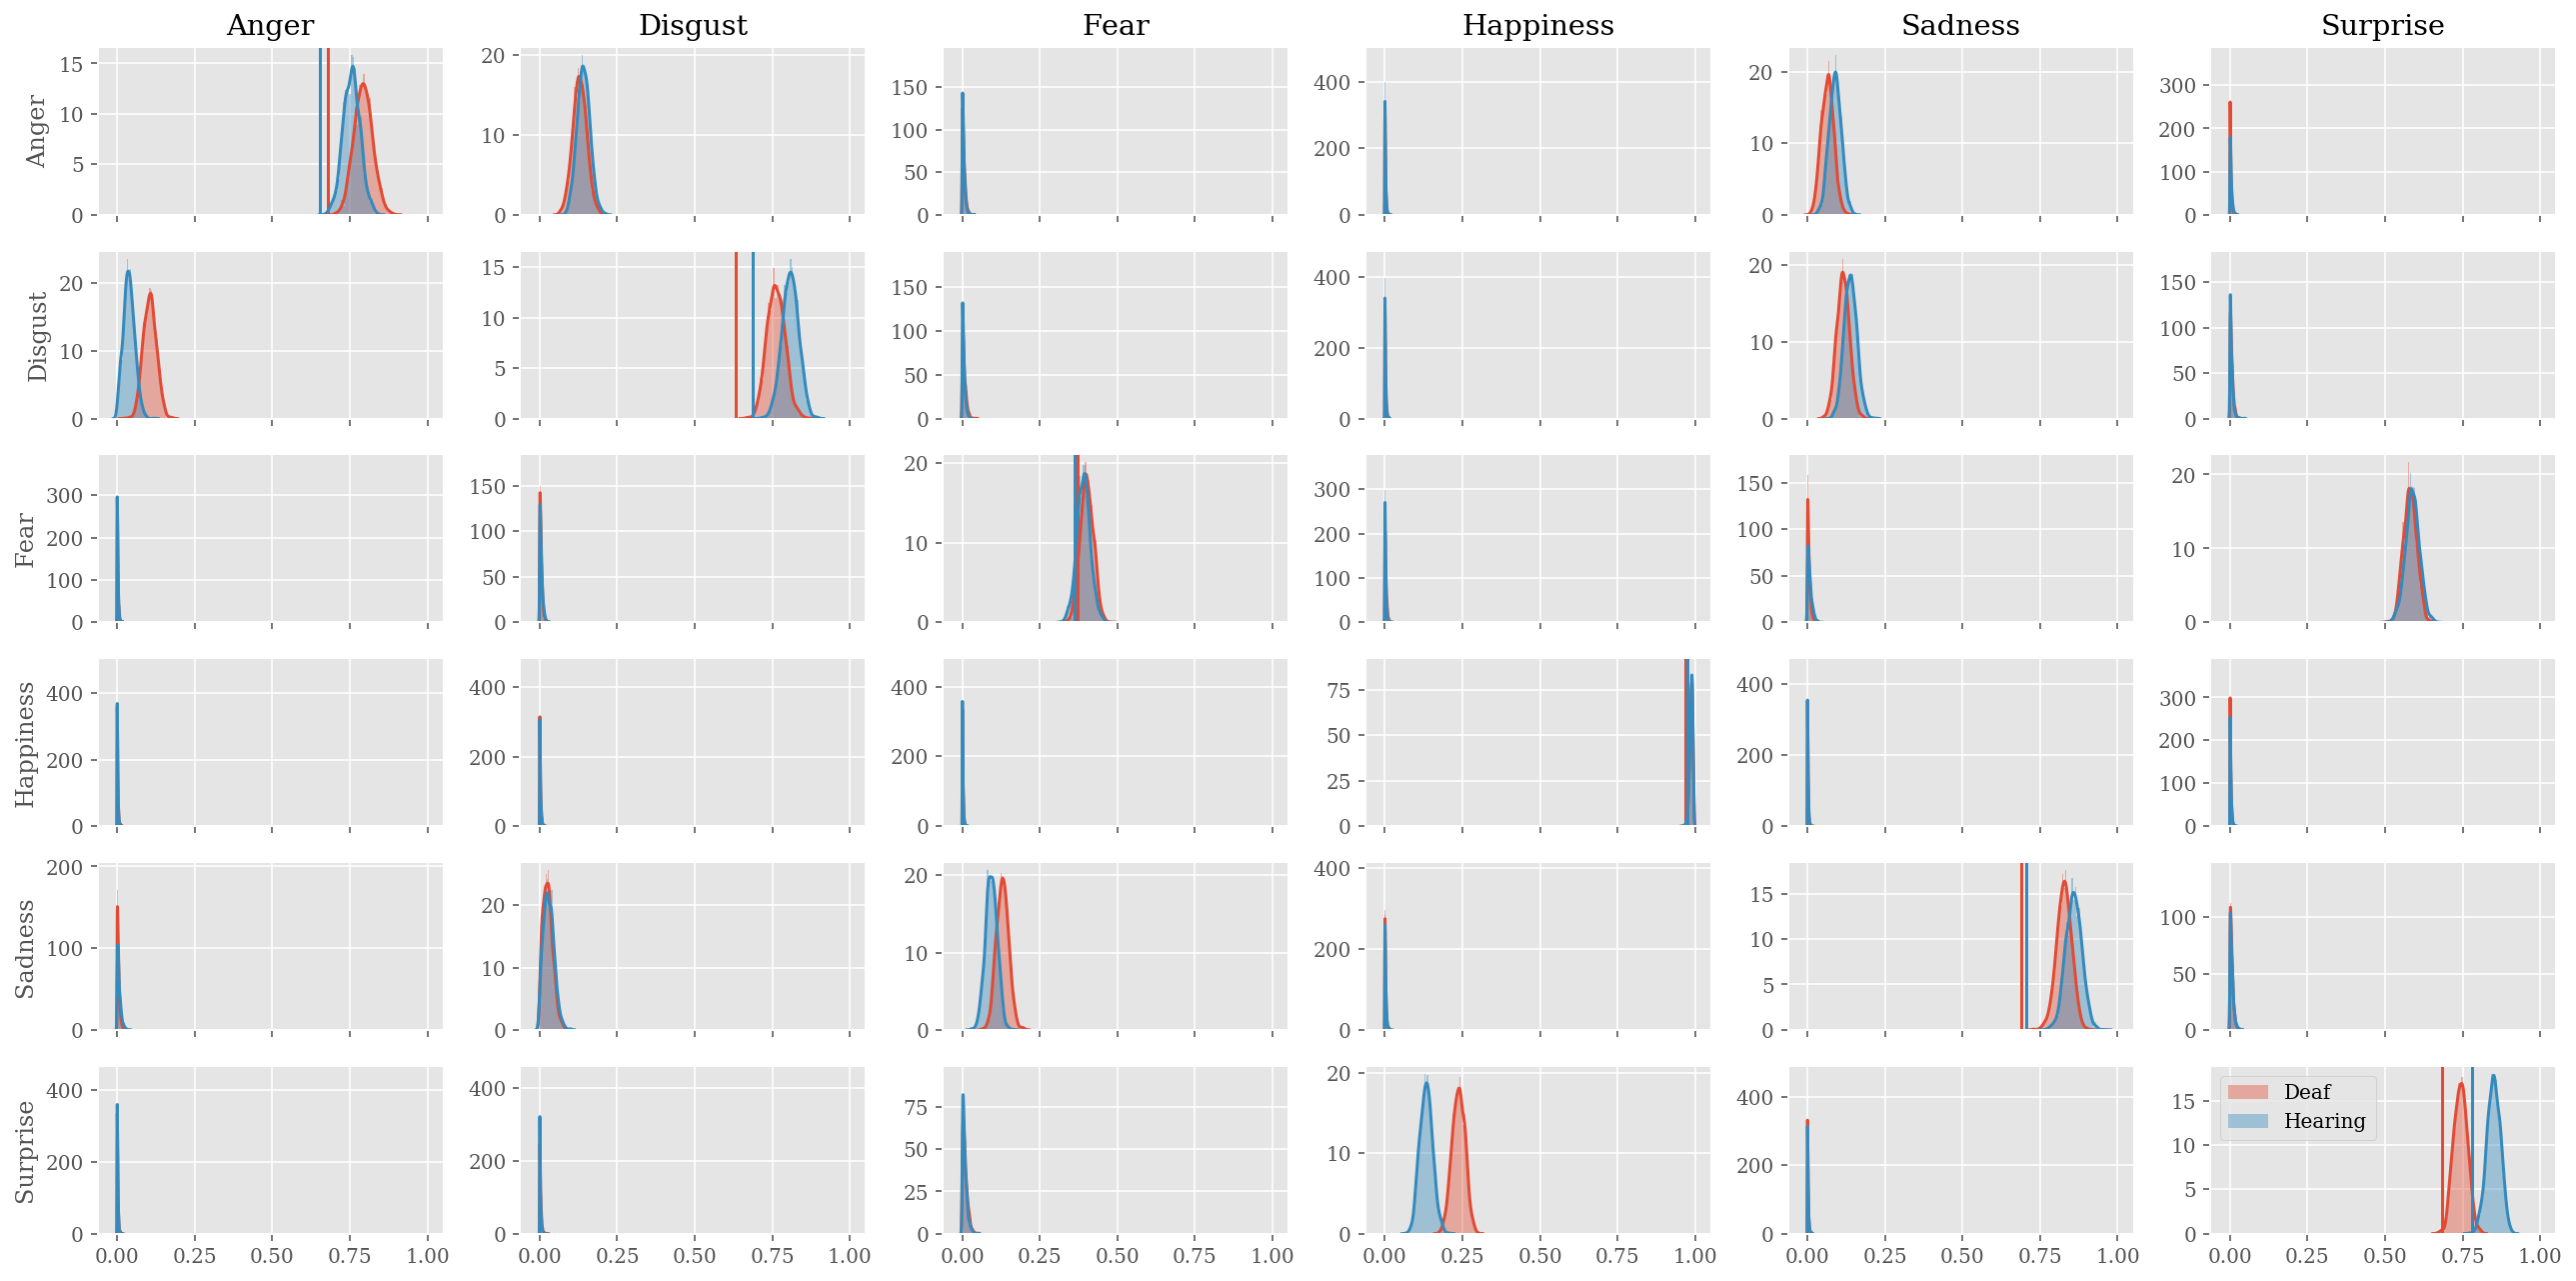

In [51]:
posterior_p = trace1['grp_task']
postp1 = posterior_p / np.sum(posterior_p, axis=-1, keepdims=True)
plotgroup_p(postp1, 0)

Displaying dynamic advantage [Dynamic minus Static]


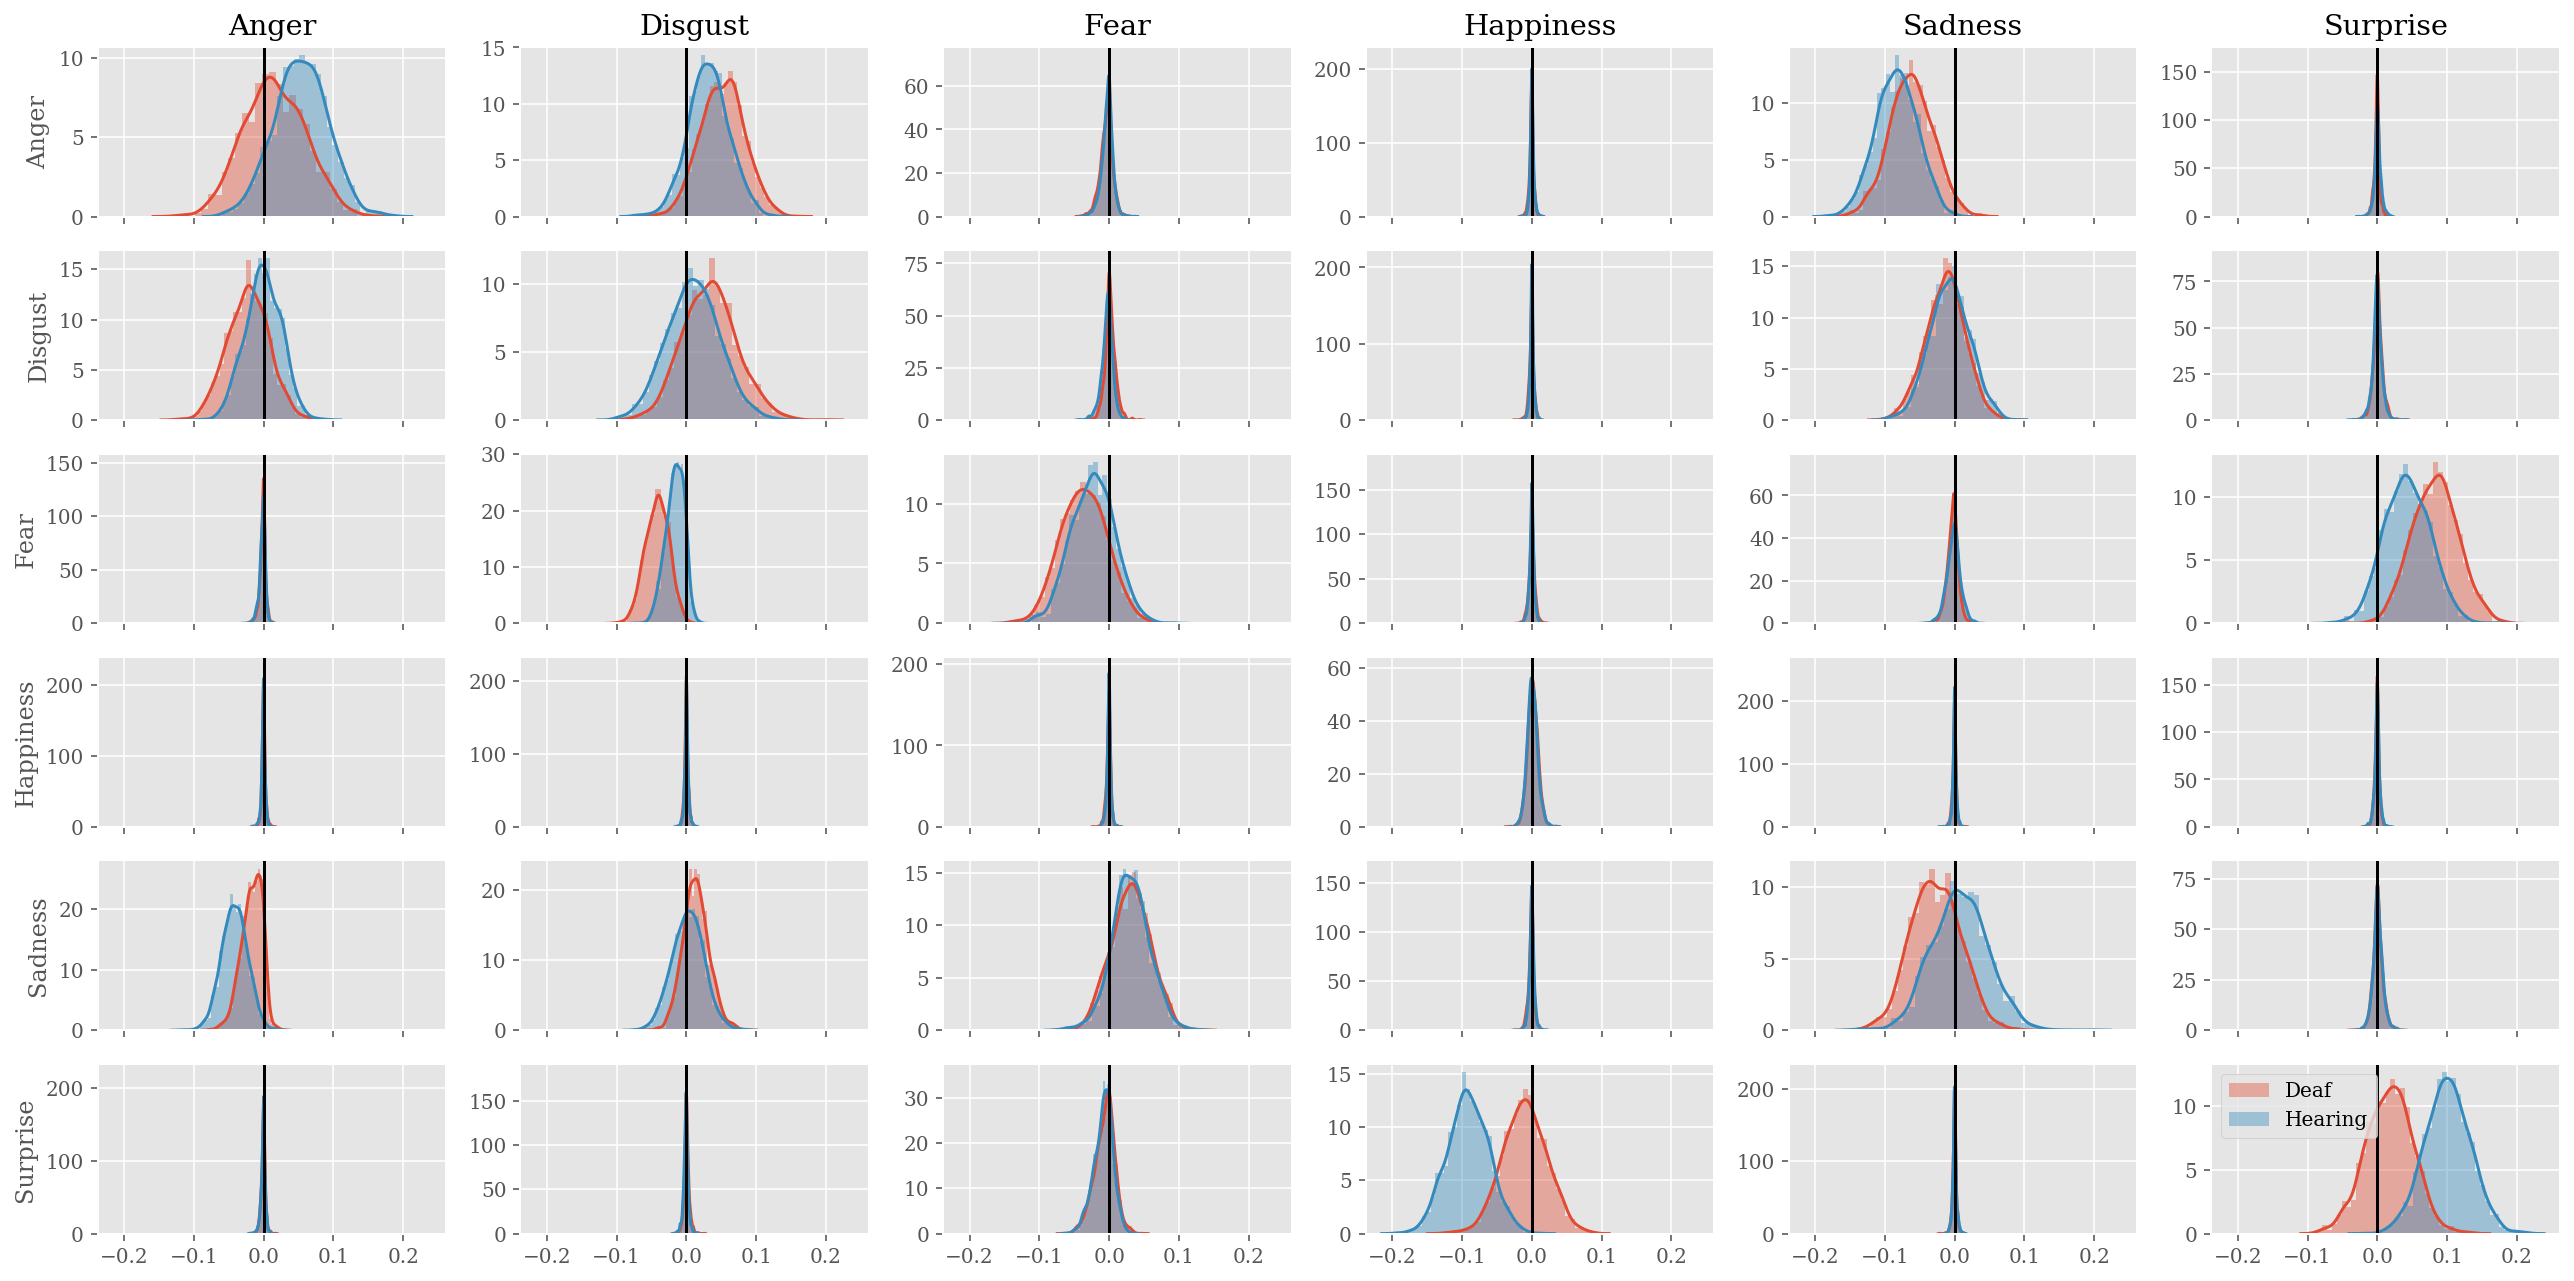

In [52]:
post_dync_adv(postp1)

In [53]:
with pm.Model() as model1_:
    sbj_random = pm.Normal('sbjsd', 0., 1., shape=prior.shape)
    grp_task = pm.Normal('grp_task', 0., 1.,
                         shape=prior2.shape, testval=prior2)
    alpha = tt.reshape(grp_task[groupid, :, :, :], prior.shape) + sbj_random
    theta = tt.nnet.softmax(alpha)
    obs = pm.Multinomial('obs', n=ntrial, p=theta, observed=dataval)
    trace1_ = pm.sample(1000, tune=1000)

/home/junpenglao/anaconda3/lib/python3.7/site-packages/Theano-1.0.4-py3.7.egg/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grp_task, sbjsd]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [02:56<00:00, 30.12draws/s]
The number of effective samples is smaller than 25% for some parameters.


BFMI = [0.95000843 0.96363296] 
max(R_hat) = 1.017821708865159 min(Eff_n) = 200.56196741798558


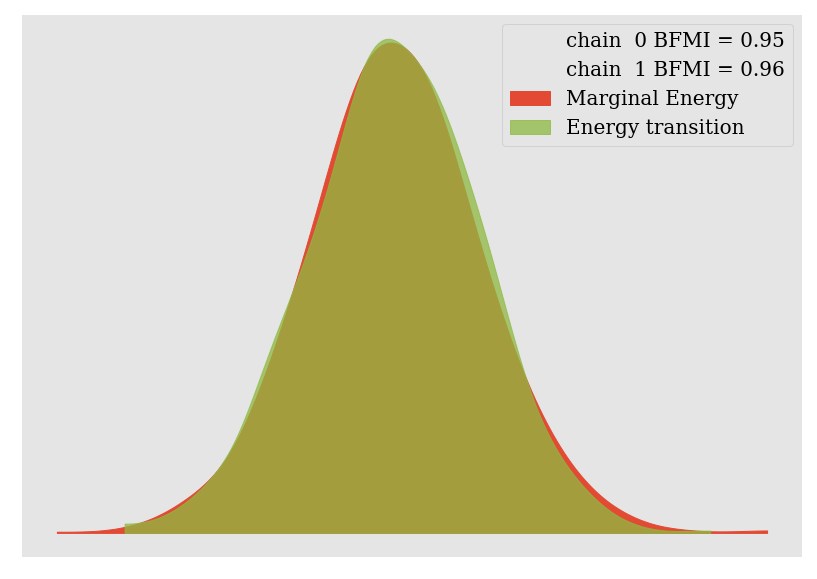

In [54]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

bfmi, max_gr, min_effn = get_diags(trace1_)
pm.energyplot(trace1_, ax=ax);
print(CONVERGENCE_TITLE(bfmi, max_gr, min_effn))

Displaying task Dynamic


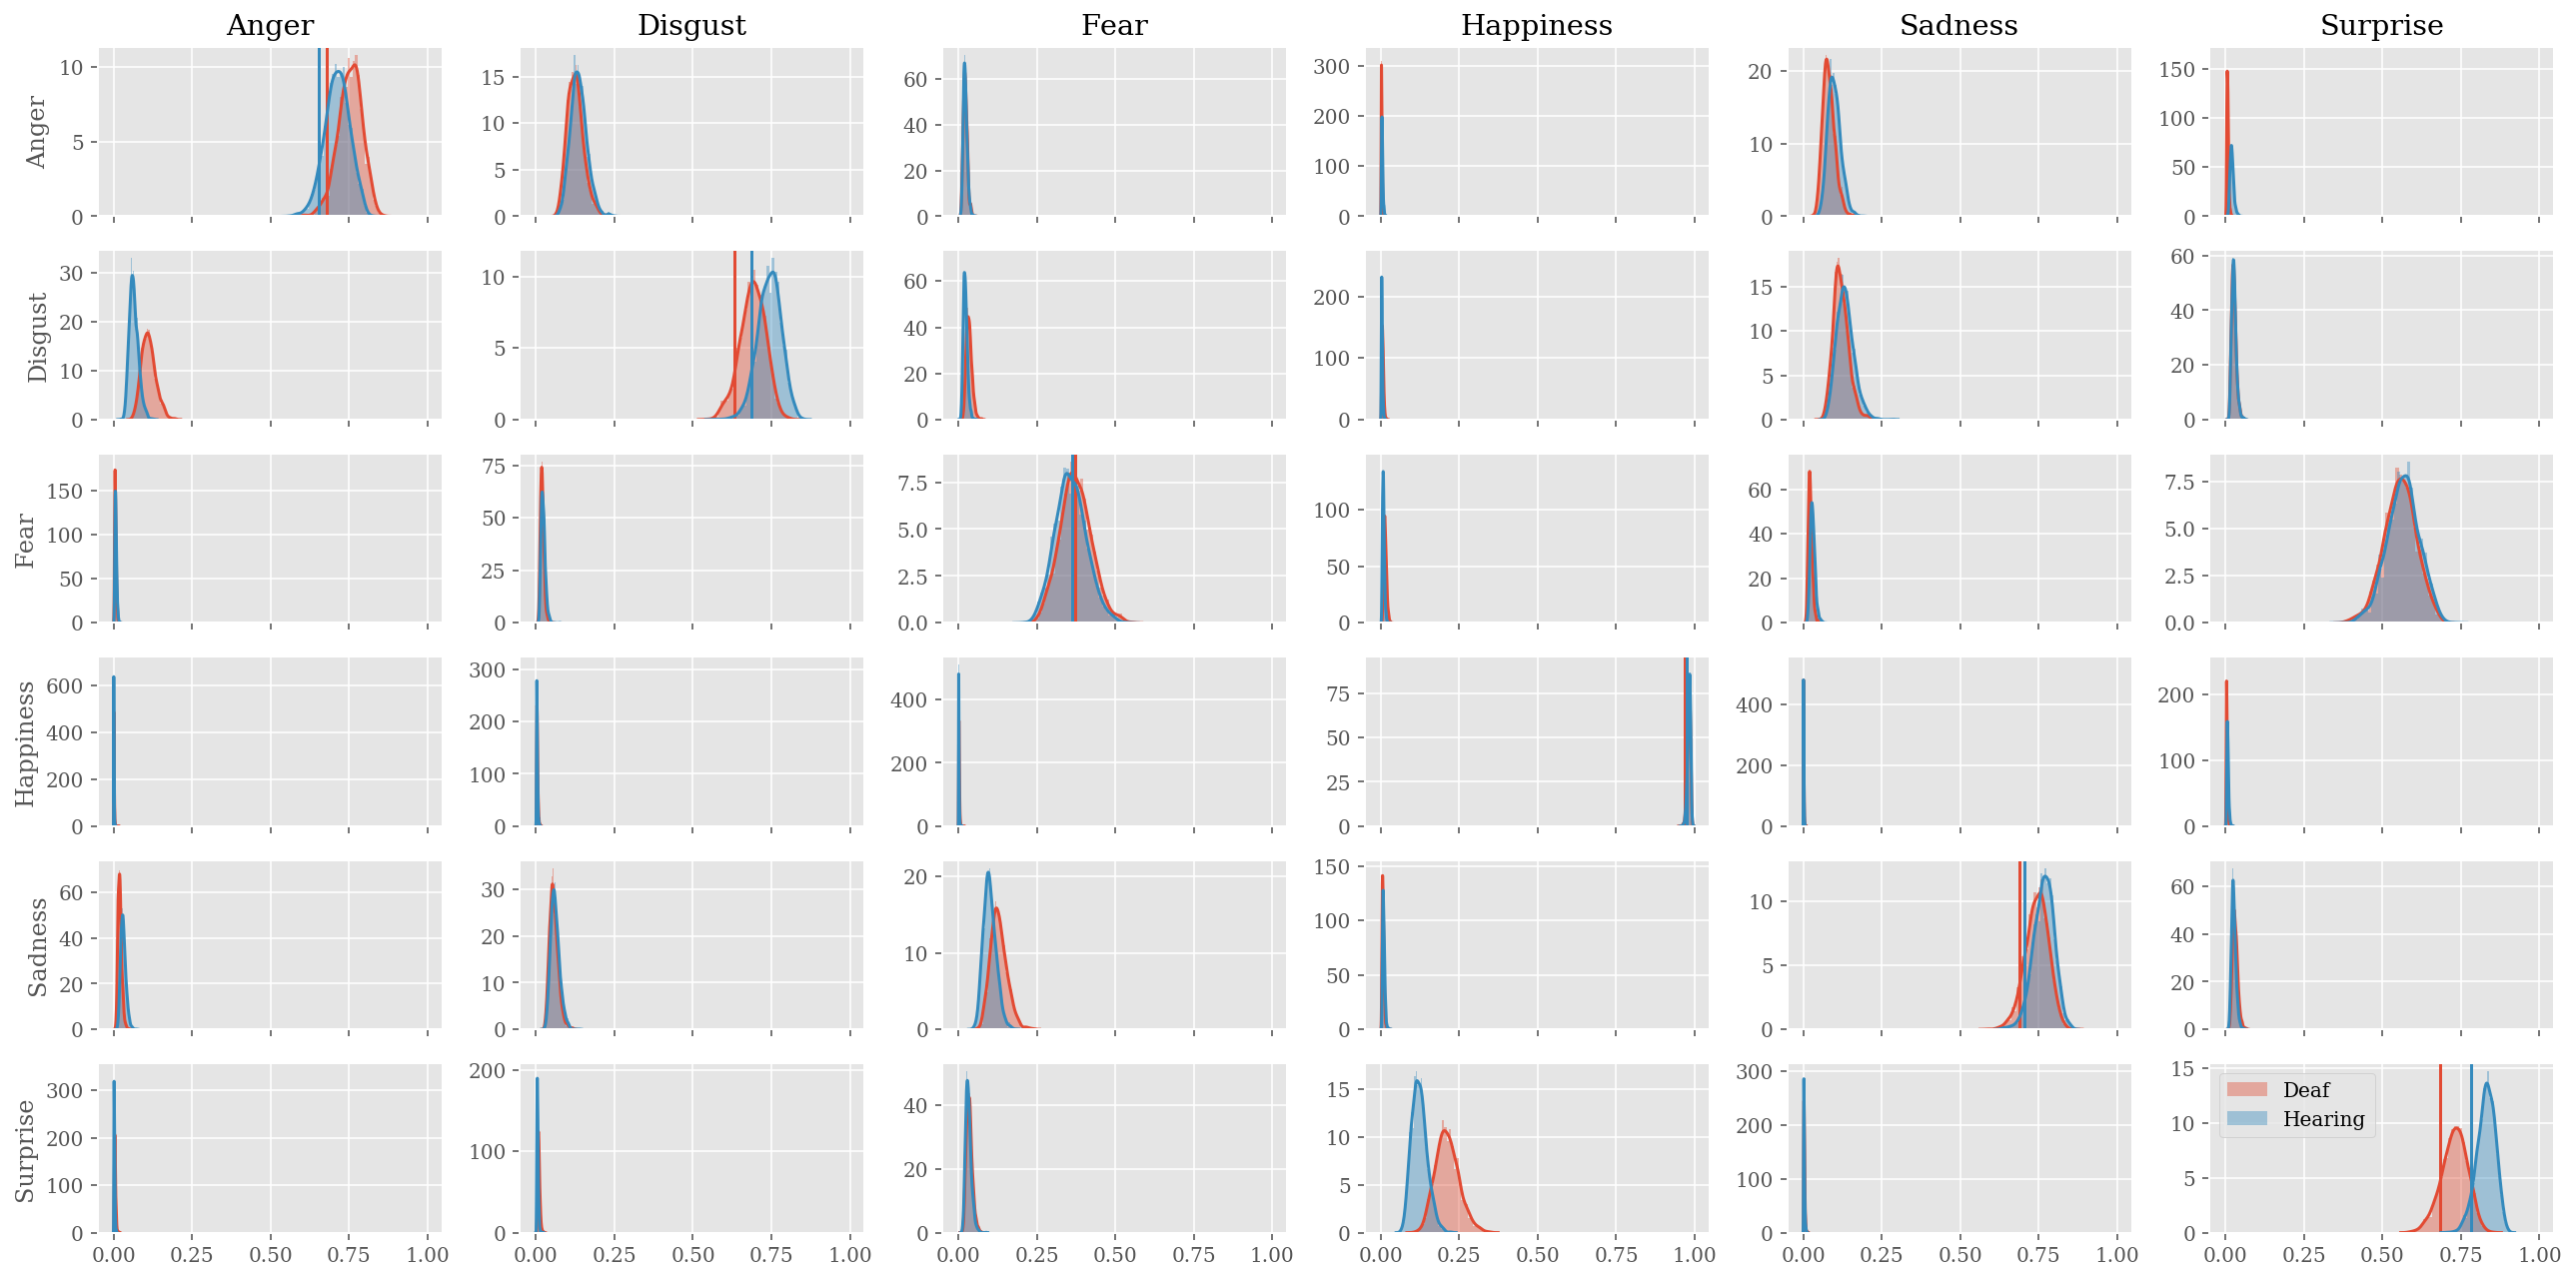

In [55]:
postp1_ = softmax(trace1_['grp_task'])
plotgroup_p(postp1_, 0)

Displaying dynamic advantage [Dynamic minus Static]


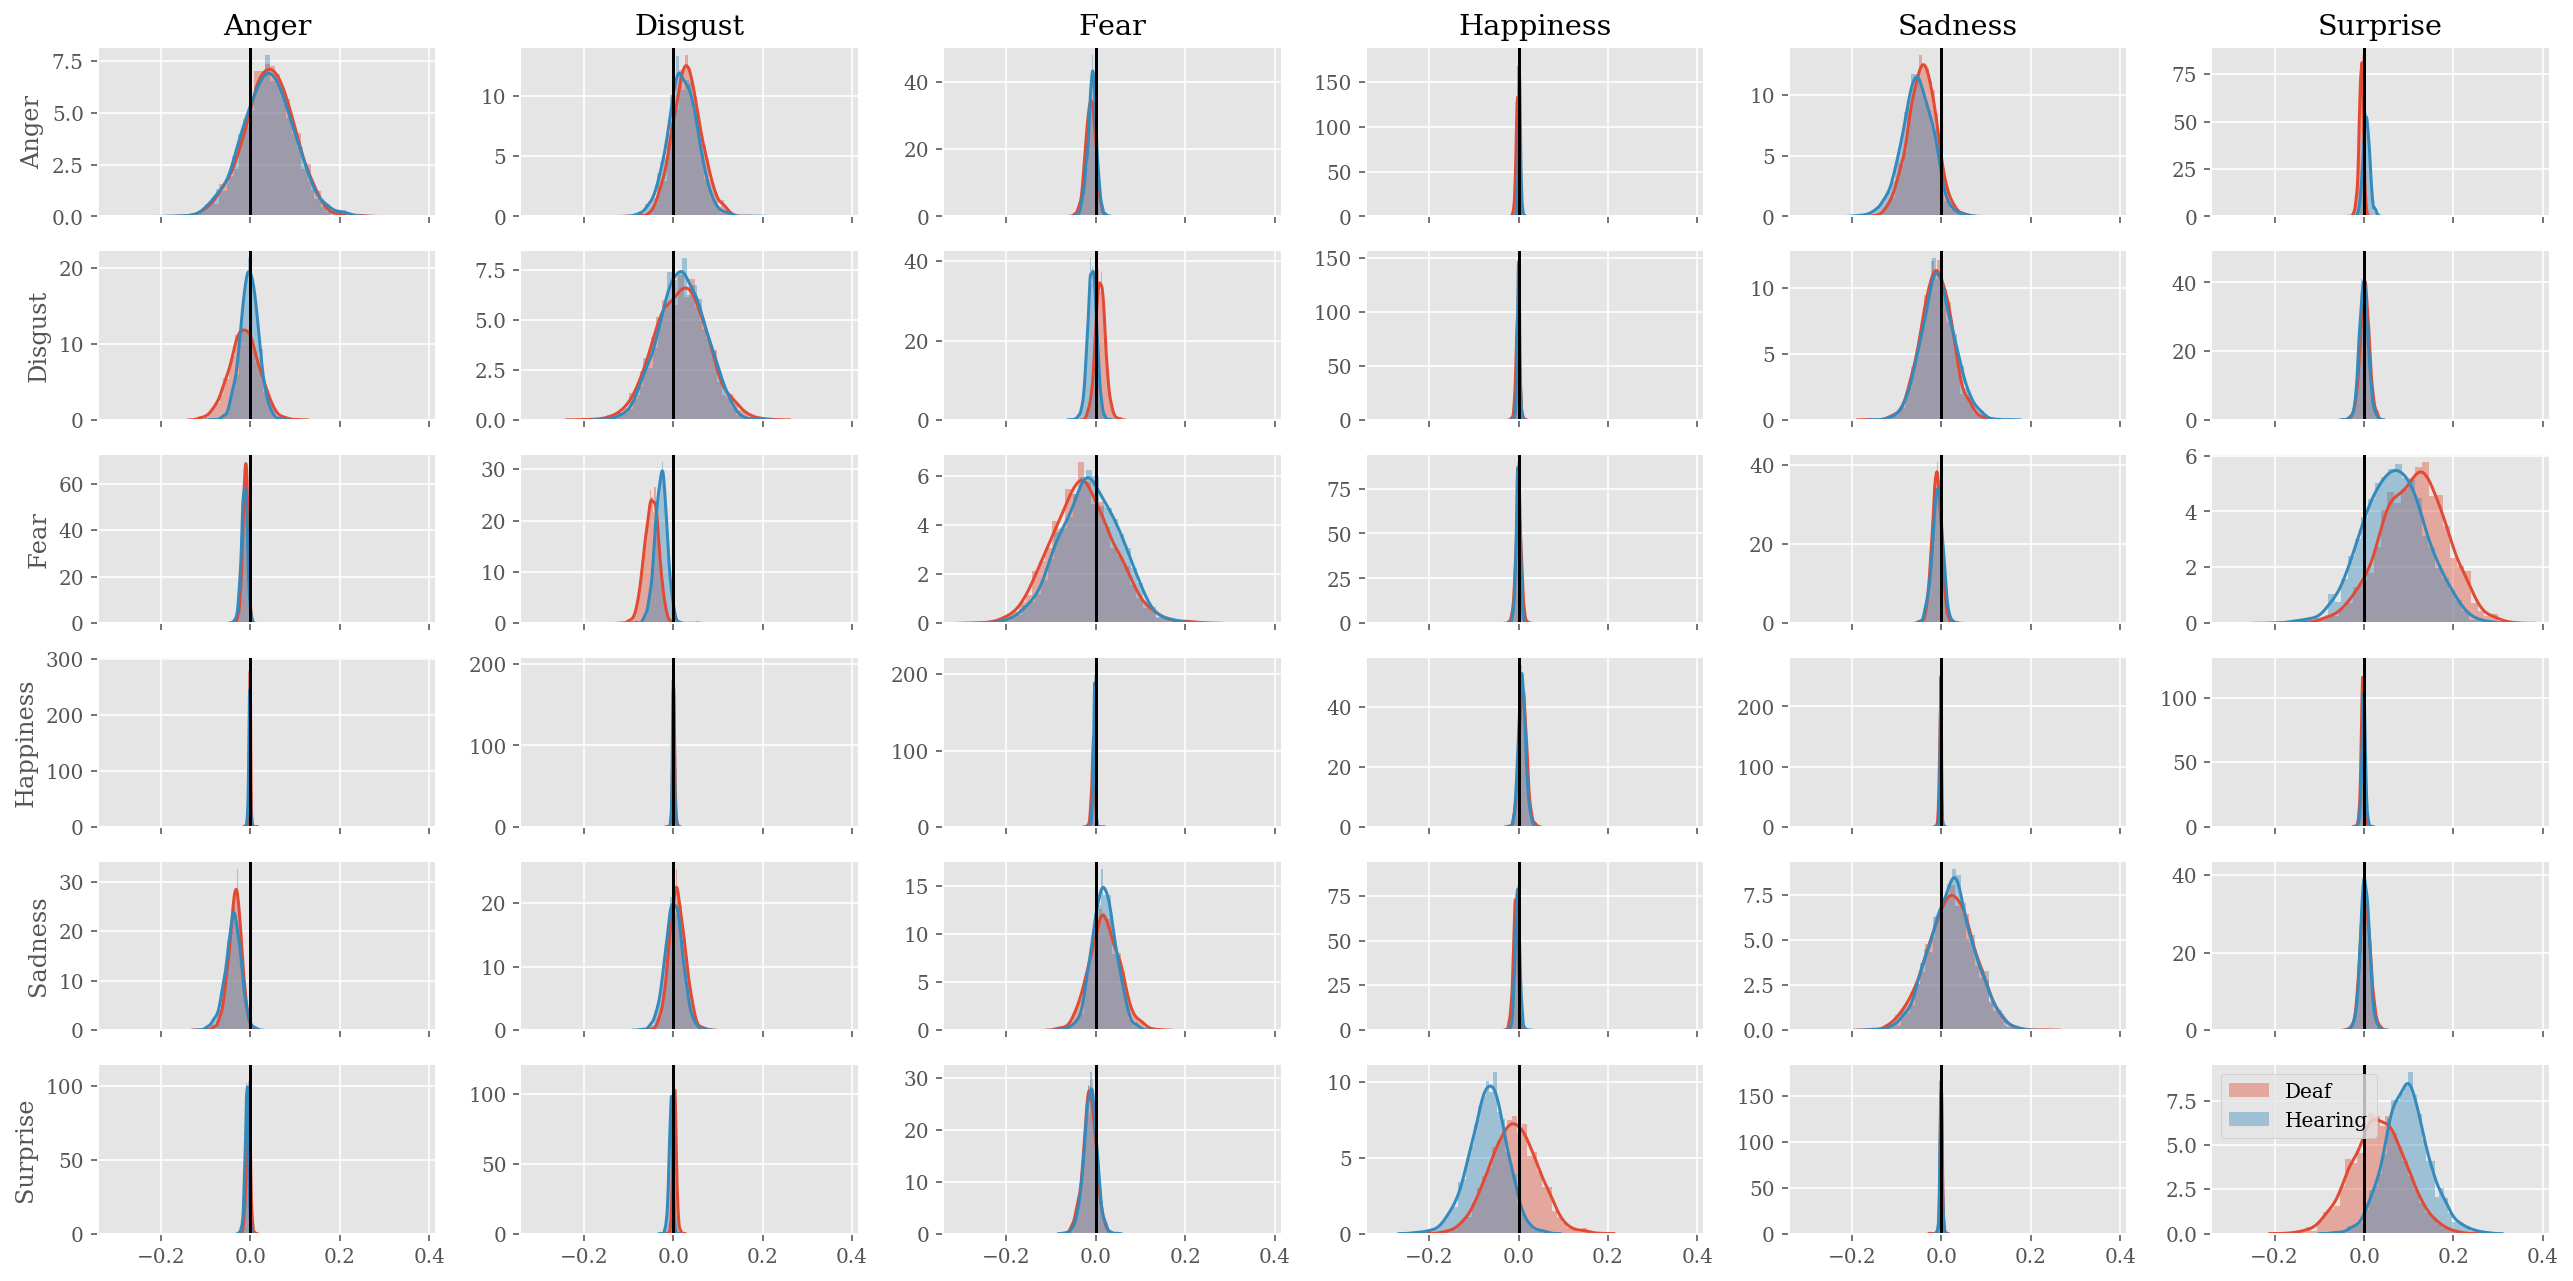

In [56]:
post_dync_adv(postp1_)

# Full model

In [57]:
Nsbj = Conf_mat.shape[0]
sbjidx = np.asarray([np.arange(Nsbj)]*Ntask).T

In [58]:
with pm.Model() as model2:
    """The sbject mu here helps convergent"""
    # sbj_interp = 0.
    sbj_interp = pm.Normal('sbjmu', 0., 1., shape=(Nsbj, 1, 1))
    
    sbj_random = pm.Normal('sbjsd', sbj_interp, 1., shape=(Nsbj, Nexp, Nresp))
    grp_task = pm.Normal('grp_task', 0., 1., shape=(Ng, Ntask, Nexp, Nresp))
    alpha = tt.reshape(grp_task[groupid] + sbj_random[sbjidx],
                       prior.shape)
    theta = tt.nnet.softmax(alpha)
    obs = pm.Multinomial('obs', n=ntrial, p=theta, observed=dataval)

/home/junpenglao/anaconda3/lib/python3.7/site-packages/Theano-1.0.4-py3.7.egg/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [59]:
with model2:
    trace2 = pm.sample(1000, tune=2000, nuts_kwargs=dict(max_treedepth=15))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grp_task, sbjsd, sbjmu]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [31:56<00:00,  1.77draws/s]  
The estimated number of effective samples is smaller than 200 for some parameters.


In [60]:
# import pickle
# tracedump = dict(trace2=trace2)

# with open('trace_DSS_fullmodel.pickle', 'wb') as f:
#     pickle.dump(tracedump, f)

In [61]:
# import pickle
# with open('trace_DSS_fullmodel.pickle', 'rb') as f:
#     tracedump = pickle.load(f)

# trace2 = tracedump['trace2']

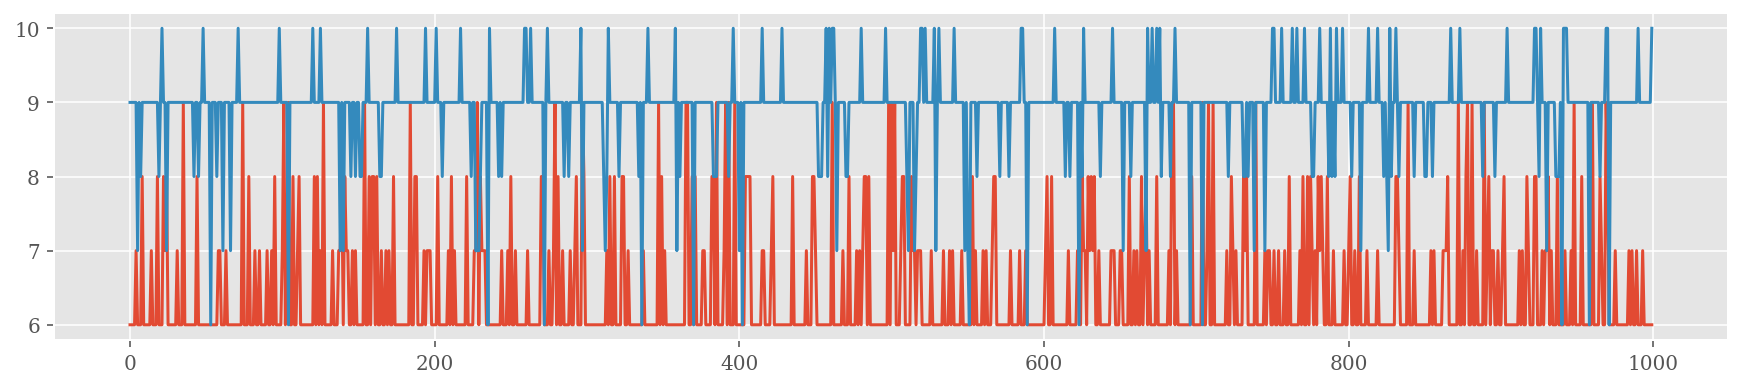

In [62]:
treedp = trace2.get_sampler_stats('depth', combine=False)
_, ax1 = plt.subplots(1, 1, figsize=(15, 3))
for treedp_ in treedp:
    ax1.plot(treedp_)

BFMI = [0.9425891  1.01158476] 
max(R_hat) = 1.0255783450001228 min(Eff_n) = 123.76683174957466


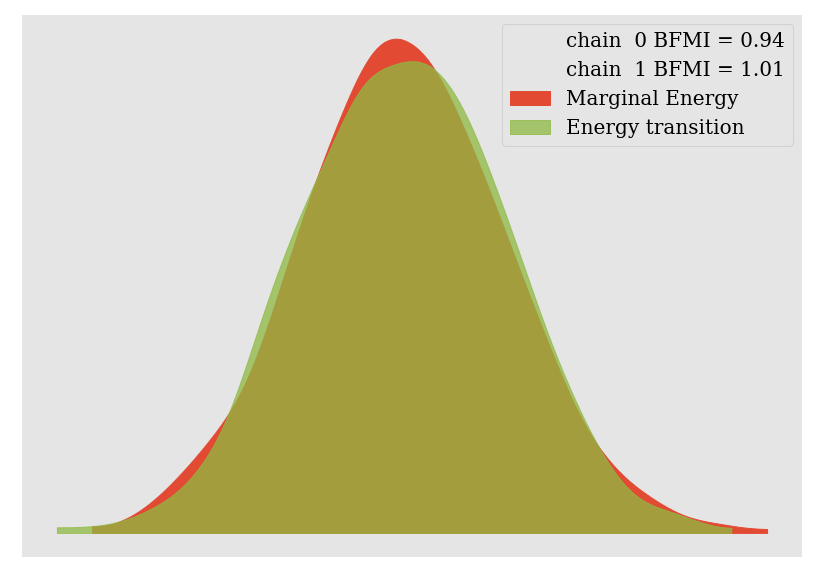

In [63]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))

bfmi, max_gr, min_effn = get_diags(trace2)
pm.energyplot(trace2, ax=ax);
print(CONVERGENCE_TITLE(bfmi, max_gr, min_effn))

/home/junpenglao/anaconda3/lib/python3.7/site-packages/pymc3-3.7-py3.7.egg/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


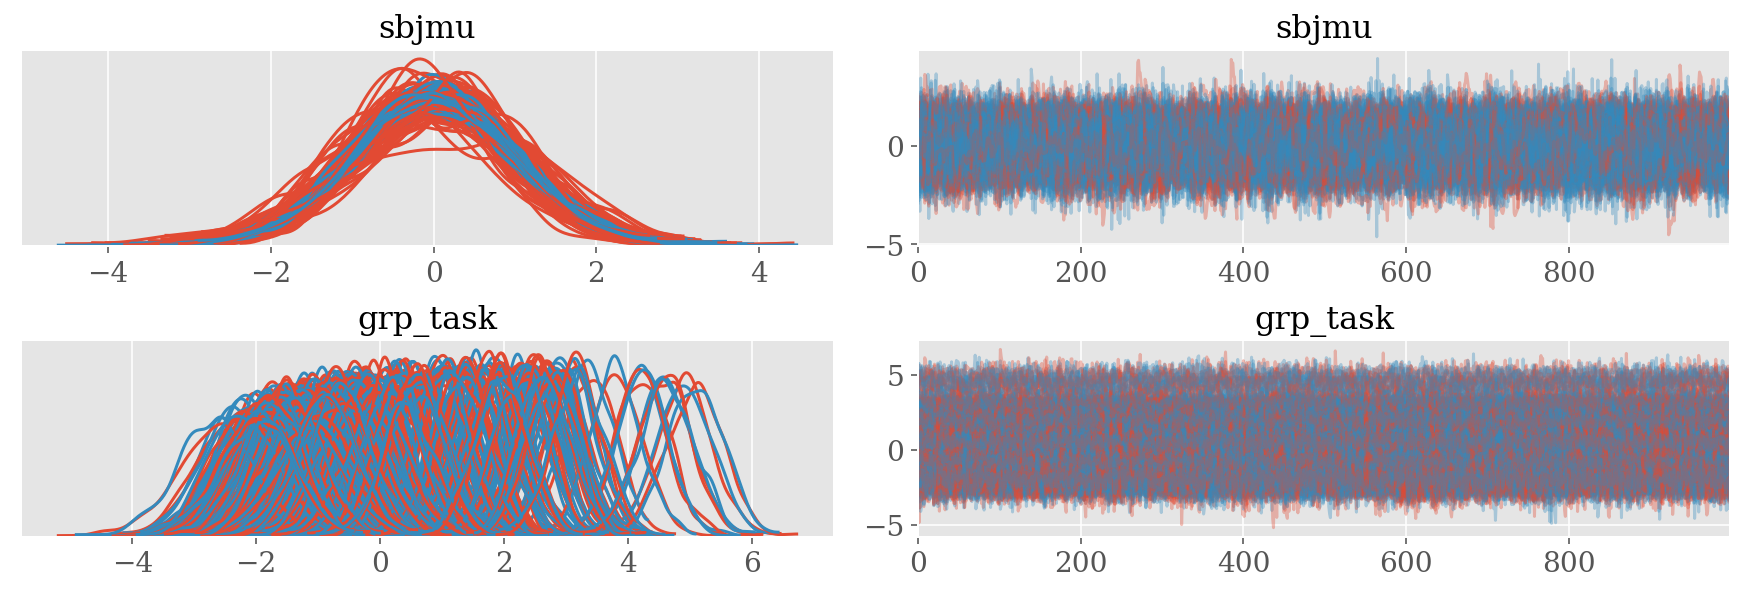

In [64]:
plt.rc('text', usetex=False)
pm.traceplot(trace2, varnames=['sbjmu', 'grp_task']);

In [65]:
dataset_dict = {
    "model0": trace0,
    "model1": trace1,
    "model1_": trace1_,
    "model2": trace2
}

comp_df = pm.compare(dataset_dict)

comp_df

/home/junpenglao/anaconda3/lib/python3.7/site-packages/arviz-0.4.1-py3.7.egg/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


rank     waic   p_waic   d_waic       weight       se      dse  \
model2     0  16808.6  1435.32        0            1  54.6329        0   
model1_    1  17716.9  2131.24  908.339  5.4965e-135  159.759   81.941   
model1     2  23484.2  2253.84  6675.58            0  212.501  159.793   
model0     3  27243.5   4856.4  10434.9            0  211.795  164.325   

        warning waic_scale  
model2     True   deviance  
model1_    True   deviance  
model1     True   deviance  
model0     True   deviance

In [66]:
comp_df_ = pm.compare(dataset_dict, ic='loo')

comp_df_

/home/junpenglao/anaconda3/lib/python3.7/site-packages/arviz-0.4.1-py3.7.egg/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/home/junpenglao/anaconda3/lib/python3.7/site-packages/arviz-0.4.1-py3.7.egg/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and hig

rank      loo    p_loo    d_loo       weight       se      dse  \
model2     0  17001.5  1531.79        0            1  57.2598        0   
model1_    1  18534.2  2539.89  1532.69  2.2159e-276  155.977  87.1683   
model1     2  23653.8  2338.64  6652.25            0   216.13  161.297   
model0     3  28805.1  5637.23  11803.6            0  215.177  171.209   

        warning loo_scale  
model2     True  deviance  
model1_    True  deviance  
model1     True  deviance  
model0     True  deviance

# Final model and numerical report

$i$ for each task (dynamic, static, shuffle), $j$ for each expression, $k$ for each participant, and $g$ for each participant.

$$
\begin{align*}
\text{Observed response} \\
[y_{k,i,j}^1,...,y_{k,i,j}^7] & \sim \text{Multinomial}(n, p_{k,i,j})\\
p_{k,i,j} & = \text{SoftMax}(\mu_{k,i,j})\\
\text{Mixed-effect model} \\
\mu_{k,i,j} & = X^{kg}\beta_{g,i,j} + b_{k,i,j}\\
\text{Group-level coefficients} \\
\beta_{g,i,j} & \sim \text{Normal}(0, 1)\\
\text{Subject-level coefficients} \\
b_{k,i,j} & \sim \text{Normal}(\eta_k, 1)\\
\eta_k & \sim \text{Normal}(0, 1)\\
\end{align*}
$$

In [67]:
postp2 = softmax(trace2['grp_task'])

In [68]:
def df_group(postp2, itask=0, ie=0):
    funcs = [lambda x: pd.Series(np.mean(x, 0), name='mean'),
             lambda x: pd.Series(np.std(x, 0), name='sd'),
             lambda x: pd.Series(pm.stats.mcse(x.T), name='mc_error'),
             lambda x: pd.DataFrame(pm.stats.hpd(flat_vals, .05), 
                                    columns=['hpd_2.5', 'hpd_97.5'])]
    expname = exp_list[ie]
    print('Displaying ' + expname + ' condition in ' +
          Taskname[itask] + ' task:')
    var_dfs = []
    for irsp, rspname in enumerate(resp_list):
        for ig, grpname in enumerate(grplist):
            vals = postp2[:, ig, itask, ie, irsp]
            flat_vals = vals.reshape(vals.shape[0], -1)
            var_df = pd.concat([f(flat_vals) for f in funcs], axis=1)
            var_df['Respond'] = rspname
            var_df['Express'] = expname
            var_df['Group'] = grpname
            var_dfs.append(var_df)
        vals = postp2[:, 0, itask, ie, irsp] - postp2[:, 1, itask, ie, irsp]
        flat_vals = vals.reshape(vals.shape[0], -1)
        var_df = pd.concat([f(flat_vals) for f in funcs], axis=1)
        var_df['Respond'] = rspname
        var_df['Express'] = expname
        var_df['Group'] = 'Diff'
        var_dfs.append(var_df)

    dforg = pd.concat(var_dfs, axis=0)
    return dforg.set_index(['Express', 'Respond', 'Group'])

## Dynamic Condition

Displaying task Dynamic


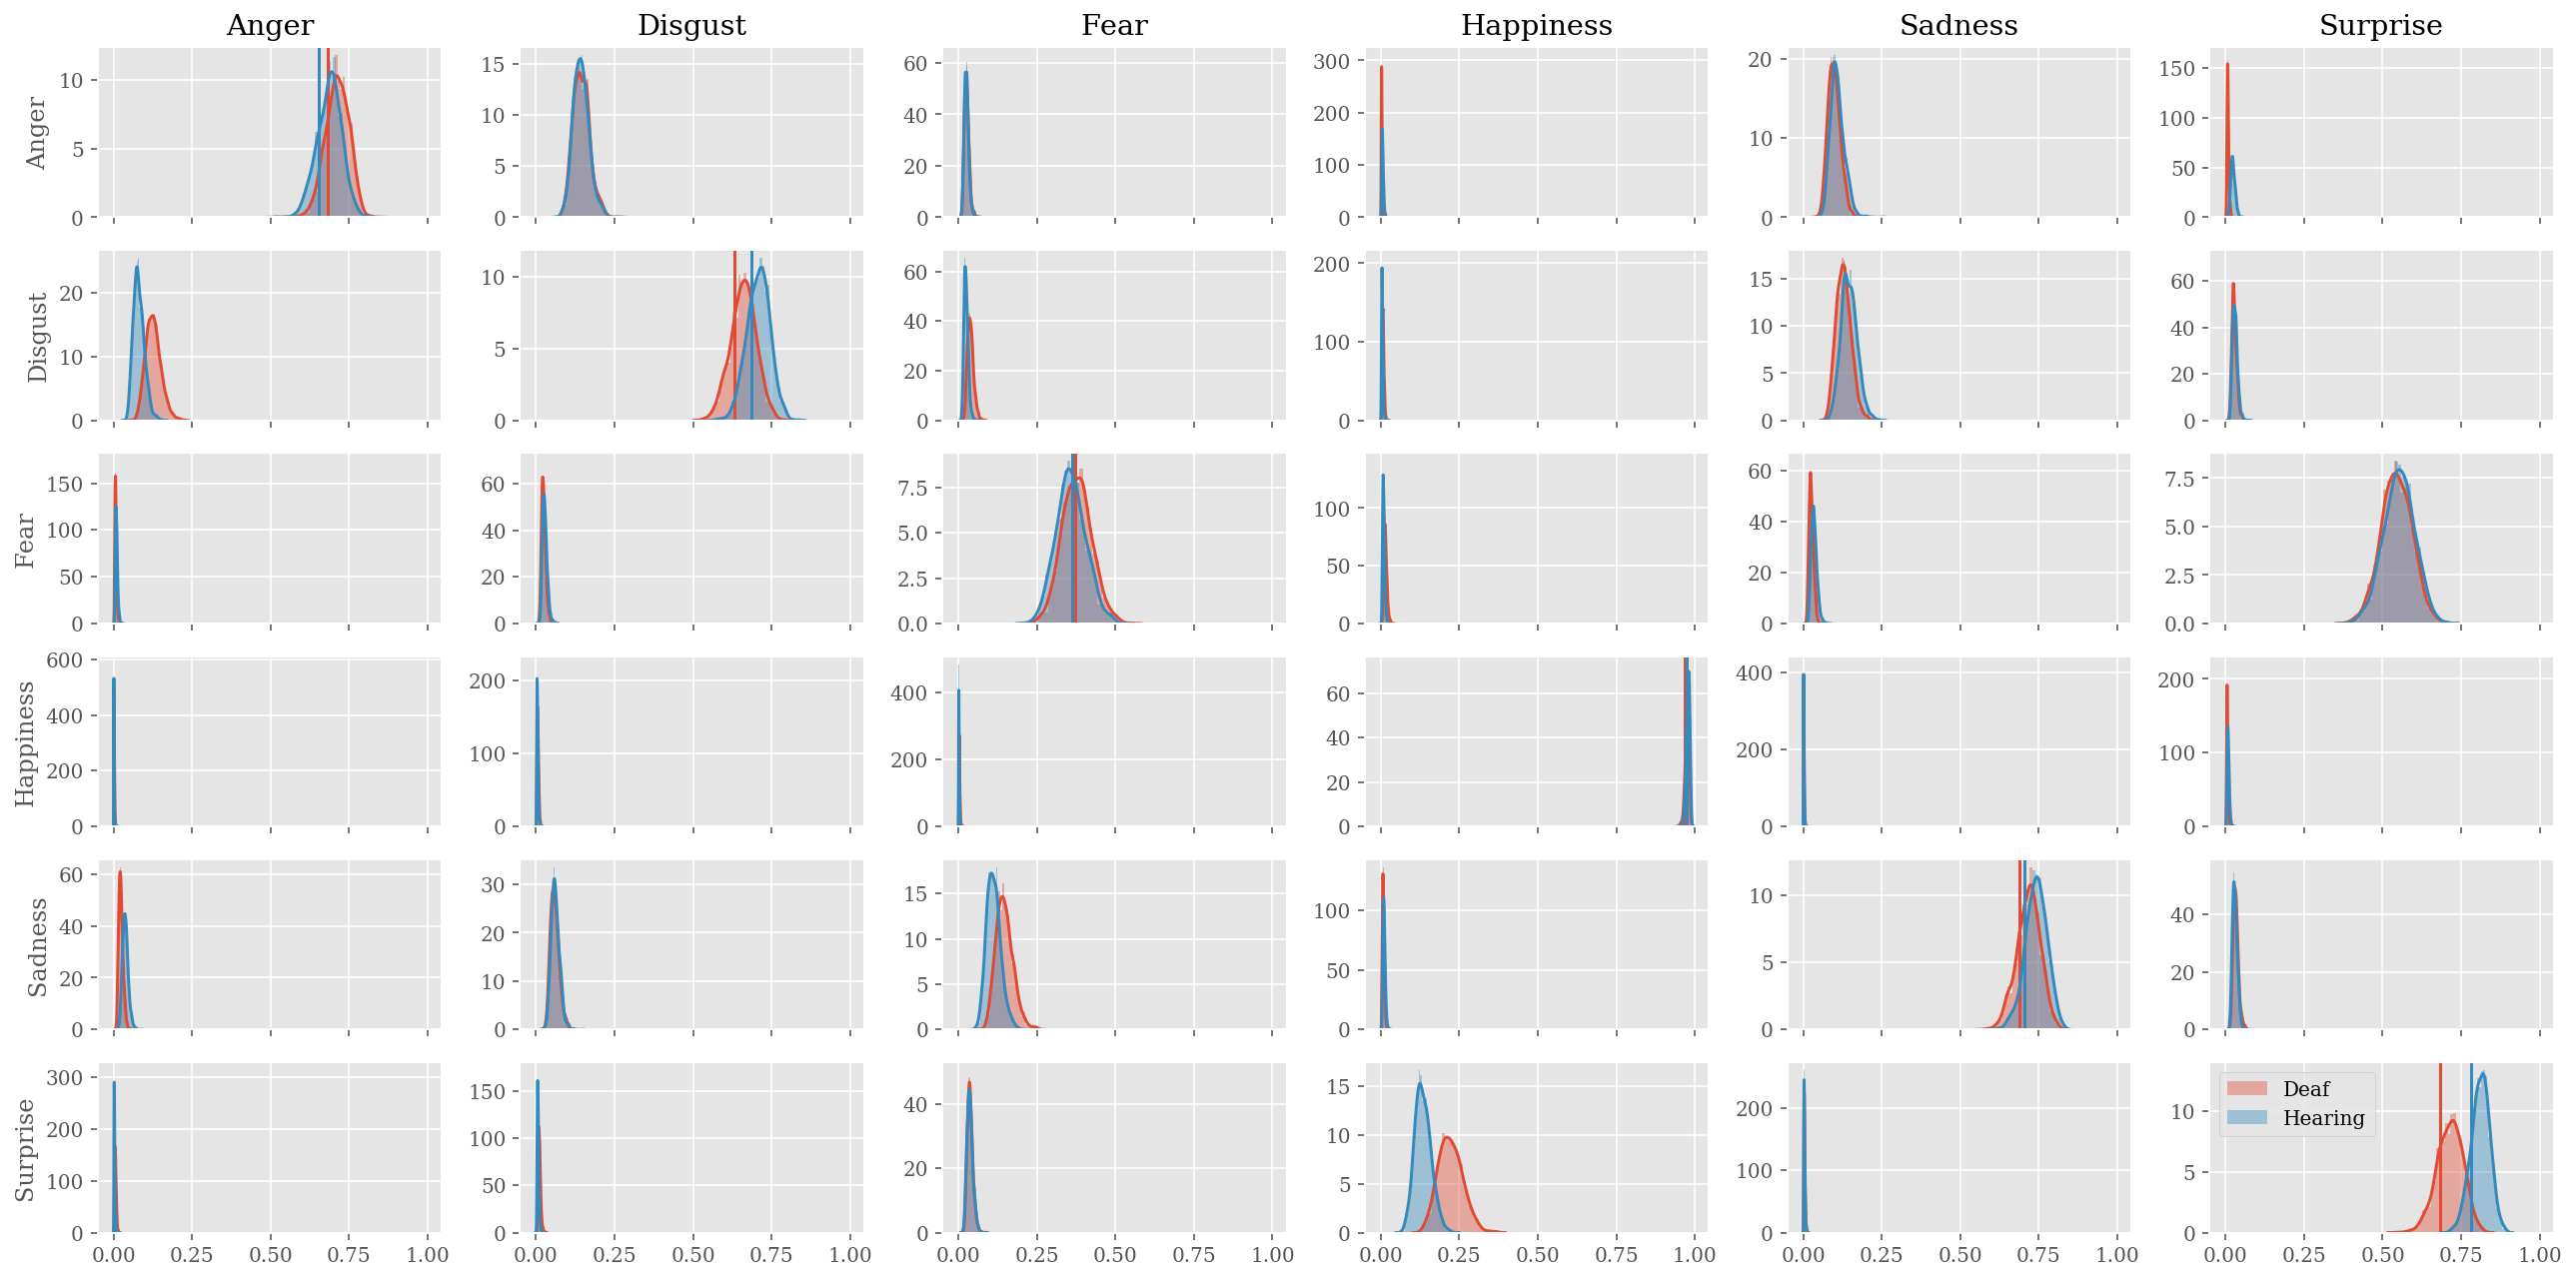

In [69]:
plotgroup_p(postp2, 0)
plt.savefig('figs/Posterior_Dynamic_condition.svg',
            format='svg', dpi=300)

In [70]:
df_group(postp2, itask=0, ie=0)

Displaying Anger condition in Dynamic task:


mean        sd  mc_error   hpd_2.5  hpd_97.5
Express Respond   Group                                                    
Anger   Anger     Deaf     0.712245  0.037497  0.000846  0.707012  0.710740
                  Hearing  0.687341  0.039176  0.000808  0.699693  0.703482
                  Diff     0.024904  0.053166  0.001157  0.021711  0.026633
        Disgust   Deaf     0.144836  0.026421  0.000558  0.136791  0.139370
                  Hearing  0.143892  0.025296  0.000514  0.134954  0.137502
                  Diff     0.000944  0.035845  0.000774  0.003561  0.007012
        Fear      Deaf     0.026493  0.007519  0.000159  0.026576  0.027317
                  Hearing  0.025991  0.007250  0.000161  0.025611  0.026363
                  Diff     0.000502  0.010447  0.000219 -0.001820 -0.000755
        Happiness Deaf     0.003378  0.001753  0.000034  0.002007  0.002144
                  Hearing  0.006156  0.002726  0.000060  0.004870  0.005099
                  Diff    -0.002778  0.003209  0.000064 -0.002984 -0.002683
        Sadness   Deaf     0.099012  0.019981  0.000416  0.100205  0.102405
                  Hearing  0.108867  0.022292  0.000470  0.097276  0.099339
                  Diff    -0.009855  0.029163  0.000595 -0.002297  0.000347
        Surprise  Deaf     0.007475  0.002943  0.000058  0.005950  0.006225
                  Hearing  0.023748  0.006865  0.000143  0.020186  0.020832
                  Diff    -0.016273  0.007470  0.000156 -0.016654 -0.015947
        Null      Deaf     0.006560  0.002717  0.000059  0.005151  0.005391
                  Hearing  0.004006  0.002031  0.000039  0.003357  0.003526
                  Diff     0.002555  0.003435  0.000069  0.002315  0.002608

In [71]:
df_group(postp2, itask=0, ie=1)

Displaying Disgust condition in Dynamic task:


mean        sd  mc_error   hpd_2.5  hpd_97.5
Express Respond   Group                                                    
Disgust Anger     Deaf     0.126660  0.024025  0.000499  0.123027  0.125496
                  Hearing  0.080767  0.017441  0.000417  0.071912  0.073546
                  Diff     0.045893  0.029699  0.000606  0.050162  0.053250
        Disgust   Deaf     0.660499  0.040668  0.000839  0.654688  0.659080
                  Hearing  0.708391  0.036550  0.000858  0.717312  0.721353
                  Diff    -0.047893  0.054958  0.001145 -0.045924 -0.040238
        Fear      Deaf     0.038671  0.009706  0.000215  0.035112  0.036136
                  Hearing  0.024744  0.006766  0.000151  0.019747  0.020426
                  Diff     0.013927  0.011987  0.000267  0.008146  0.009314
        Happiness Deaf     0.007457  0.002957  0.000061  0.005223  0.005484
                  Hearing  0.004927  0.002396  0.000048  0.003103  0.003310
                  Diff     0.002530  0.003786  0.000080  0.002002  0.002388
        Sadness   Deaf     0.129366  0.023558  0.000470  0.134353  0.136978
                  Hearing  0.146418  0.025263  0.000544  0.129135  0.131835
                  Diff    -0.017052  0.034877  0.000719 -0.026843 -0.023319
        Surprise  Deaf     0.027960  0.007722  0.000168  0.024908  0.025476
                  Hearing  0.029944  0.008035  0.000174  0.032365  0.033219
                  Diff    -0.001984  0.011163  0.000243 -0.003288 -0.002121
        Null      Deaf     0.009389  0.003440  0.000072  0.007757  0.008072
                  Hearing  0.004809  0.002389  0.000051  0.004085  0.004298
                  Diff     0.004580  0.004187  0.000090  0.004788  0.005147

Display the largest differences:

In [72]:
df_group(postp2, itask=0, ie=5)

Displaying Surprise condition in Dynamic task:


mean        sd  mc_error   hpd_2.5  hpd_97.5
Express  Respond   Group                                                    
Surprise Anger     Deaf     0.006102  0.002530  0.000050  0.004083  0.004322
                   Hearing  0.002962  0.001686  0.000034  0.001738  0.001871
                   Diff     0.003140  0.003042  0.000060  0.002296  0.002592
         Disgust   Deaf     0.010829  0.003895  0.000082  0.008368  0.008722
                   Hearing  0.006622  0.002845  0.000054  0.004893  0.005135
                   Diff     0.004206  0.004740  0.000101  0.004149  0.004588
         Fear      Deaf     0.037180  0.008999  0.000199  0.034635  0.035527
                   Hearing  0.036929  0.009361  0.000209  0.032309  0.033248
                   Diff     0.000251  0.012701  0.000284  0.001867  0.003231
         Happiness Deaf     0.222347  0.038834  0.000801  0.199451  0.203634
                   Hearing  0.134486  0.025870  0.000502  0.120628  0.123143
                   Diff     0.087861  0.045817  0.000970  0.078121  0.083020
         Sadness   Deaf     0.004237  0.002109  0.000047  0.002708  0.002882
                   Hearing  0.003849  0.001979  0.000041  0.002920  0.003081
                   Diff     0.000388  0.002945  0.000063  0.000068  0.000314
         Surprise  Deaf     0.714501  0.041572  0.000863  0.723345  0.727924
                   Hearing  0.811254  0.030078  0.000577  0.815750  0.818860
                   Diff    -0.096752  0.050571  0.001063 -0.095417 -0.089997
         Null      Deaf     0.004805  0.002118  0.000042  0.003835  0.004002
                   Hearing  0.003898  0.002121  0.000046  0.002375  0.002564
                   Diff     0.000906  0.002974  0.000063  0.000616  0.000898

Displaying task Static


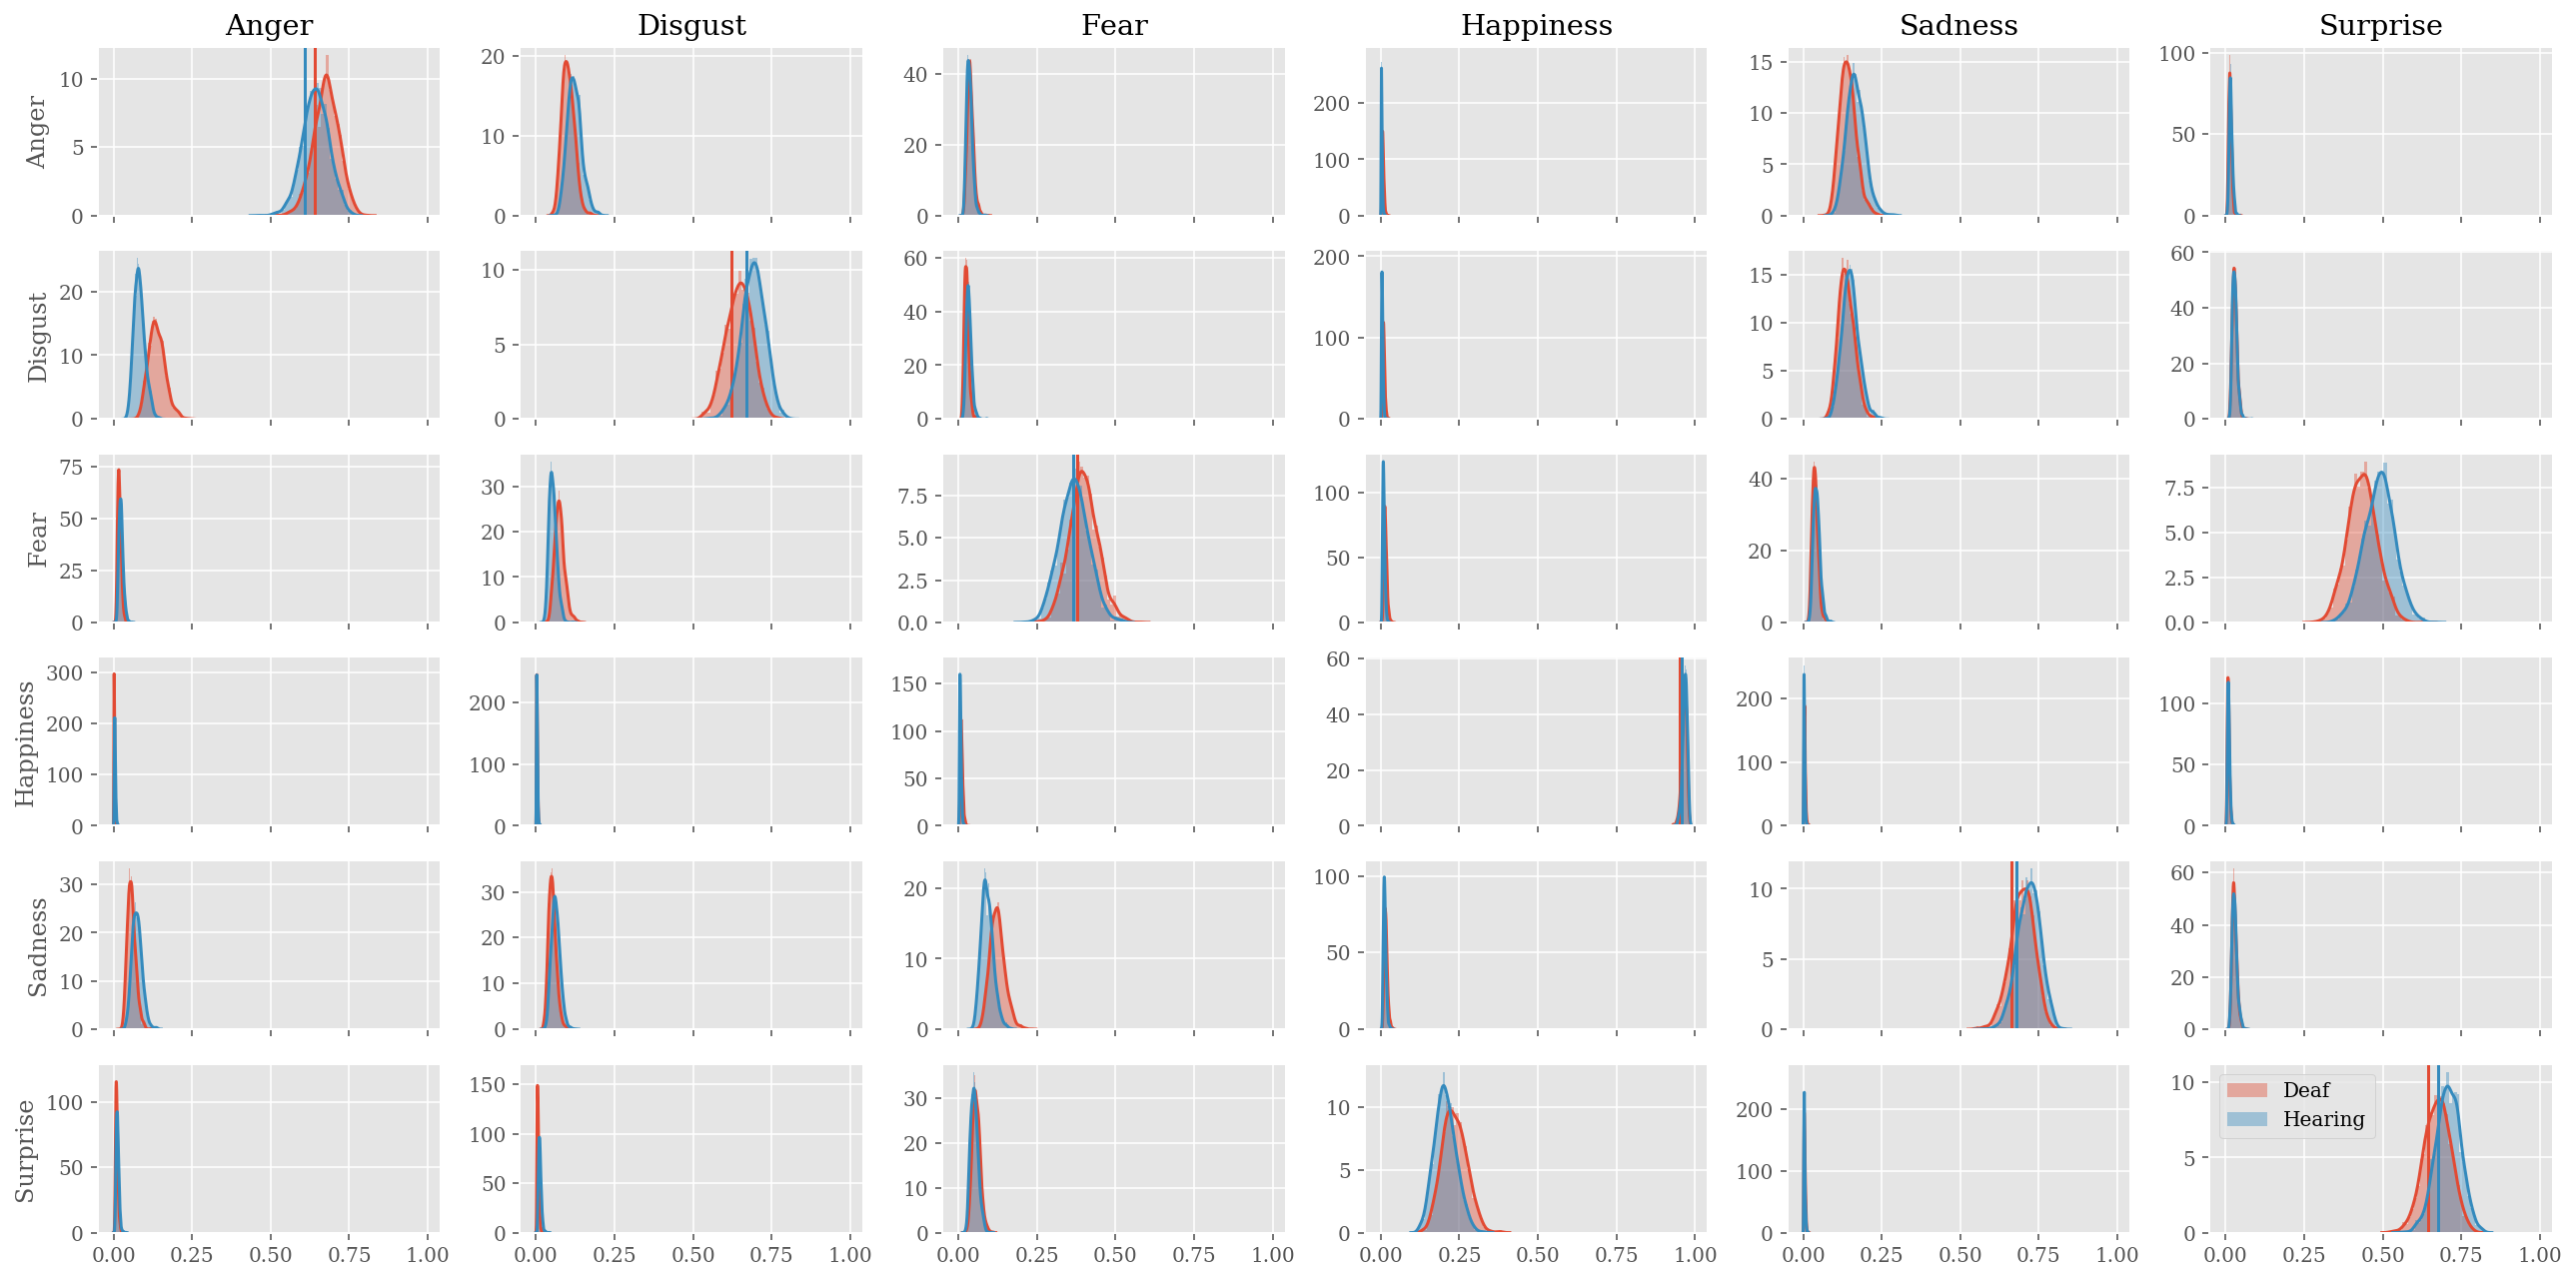

In [73]:
plotgroup_p(postp2, 2)
plt.savefig('figs/Posterior_Static_condition.svg',
            format='svg', dpi=300)

Displaying task Shuffled


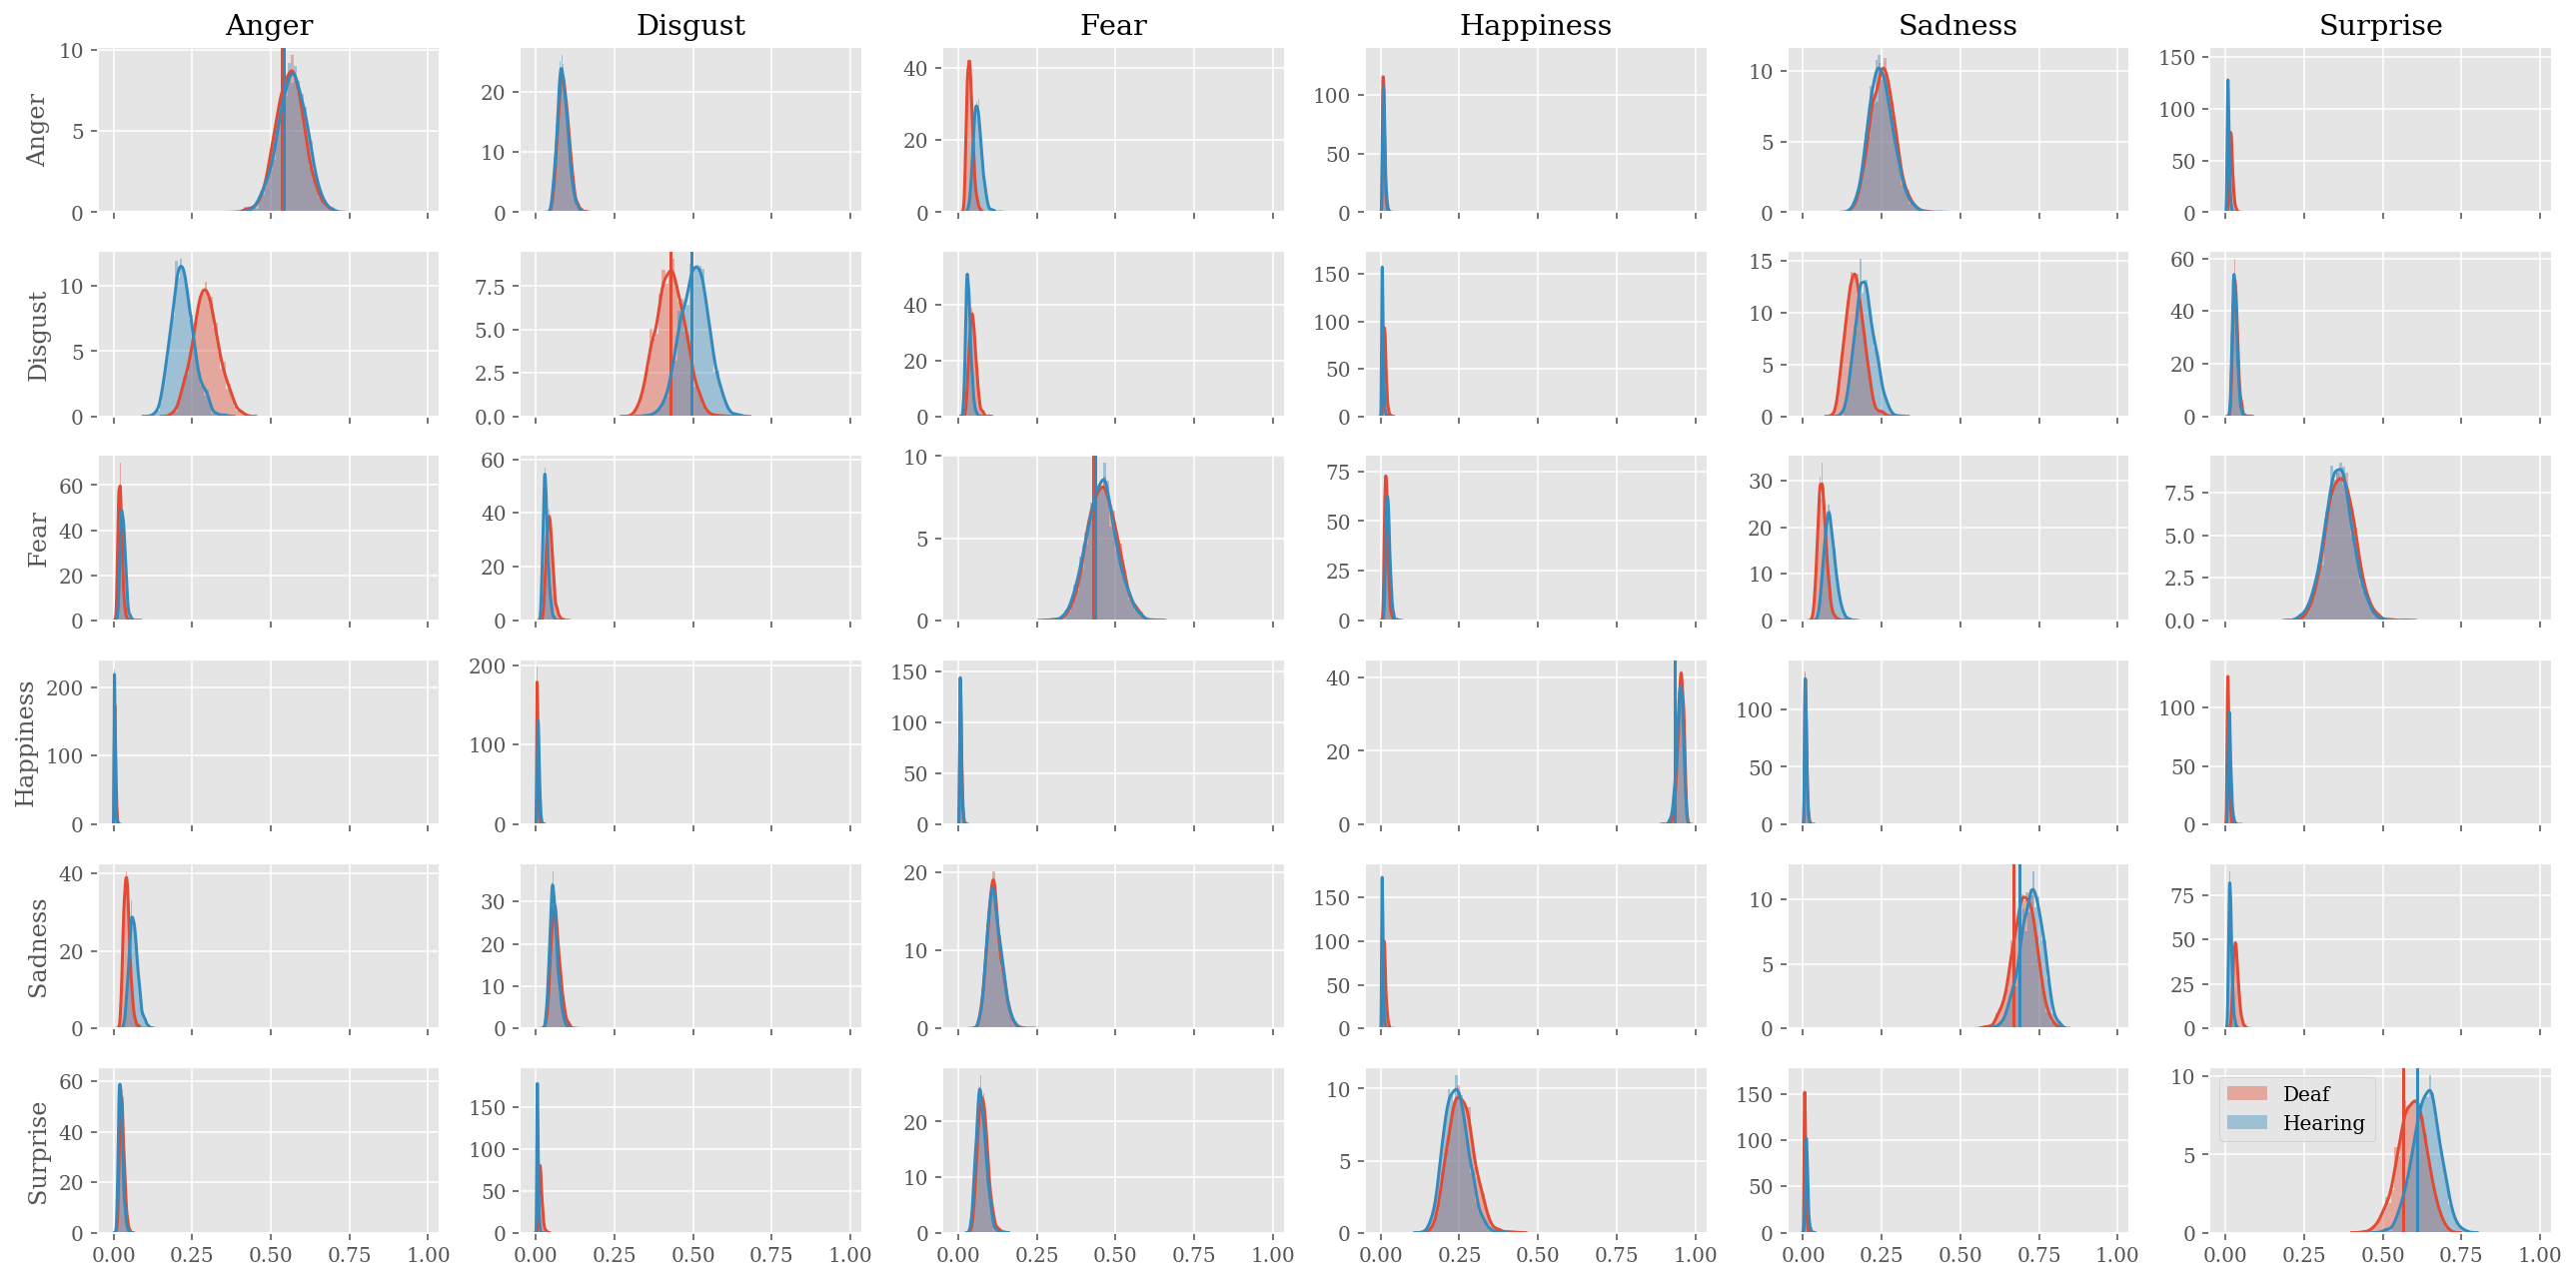

In [74]:
plotgroup_p(postp2, 1)
plt.savefig('figs/Posterior_Shuffled_condition.svg',
            format='svg', dpi=300)

Displaying dynamic advantage [Dynamic minus Static]


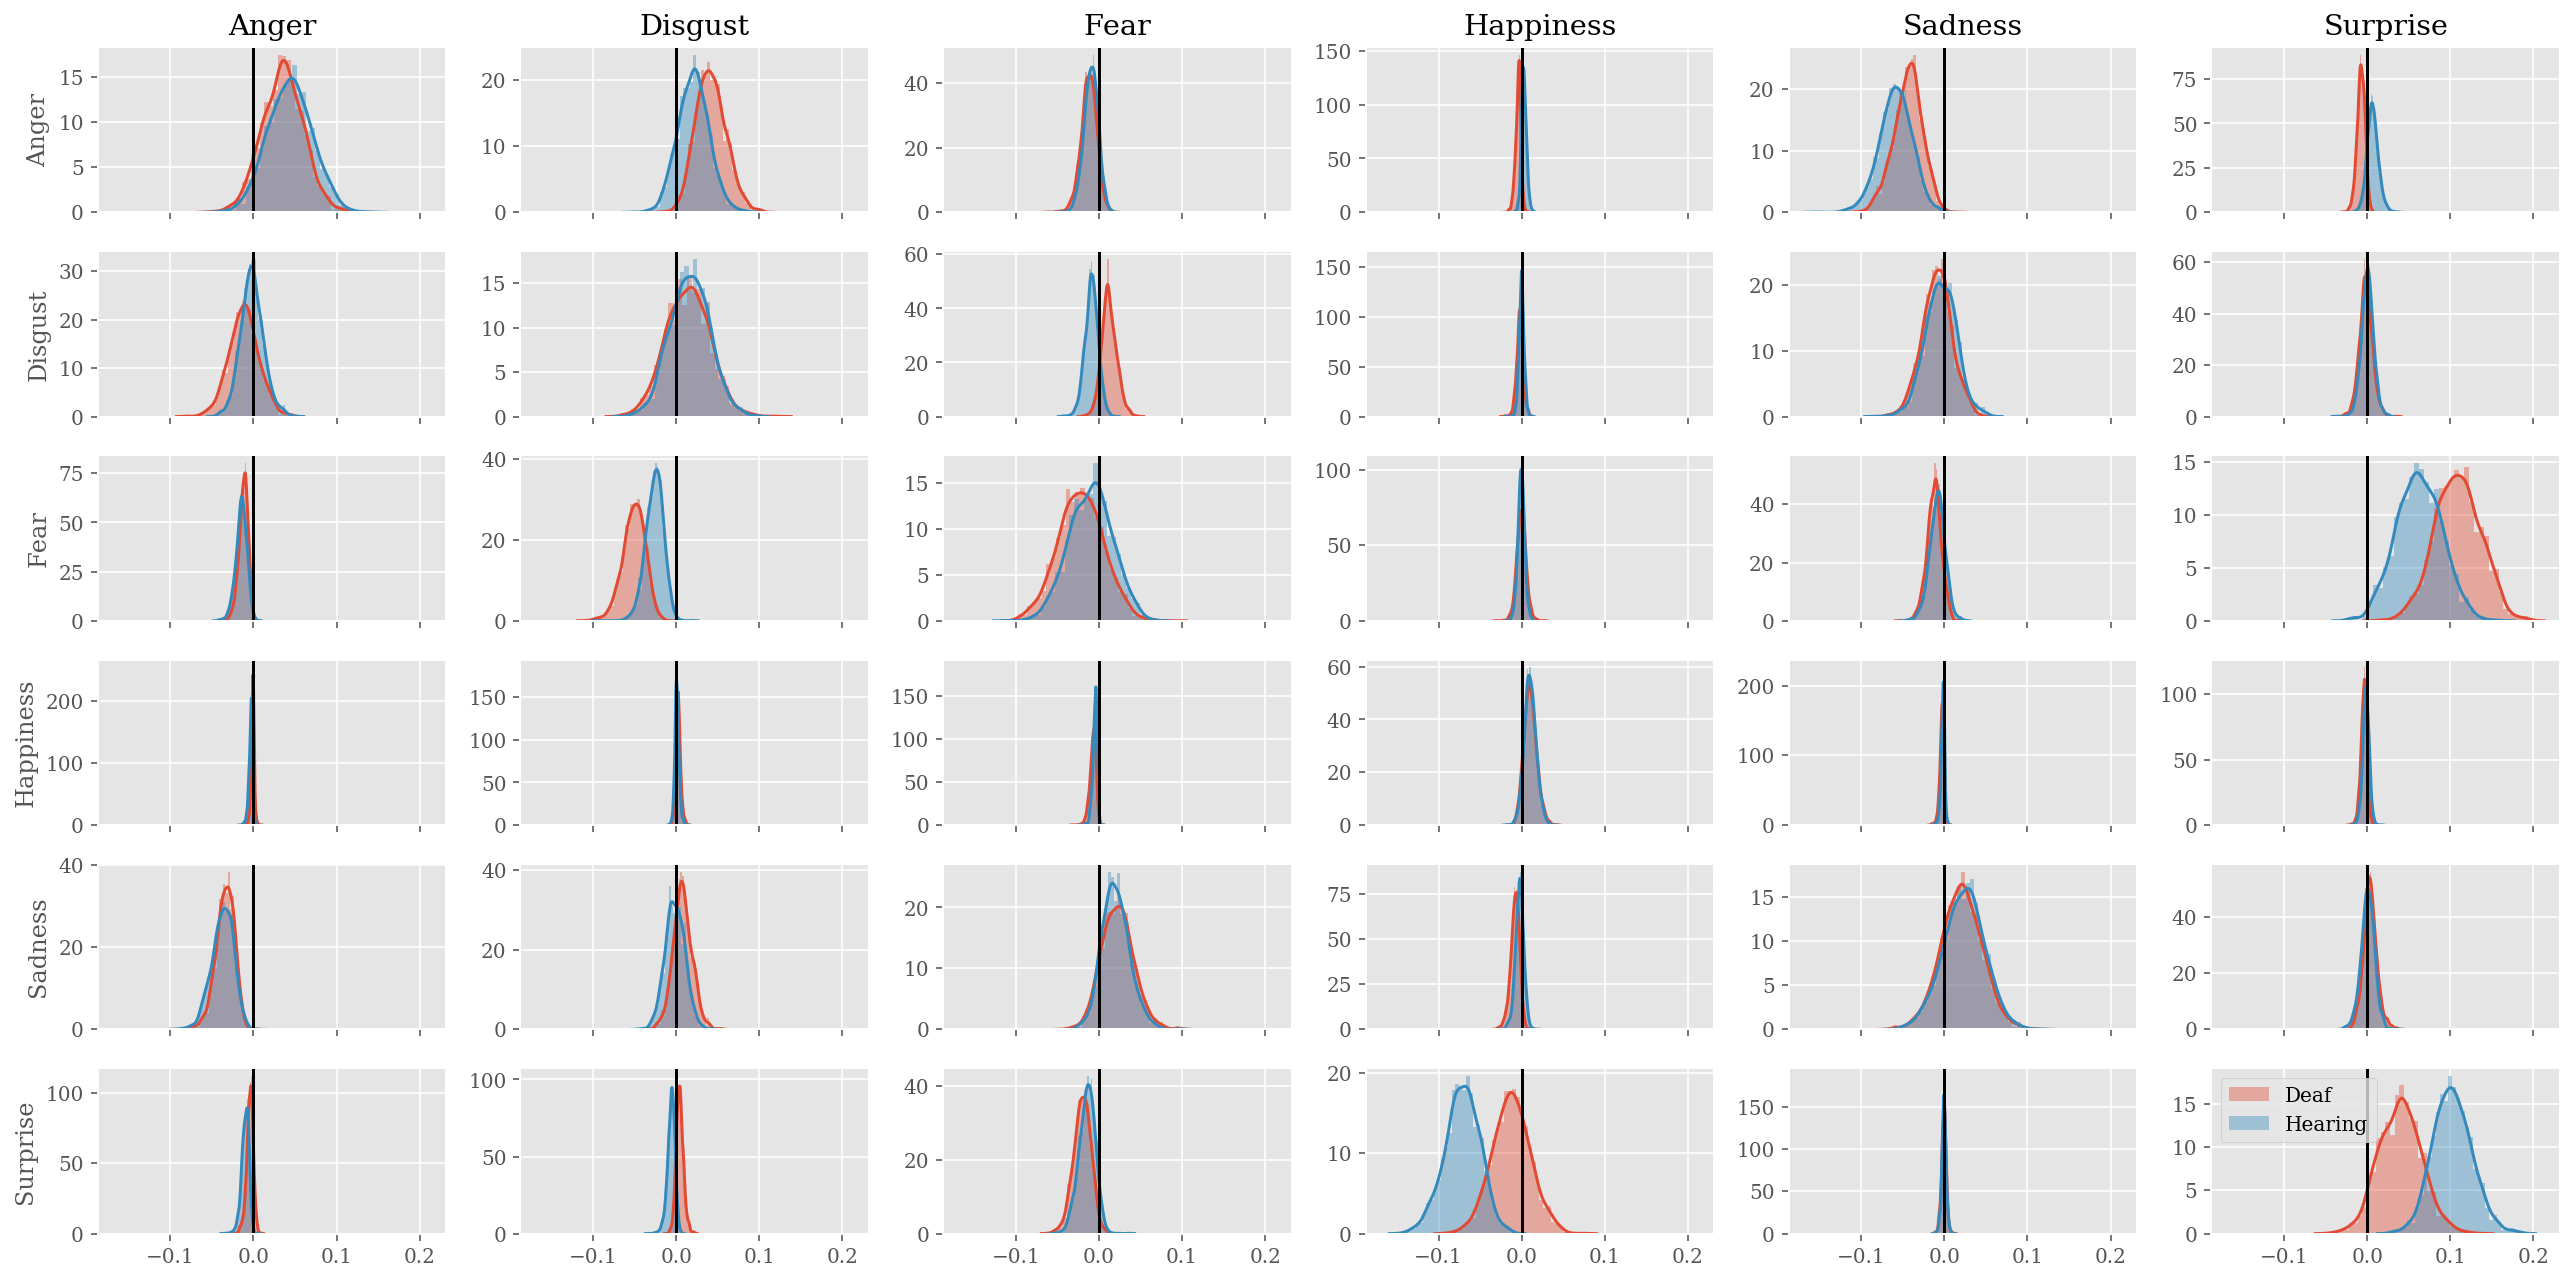

In [75]:
post_dync_adv(postp2)

plt.savefig('figs/Posterior_Differences_Dynamic-Static.svg',
            format='svg', dpi=300)

In [76]:
def df_dync_adv(postp2, ie=0):
    funcs = [lambda x: pd.Series(np.mean(x, 0), name='mean'),
             lambda x: pd.Series(np.std(x, 0), name='sd'),
             lambda x: pd.Series(pm.stats.mcse(x.T), name='mc_error'),
             lambda x: pd.DataFrame(pm.stats.hpd(flat_vals, .05), 
                                    columns=['hpd_2.5', 'hpd_97.5'])]

    expname = exp_list[ie]
    print('Displaying Dynamic-Static in ' + expname + ' condition:')
    var_dfs = []
    postp2_ = np.squeeze(postp2[:, :, 0, :, :] - postp2[:, :, 2, :, :])
    for irsp, rspname in enumerate(resp_list):
        for ig, grpname in enumerate(grplist):
            vals = postp2_[:, ig, ie, irsp]
            flat_vals = vals.reshape(vals.shape[0], -1)
            var_df = pd.concat([f(flat_vals) for f in funcs], axis=1)
            var_df['Respond'] = rspname
            var_df['Express'] = expname
            var_df['Group'] = grpname
            var_dfs.append(var_df)
        vals = postp2_[:, 0, ie, irsp] - postp2_[:, 1, ie, irsp]
        flat_vals = vals.reshape(vals.shape[0], -1)
        var_df = pd.concat([f(flat_vals) for f in funcs], axis=1)
        var_df['Respond'] = rspname
        var_df['Express'] = expname
        var_df['Group'] = 'Diff'
        var_dfs.append(var_df)

    dforg = pd.concat(var_dfs, axis=0)
    return dforg.set_index(['Express', 'Respond', 'Group'])

In [77]:
df_dync_adv(postp2, ie=5)

Displaying Dynamic-Static in Surprise condition:


mean        sd  mc_error   hpd_2.5  hpd_97.5
Express  Respond   Group                                                    
Surprise Anger     Deaf    -0.004235  0.004037  0.000084 -0.003335 -0.002943
                   Hearing -0.009843  0.004574  0.000091 -0.006945 -0.006483
                   Diff     0.005608  0.005912  0.000122  0.006115  0.006683
         Disgust   Deaf     0.004391  0.004396  0.000093  0.004132  0.004566
                   Hearing -0.006006  0.004638  0.000095 -0.005354 -0.004951
                   Diff     0.010397  0.006389  0.000133  0.008329  0.008947
         Fear      Deaf    -0.020091  0.010605  0.000244 -0.016203 -0.015053
                   Hearing -0.014303  0.010009  0.000229 -0.013391 -0.012342
                   Diff    -0.005788  0.014492  0.000335 -0.009515 -0.008012
         Happiness Deaf    -0.012301  0.022999  0.000537 -0.013926 -0.011645
                   Hearing -0.071514  0.021264  0.000474 -0.065207 -0.063104
                   Diff     0.059213  0.031508  0.000710  0.053089  0.056012
         Sadness   Deaf    -0.000512  0.002940  0.000062  0.000296  0.000545
                   Hearing -0.000488  0.002776  0.000054 -0.000491 -0.000269
                   Diff    -0.000024  0.004063  0.000085 -0.000961 -0.000551
         Surprise  Deaf     0.039993  0.025602  0.000584  0.037578  0.039992
                   Hearing  0.102690  0.023487  0.000521  0.097621  0.100006
                   Diff    -0.062697  0.034945  0.000787 -0.066285 -0.062940
         Null      Deaf    -0.007245  0.004155  0.000082 -0.006178 -0.005798
                   Hearing -0.000537  0.002953  0.000063 -0.000724 -0.000477
                   Diff    -0.006709  0.005046  0.000104 -0.006557 -0.006049